## TODO
### Plumbing
- [DONE] add 'selected' column to dataframes, discard exp16 GAL pictures
- [DONE] remove cells straddling the border (implemented, needs a rerun)
- [DONE] make sure replicate colors are consistent (e.g. add pseudo-counts for absent replicate)
### Sanity checks
- [DONE] compare plots with original spots and decomposed spots
- [DONE] inspect cells with very high numbers of mRNAs
- [DONE] GAL exp16 09 has 140/143 cells with hipBA????
### Plots
- [DONE] expression/concentrations versus area/eccentricity
- [DONE] expression/concentrations versus growth rate
- plots: distance to centroid/wall/tip 
### Reprocess
- [DONE] compute cell area on non-expanded masks
- [DONE] recompute concentrations with volumes
### Gaurav's points
- sacculi
- add random cells just before fixing to estimate background
- estimate how many mRNAs overall are in a cell for each condition => what fraction of the whole mRNA population is our mRNA of interest 
- use CCCP to cause stress

## Setup

### Imports

In [1]:
from pathlib import Path
import pandas as pd
import re
import logging
import seaborn as sns
from itertools import combinations, product
from matplotlib import pyplot as plt
import numpy as np


#from IPython.utils import io

pd.options.display.precision = 2

In [2]:
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s ', datefmt='%m/%d/%Y %I:%M:%S%p', level=logging.INFO)
rootdir = "/Volumes/Flodrive/Florence/smFISH/analysis"

logging.info(f'reading from directory {rootdir}')

11/25/2024 04:29:39PM [INFO] reading from directory /Volumes/Flodrive/Florence/smFISH/analysis 


### Constants

In [3]:
conditions = [
    {'label': 'LB', 'mu': 2.3},
    {'label': 'GLU', 'mu': 0.54},
    {'label': 'GLY', 'mu': 0.32},
    {'label': 'GAL', 'mu': 0.17},
    {'label': 'MAN', 'mu': 0.12},
]

growth_rates = {c['label']: c['mu'] for c in conditions}

mrna_ordered = ['rpoD', 'rnlAB', 'hipBA']
csources_ordered = [c['label'] for c in conditions]
replicates_ordered = ['exp16', 'exp22', 'exp24']

### Palettes

In [4]:
palette_mrna = {
    'rpoD': 'magenta',
    'rnlAB': 'cyan',
    'hipBA': 'yellow',
}
palette_replicate = { z[0]: z[1] for z in zip(replicates_ordered, sns.color_palette("hls", len(replicates_ordered))) }
palette_csource = { z[0]: z[1] for z in zip(csources_ordered, sns.color_palette("viridis", len(csources_ordered))) }
palette_csource

{'LB': (0.267968, 0.223549, 0.512008),
 'GLU': (0.190631, 0.407061, 0.556089),
 'GLY': (0.127568, 0.566949, 0.550556),
 'GAL': (0.20803, 0.718701, 0.472873),
 'MAN': (0.565498, 0.84243, 0.262877)}

# Results

## Load data

#### Stacked format
- format with 1 row per cell and per mrna
- mrna is specified in 'mrna' column
- so this df has about 3x total number of cells rows (because we have 3 rna channels)

In [6]:
dfs = []
for f in Path(rootdir).glob('*/*/results.csv'):
    cell_df = pd.read_csv(f.parent / "cells.csv")
    for mrna in mrna_ordered:
        f_mrna = Path(str(f) + f'.{mrna}')
        logging.info(f'..loading file: {f_mrna}')
        df = pd.read_csv(f_mrna)
        df['image'] = f_mrna.parts[-2]
        df['experiment'] = f_mrna.parts[-3]
        df = df.join(cell_df.set_index('image_cell_id'), on='image_cell_id')
        dfs.append(df)
df_stacked = pd.concat(dfs)

11/25/2024 04:49:22PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_01/results.csv.rpoD 
11/25/2024 04:49:22PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_01/results.csv.rnlAB 
11/25/2024 04:49:22PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_01/results.csv.hipBA 
11/25/2024 04:49:22PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_03/results.csv.rpoD 
11/25/2024 04:49:22PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_03/results.csv.rnlAB 
11/25/2024 04:49:22PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_03/results.csv.hipBA 
11/25/2024 04:49:23PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_05/results.csv.rpoD 
11

In [8]:
pattern = re.compile(f'(?P<strain>[0-9A-Za-z]+)[_-](?P<csource>{"|".join(csources_ordered)})[-_](?P<coverslip>.*)')

def parse_image_name(r):
    s = r['image']
    match = pattern.search(s)
    d = match.groupdict()
    
    seqnr = re.search('(?P<seqnr>[0-9]+)$', d['coverslip'])[0]
    d['coverslip'] = re.sub('_[0-9]+$', '', d['coverslip'])
    return d['strain'], d['csource'], d['coverslip'], seqnr 

df_stacked[['strain', 'csource', 'coverslip', 'seqnr']] = df_stacked.apply(parse_image_name, axis=1, result_type='expand')
df_stacked['strain'] = 'MG1655'
df_stacked['replicate'] = df_stacked['experiment'].apply(lambda x: re.search('exp[0-9]+|LB$', x)[0])
df_stacked.loc[df_stacked['csource'] == 'LB', 'replicate'] = 'exp22'
df_stacked['unique_cell_id'] = df_stacked.apply(lambda r: r['replicate'] + "." + r['image'] + "." + str(r['image_cell_id']), axis=1)
df_stacked['selected'] = True

# after checking quality manually, we exclude 20241003-exp16 from the analysis:
df_stacked.loc[(df_stacked['experiment']=='20241003-exp16'), "selected"] = False
df_stacked = df_stacked[df_stacked['selected']]

df_stacked['RNAs_over_area'] = df_stacked['total_RNAs'] / df_stacked['area']
df_stacked['volume'] = 4 / 3 * np.pi * pow(df_stacked['axis_minor_length'] / 2, 3) + np.pi * pow(df_stacked['axis_minor_length'] / 2, 2) * (df_stacked['axis_major_length'] - df_stacked['axis_minor_length'])
df_stacked['volume_ellipsoid'] = 4 / 3 * df_stacked['area'] * df_stacked['axis_minor_length'] / 2
df_stacked['RNAs_over_vol'] = df_stacked['total_RNAs'] / df_stacked['volume']
df_stacked['RNAs_over_length'] = df_stacked['total_RNAs'] / df_stacked['axis_major_length']
df_stacked['RNAs_over_eccentricity'] = df_stacked['total_RNAs'] / df_stacked['eccentricity']

df_stacked.loc[:, 'mu'] = df_stacked.apply(lambda r: r['csource'] + '\n' + 'µ=' + str(growth_rates[r['csource']]) , axis=1)
df_stacked


image_cell_id  spots  dense_regions  decomposed_RNAs  tx  nascent_RNAs  \
0              531      0              0                0   0             0   
1              533      0              0                0   0             0   
2              535      0              0                0   0             0   
3              537      0              0                0   0             0   
4              540      0              0                0   0             0   
..             ...    ...            ...              ...  ..           ...   
482            956      0              0                0   0             0   
483            965      1              0                0   0             0   
484            966      2              0                0   0             0   
485            974      1              1                3   1             3   
486            981      1              0                0   0             0   

     total_RNAs   mrna  strain                    condition  ... replicate  \
0             0   rpoD  MG1655                          GLU  ...     exp24   
1             0   rpoD  MG1655                          GLU  ...     exp24   
2             0   rpoD  MG1655                          GLU  ...     exp24   
3             0   rpoD  MG1655                          GLU  ...     exp24   
4             0   rpoD  MG1655                          GLU  ...     exp24   
..          ...    ...     ...                          ...  ...       ...   
482           0  hipBA  MG1655  LB_fixed2806_hybed1906_left  ...     exp22   
483           1  hipBA  MG1655  LB_fixed2806_hybed1906_left  ...     exp22   
484           2  hipBA  MG1655  LB_fixed2806_hybed1906_left  ...     exp22   
485           3  hipBA  MG1655  LB_fixed2806_hybed1906_left  ...     exp22   
486           1  hipBA  MG1655  LB_fixed2806_hybed1906_left  ...     exp22   

                                      unique_cell_id selected  RNAs_over_area  \
0                     exp24.exp24-GLU-right-2_01.531     True        0.00e+00   
1                     exp24.exp24-GLU-right-2_01.533     True        0.00e+00   
2                     exp24.exp24-GLU-right-2_01.535     True        0.00e+00   
3                     exp24.exp24-GLU-right-2_01.537     True        0.00e+00   
4                     exp24.exp24-GLU-right-2_01.540     True        0.00e+00   
..                                               ...      ...             ...   
482  exp22.MG1655_LB_fixed2806_hybed1906_left_07.956     True        0.00e+00   
483  exp22.MG1655_LB_fixed2806_hybed1906_left_07.965     True        1.81e-03   
484  exp22.MG1655_LB_fixed2806_hybed1906_left_07.966     True        1.63e-03   
485  exp22.MG1655_LB_fixed2806_hybed1906_left_07.974     True        3.75e-03   
486  exp22.MG1655_LB_fixed2806_hybed1906_left_07.981     True        1.51e-03   

       volume  volume_ellipsoid  RNAs_over_vol  RNAs_over_length  \
0    10144.30           8242.59       0.00e+00              0.00   
1    13059.74          10667.32       0.00e+00              0.00   
2    14049.50          10194.07       0.00e+00              0.00   
3    11334.32           8799.67       0.00e+00              0.00   
4     9273.39           6985.55       0.00e+00              0.00   
..        ...               ...            ...               ...   
482  10921.15           8168.65       0.00e+00              0.00   
483   8107.40           6102.65       1.23e-04              0.02   
484  24412.31          17574.28       8.19e-05              0.03   
485  14260.88          10908.94       2.10e-04              0.06   
486  10906.94           8337.21       9.17e-05              0.02   

     RNAs_over_eccentricity           mu  
0                      0.00  GLU\nµ=0.54  
1                      0.00  GLU\nµ=0.54  
2                      0.00  GLU\nµ=0.54  
3                      0.00  GLU\nµ=0.54  
4                      0.00  GLU\nµ=0.54  
..                      ...          ...  
482                    0.00 

In [9]:
df_stacked.columns

Index(['image_cell_id', 'spots', 'dense_regions', 'decomposed_RNAs', 'tx',
       'nascent_RNAs', 'total_RNAs', 'mrna', 'strain', 'condition', 'seqnr',
       'image', 'experiment', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'axis_minor_length', 'axis_major_length', 'orientation',
       'perimeter', 'solidity', 'nuclei', 'csource', 'coverslip', 'replicate',
       'unique_cell_id', 'selected', 'RNAs_over_area', 'volume',
       'volume_ellipsoid', 'RNAs_over_vol', 'RNAs_over_length',
       'RNAs_over_eccentricity', 'mu'],
      dtype='object')

In [10]:
csources = df_stacked['csource'].unique()
strains = df_stacked['strain'].unique()
seqnrs = df_stacked['seqnr'].unique() 
mrnas = df_stacked['mrna'].unique() 
replicates = df_stacked['replicate'].unique()
experiments = df_stacked['experiment'].unique()
csources, strains, seqnrs, mrnas, replicates, experiments

(array(['GLU', 'GLY', 'GAL', 'MAN', 'LB'], dtype=object),
 array(['MG1655'], dtype=object),
 array(['01', '03', '05', '02', '06', '10', '04', '07', '08', '09', '11'],
       dtype=object),
 array(['rpoD', 'rnlAB', 'hipBA'], dtype=object),
 array(['exp24', 'exp22', 'exp16'], dtype=object),
 array(['20241029-exp24', '20241029-exp22', '20240927-exp16',
        '20240927-LB'], dtype=object))

In [11]:
df_stacked.query('total_RNAs > 10')

image_cell_id  spots  dense_regions  decomposed_RNAs  tx  nascent_RNAs  \
32             286      1              1               11   1            11   
85             358     10              4               18   0             0   
93             752      7              3                7   0             0   
93             752     18              3               11   0             0   
68             246      1              1               18   0             0   
..             ...    ...            ...              ...  ..           ...   
156            285      5              3                9   2             6   
225            406      4              2                9   1             4   
379            719      7              3               10   2             7   
415            807      5              3               11   2             8   
461            911      4              3               12   3            12   

     total_RNAs   mrna  strain                    condition  ... replicate  \
32           11  hipBA  MG1655                          GLY  ...     exp24   
85           24  hipBA  MG1655                          GLY  ...     exp24   
93           11   rpoD  MG1655                          GLY  ...     exp24   
93           26  hipBA  MG1655                          GLY  ...     exp24   
68           18  rnlAB  MG1655                          GLY  ...     exp24   
..          ...    ...     ...                          ...  ...       ...   
156          11  rnlAB  MG1655  LB_fixed2806_hybed1906_left  ...     exp22   
225          11  rnlAB  MG1655  LB_fixed2806_hybed1906_left  ...     exp22   
379          14  rnlAB  MG1655  LB_fixed2806_hybed1906_left  ...     exp22   
415          13  rnlAB  MG1655  LB_fixed2806_hybed1906_left  ...     exp22   
461          13  rnlAB  MG1655  LB_fixed2806_hybed1906_left  ...     exp22   

                                      unique_cell_id selected  RNAs_over_area  \
32                       exp24.exp24-GLY-left_02.286     True        2.10e-02   
85                       exp24.exp24-GLY-left_02.358     True        1.53e-02   
93                       exp24.exp24-GLY-left_03.752     True        1.26e-03   
93                       exp24.exp24-GLY-left_03.752     True        2.97e-03   
68                       exp24.exp24-GLY-left_06.246     True        2.29e-02   
..                                               ...      ...             ...   
156  exp22.MG1655_LB_fixed2806_hybed1906_left_07.285     True        7.10e-03   
225  exp22.MG1655_LB_fixed2806_hybed1906_left_07.406     True        1.18e-02   
379  exp22.MG1655_LB_fixed2806_hybed1906_left_07.719     True        7.30e-03   
415  exp22.MG1655_LB_fixed2806_hybed1906_left_07.807     True        1.03e-02   
461  exp22.MG1655_LB_fixed2806_hybed1906_left_07.911     True        1.40e-02   

       volume  volume_ellipsoid  RNAs_over_vol  RNAs_over_length  \
32   8.19e+03           6593.01       1.34e-03              0.31   
85   2.85e+04          18535.62       8.42e-04              0.20   
93   8.38e+06         918241.57       1.31e-06              0.02   
93   8.38e+06         918241.57       3.10e-06              0.05   
68   1.44e+04          10241.53       1.25e-03              0.33   
..        ...               ...            ...               ...   
156  3.02e+04          20693.11       3.65e-04              0.11   
225  1.71e+04          12677.97       6.45e-04              0.19   
379  4.05e+04          26405.45       3.46e-04              0.11   
415  2.17e+04          14426.22       5.99e-04              0.13   
461  1.87e+04          13816.43       6.97e-04              0.24   

     RNAs_over_eccentricity           mu  
32                    12.98  GLY\nµ=0.32  
85                    24.26  GLY\nµ=0.32  
93                    11.64  GLY\nµ=0.32  
93                    27.50  GLY\nµ=0.32  
68                    19.28  GLY\nµ=0.32  
..                      ...          ...  
156                   11.22 

In [12]:
df_stacked.query('total_RNAs > 10')['mrna'].value_counts()

mrna
rpoD     146
rnlAB     43
hipBA     12
Name: count, dtype: int64

In [13]:
df_stacked.query('dense_regions > 0')


image_cell_id  spots  dense_regions  decomposed_RNAs  tx  nascent_RNAs  \
11             561      2              1                3   0             0   
17             579      2              1                7   0             0   
203           1069      1              1                2   1             2   
234           1136      1              1                3   0             0   
245           1150      1              1                3   0             0   
..             ...    ...            ...              ...  ..           ...   
446            881      3              1                4   1             4   
450            888      1              1                3   1             3   
461            911      2              1                3   1             3   
473            938      2              1                2   0             0   
485            974      1              1                3   1             3   

     total_RNAs   mrna  strain                    condition  ... replicate  \
11            4   rpoD  MG1655                          GLU  ...     exp24   
17            8   rpoD  MG1655                          GLU  ...     exp24   
203           2   rpoD  MG1655                          GLU  ...     exp24   
234           3   rpoD  MG1655                          GLU  ...     exp24   
245           3   rpoD  MG1655                          GLU  ...     exp24   
..          ...    ...     ...                          ...  ...       ...   
446           6  hipBA  MG1655  LB_fixed2806_hybed1906_left  ...     exp22   
450           3  hipBA  MG1655  LB_fixed2806_hybed1906_left  ...     exp22   
461           4  hipBA  MG1655  LB_fixed2806_hybed1906_left  ...     exp22   
473           3  hipBA  MG1655  LB_fixed2806_hybed1906_left  ...     exp22   
485           3  hipBA  MG1655  LB_fixed2806_hybed1906_left  ...     exp22   

                                      unique_cell_id selected  RNAs_over_area  \
11                    exp24.exp24-GLU-right-2_01.561     True        5.24e-03   
17                    exp24.exp24-GLU-right-2_01.579     True        9.54e-03   
203                  exp24.exp24-GLU-right-2_01.1069     True        2.79e-03   
234                  exp24.exp24-GLU-right-2_01.1136     True        4.03e-03   
245                  exp24.exp24-GLU-right-2_01.1150     True        6.41e-03   
..                                               ...      ...             ...   
446  exp22.MG1655_LB_fixed2806_hybed1906_left_07.881     True        7.68e-03   
450  exp22.MG1655_LB_fixed2806_hybed1906_left_07.888     True        1.95e-03   
461  exp22.MG1655_LB_fixed2806_hybed1906_left_07.911     True        4.32e-03   
473  exp22.MG1655_LB_fixed2806_hybed1906_left_07.938     True        2.58e-03   
485  exp22.MG1655_LB_fixed2806_hybed1906_left_07.974     True        3.75e-03   

       volume  volume_ellipsoid  RNAs_over_vol  RNAs_over_length  \
11   13734.56          10714.32       2.91e-04              0.09   
17   15560.60          12069.87       5.14e-04              0.16   
203  13171.17          10680.81       1.52e-04              0.05   
234  12782.16           9651.26       2.35e-04              0.06   
245   6960.50           5336.27       4.31e-04              0.08   
..        ...               ...            ...               ...   
446  13385.19          10123.98       4.48e-04              0.12   
450  30284.77          20789.68       9.91e-05              0.03   
461  18658.24          13816.43       2.14e-04              0.07   
473  23294.06          16920.80       1.29e-04              0.04   
485  14260.88          10908.94       2.10e-04              0.06   

     RNAs_over_eccentricity           mu  
11                     4.48  GLU\nµ=0.54  
17                     8.88  GLU\nµ=0.54  
203                    2.38  GLU\nµ=0.54  
234                    3.26  GLU\nµ=0.54  
245                    3.41  GLU\nµ=0.54  
..                      ...          ...  
446                    6.48 

In [14]:
(df_stacked.query('dense_regions > 0')['mrna'].value_counts())


mrna
rpoD     1233
rnlAB     706
hipBA     544
Name: count, dtype: int64

In [15]:
df_stacked.query('tx > 0')['mrna'].value_counts()

mrna
rpoD     754
rnlAB    457
hipBA    264
Name: count, dtype: int64

#### Record format
- 1 row per cell, with info for all 3 mrna in this row
- number of rows = number of cells total (all processed pictures from all experiments)

In [16]:
dfs = []
for f in Path(rootdir).glob('*/*/results.csv'):
    logging.info(f'..loading file: {f}')
    df = pd.read_csv(f)
    df['image'] = f.parts[-2]
    df['experiment'] = f.parts[-3]
    dfs.append(df)
df_records = pd.concat(dfs)

11/25/2024 04:50:12PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_01/results.csv 
11/25/2024 04:50:12PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_03/results.csv 
11/25/2024 04:50:12PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_05/results.csv 
11/25/2024 04:50:12PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLY-left_02/results.csv 
11/25/2024 04:50:12PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLY-left_03/results.csv 
11/25/2024 04:50:12PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLY-left_06/results.csv 
11/25/2024 04:50:12PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLY-left_10/results.csv 
11/25/2024 04:50:13PM [INFO] ..loading file: /Volumes

In [17]:
df_records[['strain', 'csource', 'coverslip', 'seqnr']] = df_records.apply(parse_image_name, axis=1, result_type='expand')
df_records['strain'] = 'MG1655'
df_records['replicate'] = df_records['experiment'].apply(lambda x: re.search('exp[0-9]+|LB$', x)[0])
df_records.loc[df_records['csource'] == 'LB', 'replicate'] = 'exp22'
df_records['unique_cell_id'] = df_records.apply(lambda r: r['replicate'] + "." + r['image'] + "." + str(r['image_cell_id']), axis=1)
df_records['selected'] = True
# after checking quality manually, we exclude 20241003-exp16 from the analysis:
df_records.loc[(df_records['experiment']=='20241003-exp16'), "selected"] = False
df_records = df_records[df_records['selected'] == True]

df_records['mu'] = df_records.apply(lambda r: growth_rates[r['csource']], axis=1)
df_records['volume'] = 4 / 3 * np.pi * pow(df_records['axis_minor_length'] / 2, 3) + np.pi * pow(df_records['axis_minor_length'] / 2, 2) * (df_records['axis_major_length'] - df_records['axis_minor_length'])
df_records['volume_ellipsoid'] = 4 / 3 * df_records['area'] * df_records['axis_minor_length'] / 2

for mrna in mrna_ordered:
    df_records[f'RNAs_over_area_{mrna}'] = df_records[f'total_RNAs_{mrna}'] / df_records['area']
    df_records[f'RNAs_over_vol_{mrna}'] = df_records[f'total_RNAs_{mrna}'] / df_records['volume']
df_records


image_cell_id  bbox-0  bbox-1  bbox-2  bbox-3    area  eccentricity  \
0              531       1     485      22     522   600.0          0.83   
1              533       2     891      34     925   710.0          0.83   
2              535       3     801      45     842   803.0          0.94   
3              537       7     194      43     228   672.0          0.89   
4              540      12     791      48     826   621.0          0.93   
..             ...     ...     ...     ...     ...     ...           ...   
482            956     951     335     969     380   681.0          0.93   
483            965     956     295     975     336   554.0          0.92   
484            966     956    1176     986    1244  1230.0          0.96   
485            974     960     542     985     589   800.0          0.91   
486            981     966     341     987     384   661.0          0.91   

     axis_minor_length  axis_major_length  orientation  ...  selected    mu  \
0                20.61              37.29        -1.45  ...      True  0.54   
1                22.54              40.25        -0.86  ...      True  0.54   
2                19.04              55.68         0.76  ...      True  0.54   
3                19.64              43.95         0.71  ...      True  0.54   
4                16.87              47.10         0.76  ...      True  0.54   
..                 ...                ...          ...  ...       ...   ...   
482              17.99              48.95        -1.49  ...      True  2.30   
483              16.52              43.32        -1.37  ...      True  2.30   
484              21.43              74.81        -1.33  ...      True  2.30   
485              20.45              50.22         1.34  ...      True  2.30   
486              18.92              45.10        -1.44  ...      True  2.30   

       volume  volume_ellipsoid  RNAs_over_area_rpoD  RNAs_over_vol_rpoD  \
0    10144.30           8242.59             0.00e+00            0.00e+00   
1    13059.74          10667.32             0.00e+00            0.00e+00   
2    14049.50          10194.07             0.00e+00            0.00e+00   
3    11334.32           8799.67             0.00e+00            0.00e+00   
4     9273.39           6985.55             0.00e+00            0.00e+00   
..        ...               ...                  ...                 ...   
482  10921.15           8168.65             1.03e-02            6.41e-04   
483   8107.40           6102.65             1.26e-02            8.63e-04   
484  24412.31          17574.28             7.32e-03            3.69e-04   
485  14260.88          10908.94             6.25e-03            3.51e-04   
486  10906.94           8337.21             9.08e-03            5.50e-04   

     RNAs_over_area_rnlAB  RNAs_over_vol_rnlAB  RNAs_over_area_hipBA  \
0                0.00e+00             0.00e+00              0.00e+00   
1                0.00e+00             0.00e+00              0.00e+00   
2                0.00e+00             0.00e+00              0.00e+00   
3                0.00e+00             0.00e+00              0.00e+00   
4                0.00e+00             0.00e+00              0.00e+00   
..                    ...                  ...                   ...   
482              2.94e-03             1.83e-04              0.00e+00   
483              1.81e-03             1.23e-04              1.81e-03   
484              2.44e-03             1.23e-04              1.63e-03   
485              2.50e-03             1.40e-04              3.75e-03   
486              4.54e-03             2.75e-04              1.51e-03   

     RNAs_over_vol_hipBA  
0               0.00e+00  
1               0.00e+00  
2               0.00e+00  
3               0.00e+00  
4               0.00e+00  
..                   ...  
482             0.00e+00  
483             1.23e-04  
484             8.19e-05  
485             2.10e-04  
486             9.17e-05  

[16255 rows x 50 columns]

In [18]:
df_records.columns

Index(['image_cell_id', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'axis_minor_length', 'axis_major_length', 'orientation',
       'perimeter', 'solidity', 'nuclei', 'spots_hipBA', 'dense_regions_hipBA',
       'decomposed_RNAs_hipBA', 'tx_hipBA', 'nascent_RNAs_hipBA',
       'total_RNAs_hipBA', 'spots_rnlAB', 'dense_regions_rnlAB',
       'decomposed_RNAs_rnlAB', 'tx_rnlAB', 'nascent_RNAs_rnlAB',
       'total_RNAs_rnlAB', 'spots_rpoD', 'dense_regions_rpoD',
       'decomposed_RNAs_rpoD', 'tx_rpoD', 'nascent_RNAs_rpoD',
       'total_RNAs_rpoD', 'strain', 'condition', 'seqnr', 'image',
       'experiment', 'csource', 'coverslip', 'replicate', 'unique_cell_id',
       'selected', 'mu', 'volume', 'volume_ellipsoid', 'RNAs_over_area_rpoD',
       'RNAs_over_vol_rpoD', 'RNAs_over_area_rnlAB', 'RNAs_over_vol_rnlAB',
       'RNAs_over_area_hipBA', 'RNAs_over_vol_hipBA'],
      dtype='object')

In [19]:
df_records.shape, df_stacked.shape

((16255, 50), (48765, 37))

In [20]:
16255 * 3


48765

## Cell and spot counts

### Number of cells per csource

In [21]:
df_records.groupby(['strain', 'csource', 'replicate'])['unique_cell_id'].agg('count')

strain  csource  replicate
MG1655  GAL      exp22        1955
        GLU      exp16        2825
                 exp22        1399
                 exp24        1060
        GLY      exp16         592
                 exp22        2405
                 exp24        1683
        LB       exp22         813
        MAN      exp16        1638
                 exp22        1885
Name: unique_cell_id, dtype: int64

##### QC plot

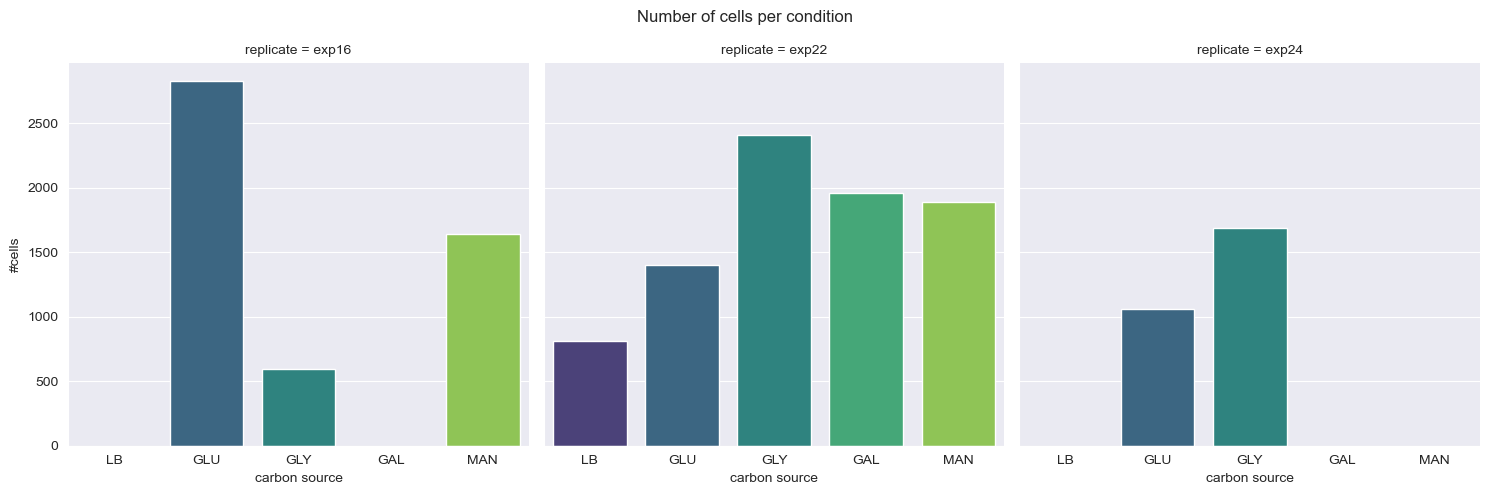

In [22]:
g = sns.catplot(pd.DataFrame(df_records.groupby(['strain', 'csource', 'replicate'])['unique_cell_id'].agg('count')).reset_index(),
            col='replicate', col_order=replicates_ordered, 
            kind='bar', estimator='sum', x='csource', order=csources_ordered, y='unique_cell_id', hue='csource', palette=palette_csource)
g.set(xlabel='carbon source', ylabel='#cells')
g.fig.suptitle('Number of cells per condition')
plt.tight_layout();

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/nr_of_cells_vs_condition"
plt.savefig(savestem + ".pdf")


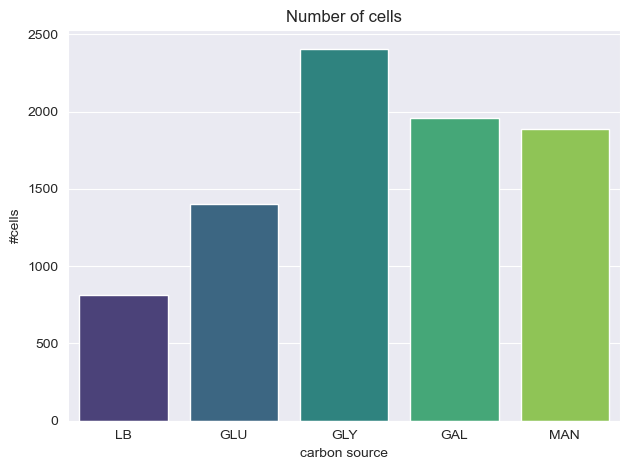

In [23]:
data = df_records.query('replicate == "exp22"')
sns.barplot(pd.DataFrame(data.groupby(['strain', 'csource', 'replicate'])['unique_cell_id'].agg('count')).reset_index(),
            estimator='sum', x='csource', order=csources_ordered, y='unique_cell_id', hue='csource', palette=palette_csource)
plt.xlabel('carbon source')
plt.ylabel('#cells')
plt.title('Number of cells')
plt.tight_layout();

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/nr_of_cells_vs_condition"
plt.savefig(savestem + ".pdf")


### Number of cells per csource per image

In [24]:
df_records.groupby(['strain', 'csource', 'replicate', 'seqnr'])['unique_cell_id'].agg('count')

strain  csource  replicate  seqnr
MG1655  GAL      exp22      03       1030
                            04        407
                            07        312
                            08        206
        GLU      exp16      02        825
                            03        593
                            04        514
                            05        893
                 exp22      01        143
                            02         99
                            04        148
                            05        128
                            06        171
                            07         98
                            08        110
                            09        318
                            10        184
                 exp24      01        431
                            03        307
                            05        322
        GLY      exp16      01         16
                            03         19
                            04        231


### Number of spots per csource

In [25]:
df_stacked.groupby(['strain', 'csource', 'replicate', 'mrna'])['total_RNAs'].agg(['sum'])


sum
strain csource replicate mrna       
MG1655 GAL     exp22     hipBA  1154
                         rnlAB   725
                         rpoD   1036
       GLU     exp16     hipBA  1033
                         rnlAB  2111
                         rpoD   6853
               exp22     hipBA   964
                         rnlAB   941
                         rpoD   4163
               exp24     hipBA   168
                         rnlAB   122
                         rpoD   1026
       GLY     exp16     hipBA    64
                         rnlAB   122
                         rpoD    390
               exp22     hipBA  1667
                         rnlAB  1292
                         rpoD   2538
               exp24     hipBA   511
                         rnlAB   308
                         rpoD   1153
       LB      exp22     hipBA  1153
                         rnlAB  2544
                         rpoD   4616
       MAN     exp16     hipBA   360
                         rnlAB   383
                         rpoD   1904
               exp22     hipBA   734
                         rnlAB   290
                         rpoD    628

#### QC plot

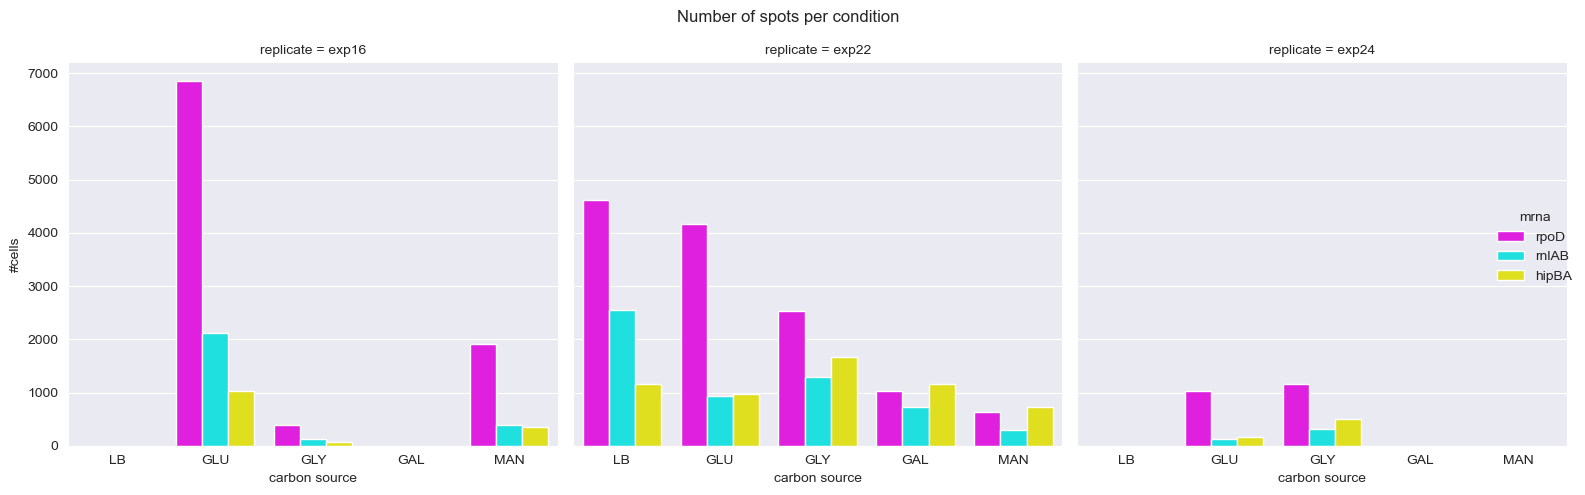

In [26]:
g = sns.catplot(pd.DataFrame(df_stacked.groupby(['strain', 'csource', 'replicate', 'mrna'])['total_RNAs'].agg('sum')).reset_index(),
            col='replicate', col_order=replicates_ordered, 
            kind='bar', x='csource', order=csources_ordered, y='total_RNAs', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='#cells')
g.fig.suptitle('Number of spots per condition')
plt.tight_layout();

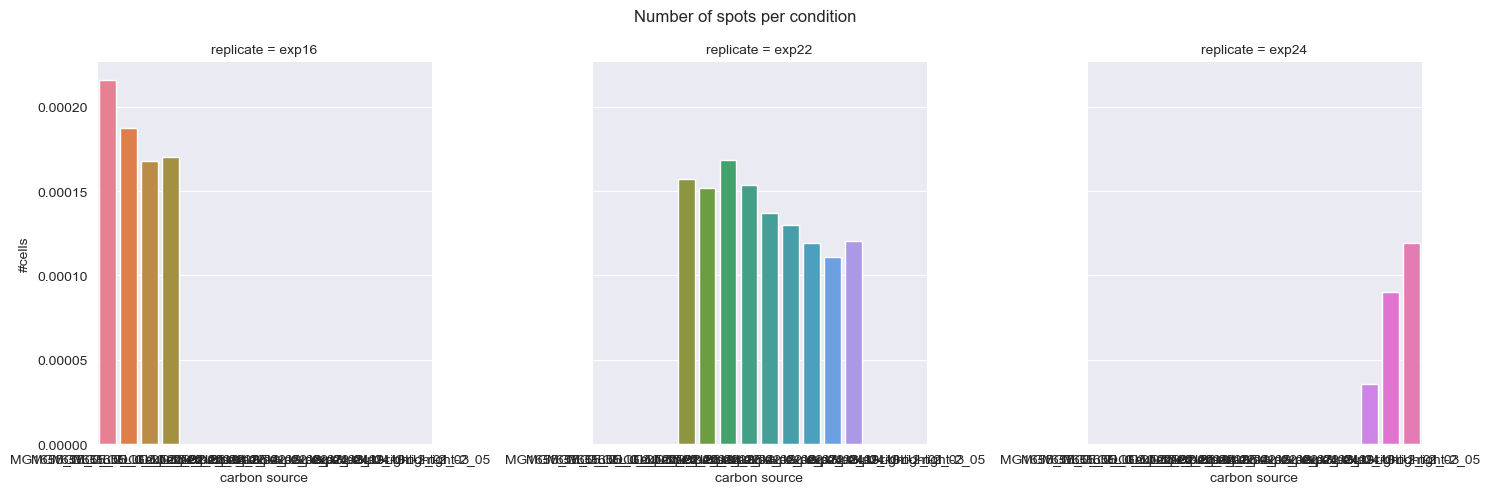

In [27]:
g = sns.catplot(pd.DataFrame(df_stacked.query('mrna == "rpoD"').query('csource == "GLU"').groupby(['strain', 'csource', 'replicate', 'image'])['RNAs_over_vol'].agg('mean')).reset_index(),
            col='replicate', col_order=replicates_ordered, 
            kind='bar', x='image', y='RNAs_over_vol', hue='image')
g.set(xlabel='carbon source', ylabel='#cells')
g.fig.suptitle('Number of spots per condition')
plt.tight_layout();

## Plots

### Cell feature distributions

#### Area per condition, all available data

##### Explo plot

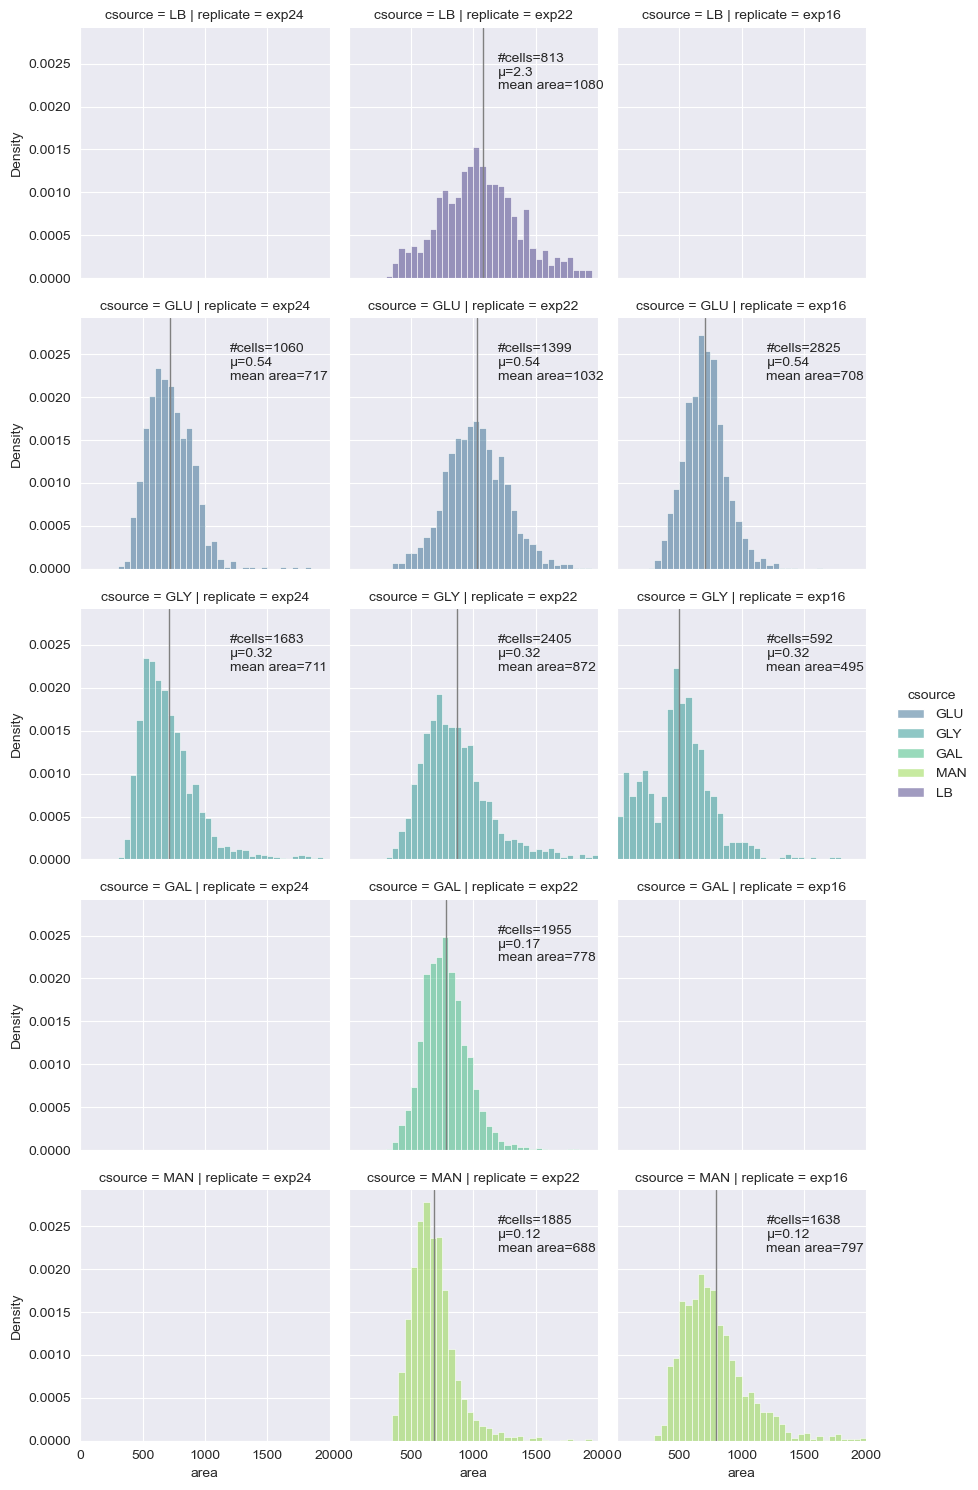

In [32]:
g = sns.displot(
    data=df_records, x='area', stat='density', binrange=(0, 2000), bins=40, common_norm=False,
    row='csource', row_order=csources_ordered, col='replicate', col_order=replicates, 
    hue='csource', palette=palette_csource, 
    legend=True, height=3,
    facet_kws=dict(sharey=True, sharex=True))
g.set(xlim=(0, 2000))

# this is pathetic but it works:
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax in axes:
    # extract the species name
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]
    replicate = re.search('replicate = (?P<replicate>exp[0-9]+)', title).groups()[0]
    # print(f'title: {title} csource: {csource} replicate: {replicate}')
    
    data = df_records.query('csource == @csource').query('replicate == @replicate')
    nr_cells = data.query('csource == @csource').shape[0]
    
    if data.empty is False: 
        mean = data['area'].mean()
        std = data['area'].std()
        mu = data.query('csource == @csource')['mu'].unique()[0]
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'#cells={nr_cells}\nµ={mu}\nmean area={mean:0.0f}', xy=(1200, 0.0022), xytext=(1200, 0.0022))

# this is the right way to do it but it doesn't work:
# for (row, col, hue_idx), data in g.facet_data():
#     # # Skip empty data
#     if not data.values.size:
#         continue
# 
#     # Get the ax for `row` and `col`
#     # ax = g.facet_axis(row, col)
#     
#     print(row, col, hue_idx, data.shape)
#     
#     # # Set the `vline`s using the var `x_var`
#     # ax.axvline(data['area'].mean(), c="k", ls="-", lw=2.5)
#     # ax.axvline(data['area'].median(), c="orange", ls="--", lw=2.5)

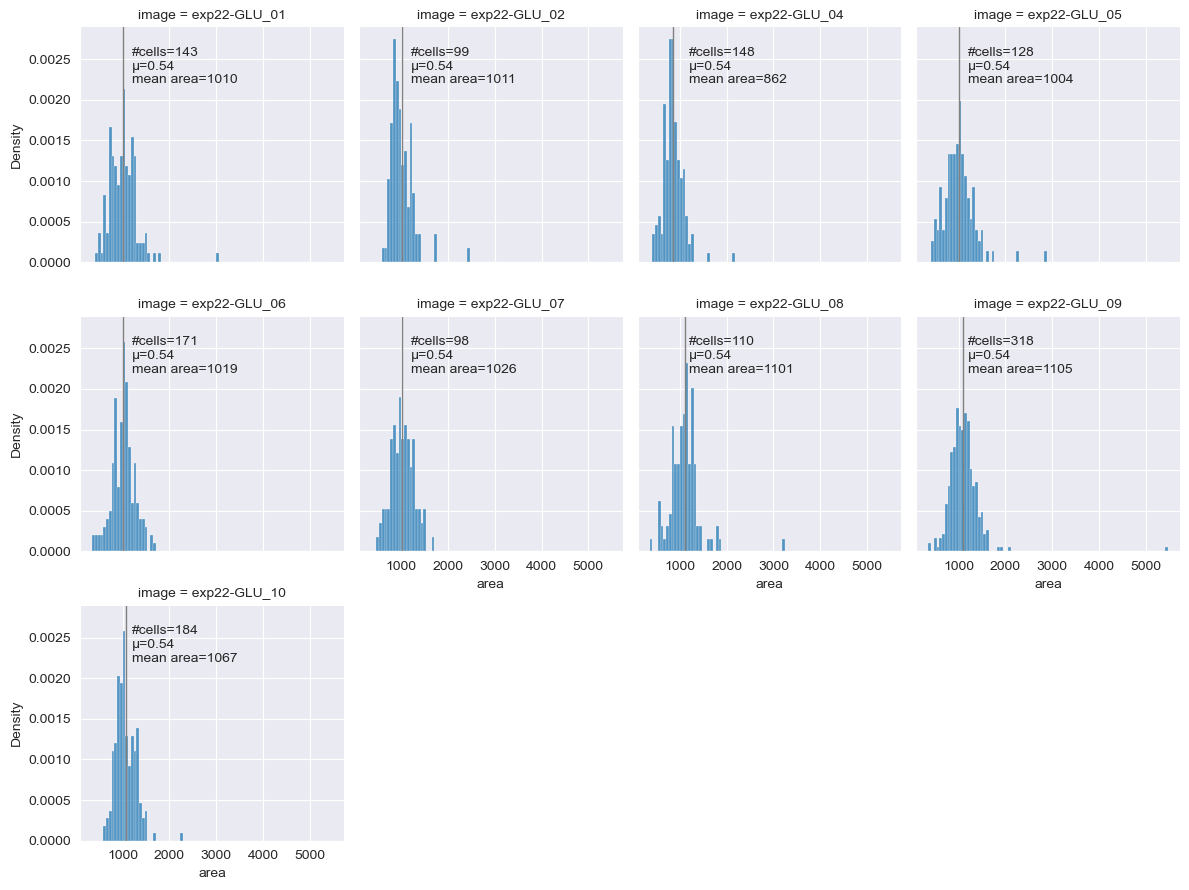

In [279]:
thisdata = df_records.query("csource in ['GLU']").query("replicate == 'exp22'")
images = thisdata['image'].unique()
g = sns.displot(
    data=thisdata, x='area', stat='density', common_norm=False,
    col='image', col_wrap=4,
    legend=True, height=3,
    facet_kws=dict(sharey=True, sharex=True))
# g.set(xlim=(0, 2000))

# this is pathetic but it works:
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax, image in zip(axes, images):
    data = thisdata.query('image == @image')
    nr_cells = data.shape[0]
    
    if data.empty is False: 
        mean = data['area'].mean()
        std = data['area'].std()
        mu = data['mu'].unique()[0]
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'#cells={nr_cells}\nµ={mu}\nmean area={mean:0.0f}', xy=(1200, 0.0022), xytext=(1200, 0.0022))


In [277]:
df_records.groupby(['strain', 'csource', 'replicate', 'seqnr'])['area'].mean()

strain  csource  replicate  seqnr
MG1655  GAL      exp22      03        783.02
                            04        768.69
                            07        768.56
                            08        781.77
        GLU      exp16      02        636.08
                            03        707.71
                            04        748.07
                            05        751.82
                 exp22      01       1010.24
                            02       1011.08
                            04        862.31
                            05       1003.92
                            06       1019.30
                            07       1026.38
                            08       1101.07
                            09       1104.69
                            10       1066.58
                 exp24      01        693.26
                            03        744.22
                            05        721.43
        GLY      exp16      01        771.69
                     

In [278]:
df_records.groupby(['strain', 'csource', 'replicate'])['area'].mean()

strain  csource  replicate
MG1655  GAL      exp22         777.60
        GLU      exp16         708.08
                 exp22        1032.33
                 exp24         716.58
        GLY      exp16         494.63
                 exp22         872.13
                 exp24         710.54
        LB       exp22        1079.59
        MAN      exp16         797.25
                 exp22         688.41
Name: area, dtype: float64

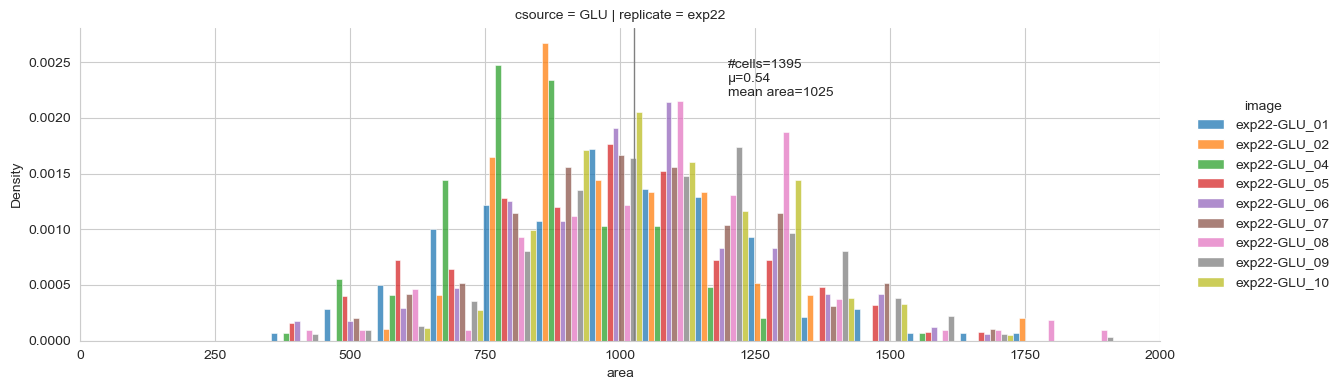

In [251]:
thisdata =  df_records.query("csource in ['GLU']").query("replicate == 'exp22'").query("area < 2500")

g = sns.displot(
    data=thisdata, x='area', stat='density', binwidth=100, common_norm=False,
    row='csource', col='replicate',
    hue='image', multiple="dodge",
    legend=True, height=4, aspect=3,
    facet_kws=dict(sharey=True, sharex=True))
g.set(xlim=(0, 2000))

# this is pathetic but it works:
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax in axes:
    # extract the species name
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]
    replicate = re.search('replicate = (?P<replicate>exp[0-9]+)', title).groups()[0]
    # print(f'title: {title} csource: {csource} replicate: {replicate}')
    
    data = thisdata.query('csource == @csource').query('replicate == @replicate')
    nr_cells = data.query('csource == @csource').shape[0]
    
    if data.empty is False: 
        mean = data['area'].mean()
        std = data['area'].std()
        mu = data.query('csource == @csource')['mu'].unique()[0]
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'#cells={nr_cells}\nµ={mu}\nmean area={mean:0.0f}', xy=(1200, 0.0022), xytext=(1200, 0.0022))

# this is the right way to do it but it doesn't work:
# for (row, col, hue_idx), data in g.facet_data():
#     # # Skip empty data
#     if not data.values.size:
#         continue
# 
#     # Get the ax for `row` and `col`
#     # ax = g.facet_axis(row, col)
#     
#     print(row, col, hue_idx, data.shape)
#     
#     # # Set the `vline`s using the var `x_var`
#     # ax.axvline(data['area'].mean(), c="k", ls="-", lw=2.5)
#     # ax.axvline(data['area'].median(), c="orange", ls="--", lw=2.5)

##### Inspect suspicious area values, fix segmentation manually

In [33]:
df_records.query('replicate == "exp16"').query('csource == "MAN"').sort_values(by='area', ascending=False)[['experiment', 'image', 'image_cell_id', 'area', 'volume', 'bbox-1', 'bbox-2']]

experiment                      image  image_cell_id    area  \
131  20240927-exp16  MG1655_MAN_OD_0.3_left_02            414  5219.0   
210  20240927-exp16  MG1655_MAN_OD_0.3_left_02            642  3258.0   
360  20240927-exp16  MG1655_MAN_OD_0.3_left_09           1178  2835.0   
240  20240927-exp16  MG1655_MAN_OD_0.3_left_02            699  2753.0   
307  20240927-exp16  MG1655_MAN_OD_0.3_left_02            905  2680.0   
..              ...                        ...            ...     ...   
69   20240927-exp16  MG1655_MAN_OD_0.3_left_07            514   346.0   
104  20240927-exp16  MG1655_MAN_OD_0.3_left_07            607   346.0   
98   20240927-exp16  MG1655_MAN_OD_0.3_left_09            565   346.0   
35   20240927-exp16  MG1655_MAN_OD_0.3_left_09            427   344.0   
194  20240927-exp16  MG1655_MAN_OD_0.3_left_07            933   340.0   

        volume  bbox-1  bbox-2  
131  378349.04    1760    1077  
210  137103.29     615    1588  
360  148848.44     477    1395  
240  106676.87    2217    1677  
307  112227.38    1973    2194  
..         ...     ...     ...  
69     4714.79     581     500  
104    4351.11     677     670  
98     4735.96    1687     367  
35     4212.68     797     133  
194    4413.74     528    1372  

[1638 rows x 7 columns]

#### Area and eccentricity versus condition

log(area) = f(mu)
In the following, we select exp22 because it is the most reliable, and the only complete, replicate.

In [34]:
df_records.groupby(['strain', 'csource', 'replicate'])['area'].agg(['mean', 'median', 'std'])

mean  median     std
strain csource replicate                         
MG1655 GAL     exp22       777.60   763.0  185.02
       GLU     exp16       708.08   700.0  171.61
               exp22      1032.33  1018.0  294.44
               exp24       716.58   700.0  176.18
       GLY     exp16       494.63   495.0  269.53
               exp22       872.13   815.0  325.20
               exp24       710.54   659.0  303.04
       LB      exp22      1079.59  1037.0  402.83
       MAN     exp16       797.25   735.0  331.01
               exp22       688.41   652.0  253.09

##### Demo plot


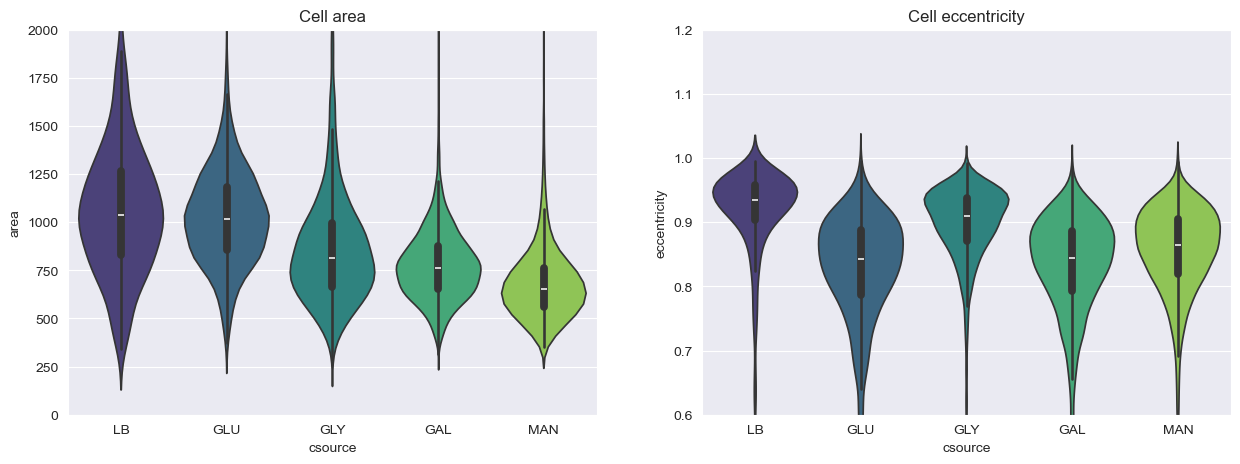

In [225]:
data = df_records.query('replicate == "exp22"')
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.violinplot(data, x='csource', y='area', order=csources_ordered, log_scale=False, hue='csource', palette=palette_csource, ax=ax[0]).set(ylim=(0, 2000))
ax[0].set_title('Cell area')
sns.violinplot(data, x='csource', y='eccentricity', order=csources_ordered, log_scale=False, hue='csource', palette=palette_csource, ax=ax[1])
ax[1].set_title('Cell eccentricity')
ax[1].set_ylim(0.6, 1.2)
savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/area_eccentricity_vs_condition"
plt.savefig(savestem + ".pdf")

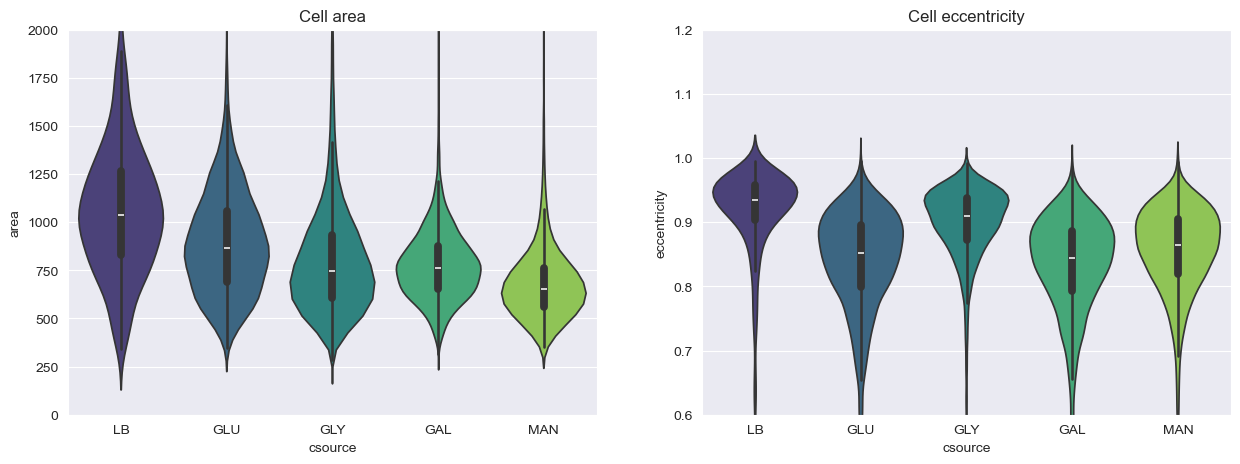

In [226]:
data = df_records.query('replicate != "exp16"')
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.violinplot(data, x='csource', y='area', order=csources_ordered, log_scale=False, hue='csource', palette=palette_csource, ax=ax[0]).set(ylim=(0, 2000))
ax[0].set_title('Cell area')
sns.violinplot(data, x='csource', y='eccentricity', order=csources_ordered, log_scale=False, hue='csource', palette=palette_csource, ax=ax[1])
ax[1].set_title('Cell eccentricity')
ax[1].set_ylim(0.6, 1.2)
savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/area_eccentricity_vs_condition"
plt.savefig(savestem + ".pdf")

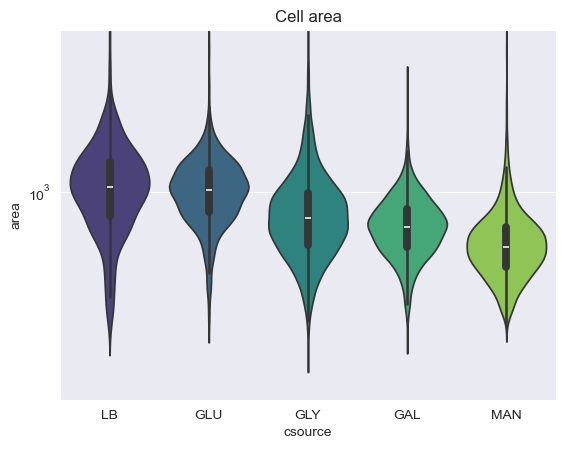

In [36]:
sns.violinplot(data, x='csource', y='area', order=csources_ordered, log_scale=True, hue='csource', palette=palette_csource)
plt.title('Cell area');
plt.ylim(200, 3500);
savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/area_vs_condition"
plt.savefig(savestem + ".pdf")

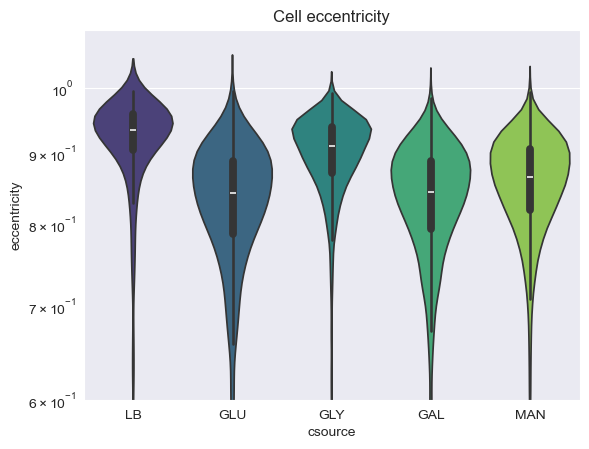

In [37]:
sns.violinplot(data, x='csource', y='eccentricity', order=csources_ordered, log_scale=True, hue='csource', palette=palette_csource)
plt.title('Cell eccentricity')
plt.ylim(0.6, 1.1);
savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/eccentricity_vs_condition"
plt.savefig(savestem + ".pdf")

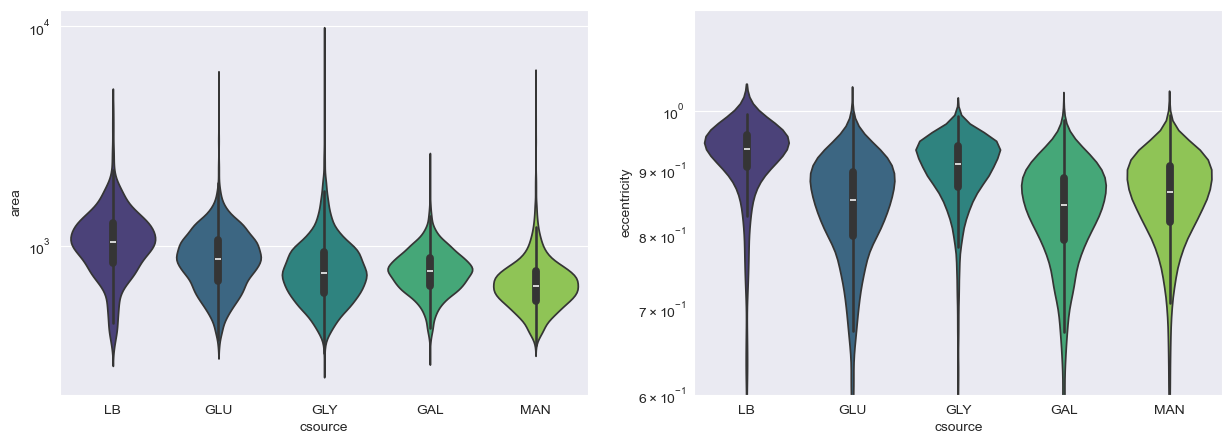

In [38]:
data = df_records.query('replicate != "exp16"')
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.violinplot(data, x='csource', y='area', order=csources_ordered, log_scale=True, hue='csource', palette=palette_csource, ax=ax[0])
sns.violinplot(data, x='csource', y='eccentricity', order=csources_ordered, log_scale=True, hue='csource', palette=palette_csource, ax=ax[1]);
ax[1].set_ylim(0.6, 1.2);

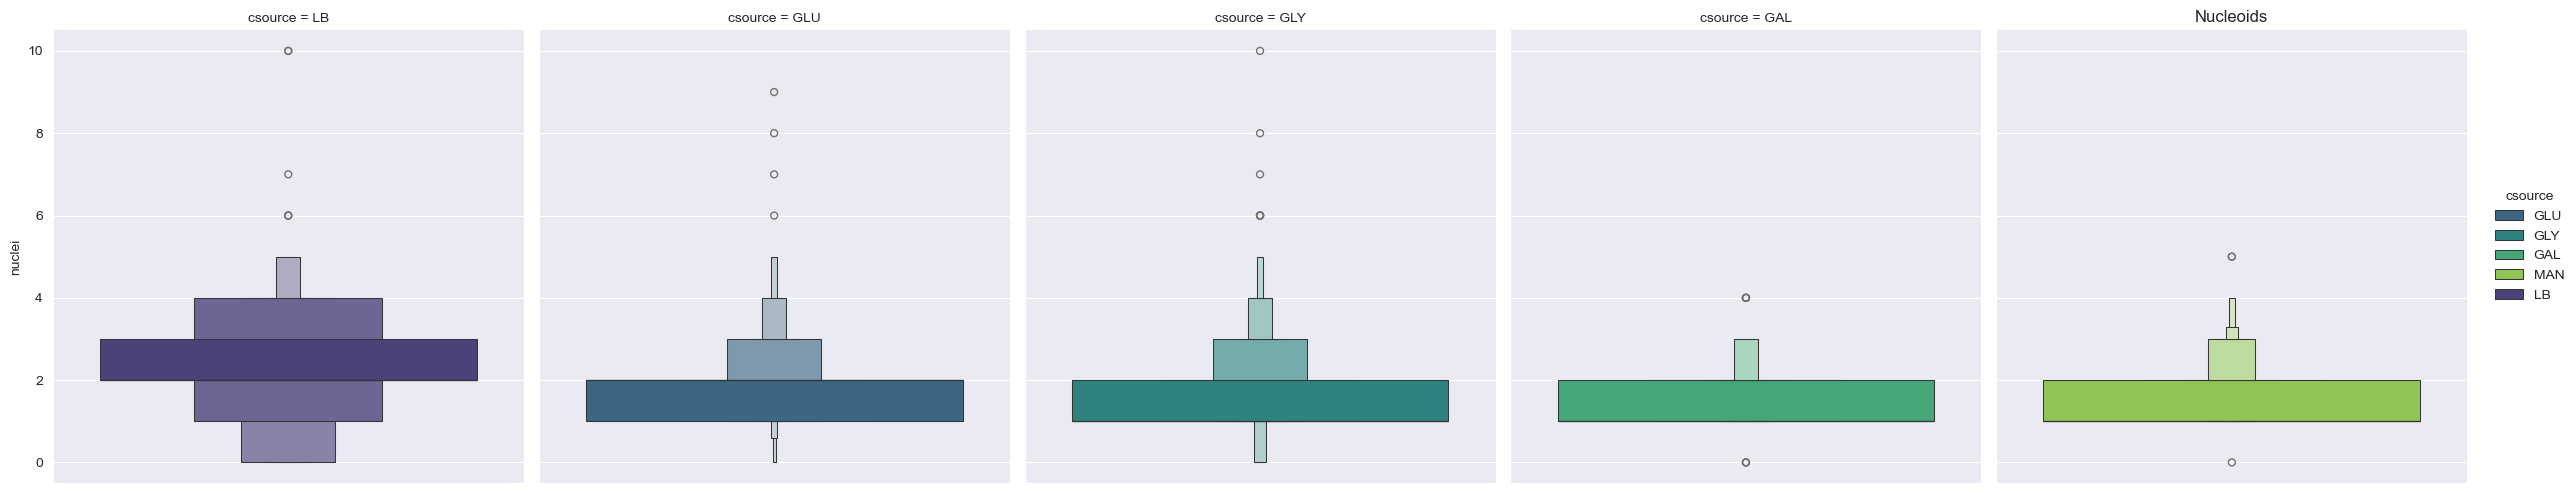

In [39]:
sns.catplot(data, kind='boxen', y='nuclei', col='csource', col_order=csources_ordered, hue='csource', palette=palette_csource)
plt.title('Nucleoids')
savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/nuclei"
plt.savefig(savestem + ".pdf")

#### Area per condition

##### Demo plot

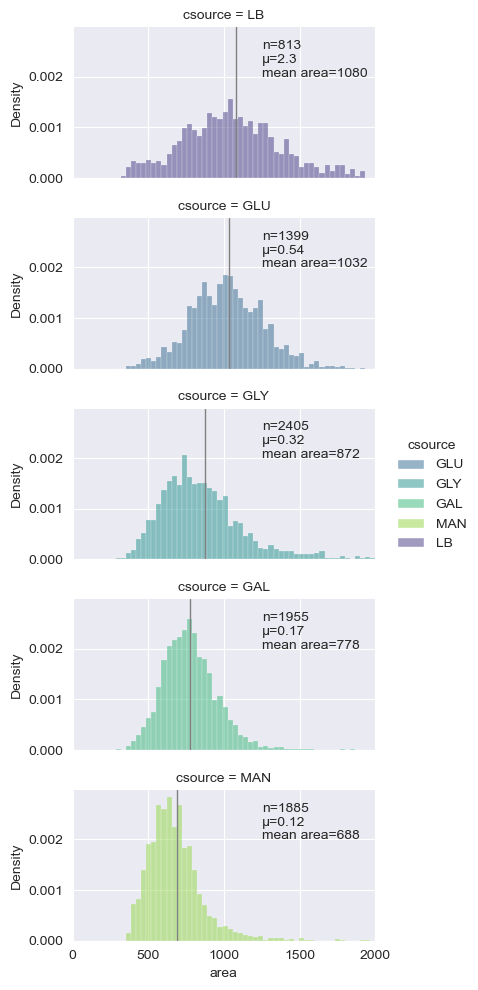

In [40]:
data = df_records.query('replicate == "exp22"')
g = sns.displot(
    data=data, x='area', stat='density', common_norm=False,
    row='csource', row_order=csources_ordered, 
    hue='csource', palette=palette_csource, 
    legend=True, height=2, aspect=2,
    facet_kws=dict(sharey=True, sharex=True))
g.set(xlim=(0, 2000))

axes = g.axes.flatten()
for ax in axes:
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]
    mean = data.query('csource == @csource')['area'].mean()
    std = data.query('csource == @csource')['area'].std()
    mu = data.query('csource == @csource')['mu'].unique()[0]
    nr_cells = data.query('csource == @csource').shape[0]
    
    if data.empty is False: 
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'n={nr_cells}\nµ={mu}\nmean area={mean:0.0f}', xy=(1250, 0.002), xytext=(1250, 0.002))

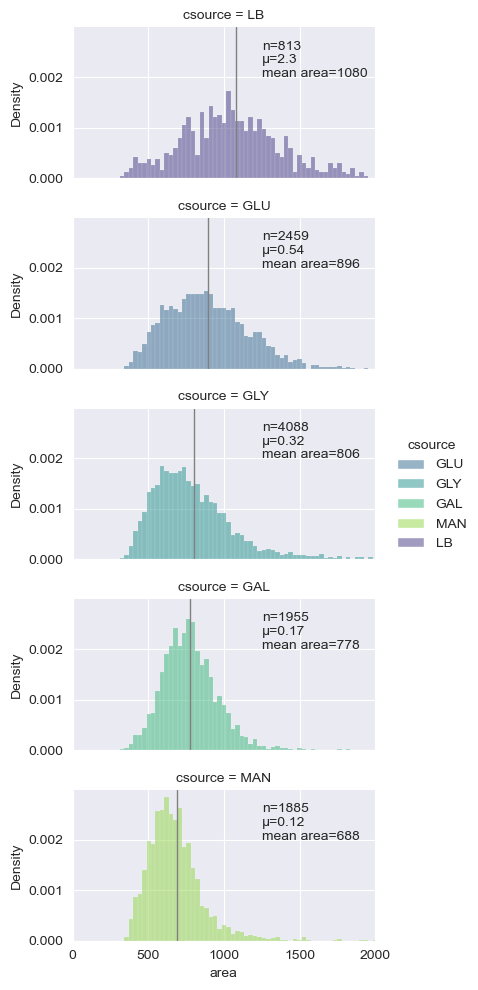

In [41]:
data = df_records.query('replicate != "exp16"')
g = sns.displot(
    data=data, x='area', stat='density', common_norm=False,
    row='csource', row_order=csources_ordered, 
    hue='csource', palette=palette_csource, 
    legend=True, height=2, aspect=2,
    facet_kws=dict(sharey=True, sharex=True))
g.set(xlim=(0, 2000))

axes = g.axes.flatten()
for ax in axes:
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]
    mean = data.query('csource == @csource')['area'].mean()
    std = data.query('csource == @csource')['area'].std()
    mu = data.query('csource == @csource')['mu'].unique()[0]
    nr_cells = data.query('csource == @csource').shape[0]
    
    if data.empty is False: 
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'n={nr_cells}\nµ={mu}\nmean area={mean:0.0f}', xy=(1250, 0.002), xytext=(1250, 0.002))

#### Eccentricity per condition

##### Demo plot

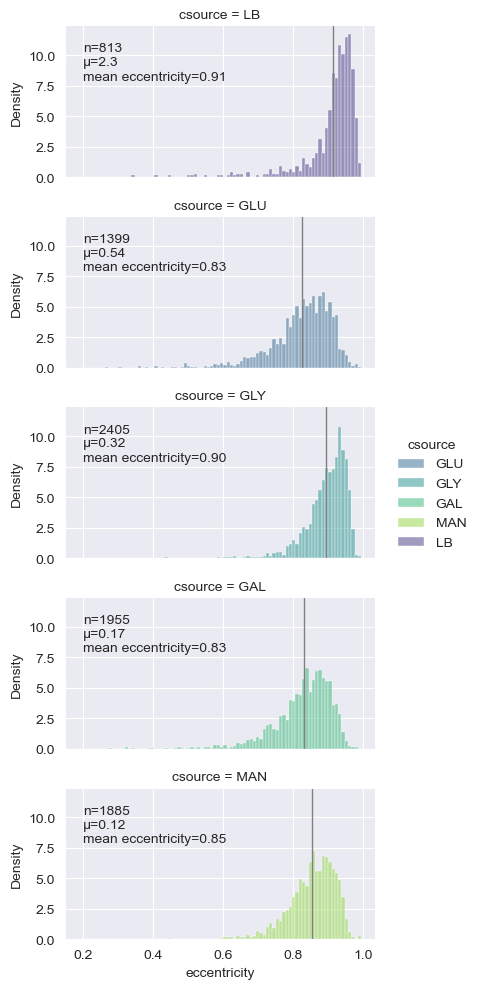

In [42]:
data = df_records.query('replicate == "exp22"')
g = sns.displot(
    data=data, x='eccentricity', stat='density', common_norm=False,
    row='csource', row_order=csources_ordered, 
    hue='csource', palette=palette_csource, 
    legend=True, height=2, aspect=2,
    facet_kws=dict(sharey=True, sharex=True))

axes = g.axes.flatten()
for ax in axes:
    # extract the species name
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]

    mean = data.query('csource == @csource')['eccentricity'].mean()
    std = data.query('csource == @csource')['eccentricity'].std()
    mu = data.query('csource == @csource')['mu'].unique()[0]
    nr_cells = data.query('csource == @csource').shape[0]

    if data.empty is False: 
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'n={nr_cells}\nµ={mu}\nmean eccentricity={mean:0.2f}', xy=(0.2, 8), xytext=(0.2, 8))

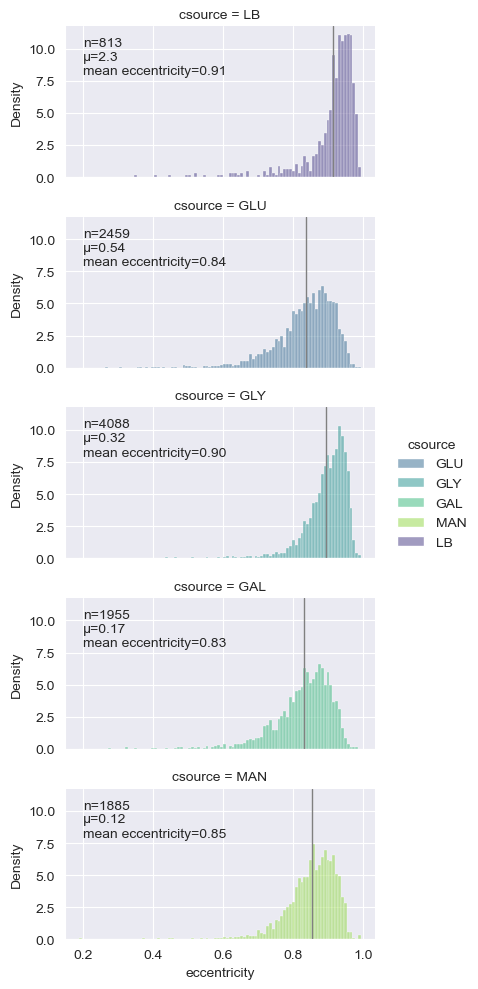

In [43]:
data = df_records.query('replicate != "exp16"')
g = sns.displot(
    data=data, x='eccentricity', stat='density', common_norm=False,
    row='csource', row_order=csources_ordered, 
    hue='csource', palette=palette_csource, 
    legend=True, height=2, aspect=2,
    facet_kws=dict(sharey=True, sharex=True))

axes = g.axes.flatten()
for ax in axes:
    # extract the species name
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]

    mean = data.query('csource == @csource')['eccentricity'].mean()
    std = data.query('csource == @csource')['eccentricity'].std()
    mu = data.query('csource == @csource')['mu'].unique()[0]
    nr_cells = data.query('csource == @csource').shape[0]

    if data.empty is False: 
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'n={nr_cells}\nµ={mu}\nmean eccentricity={mean:0.2f}', xy=(0.2, 8), xytext=(0.2, 8))

### Expression versus growth rate

#### Mean number of spots/cell per image
This is just to check how consistent the data is across images.

##### QC plot

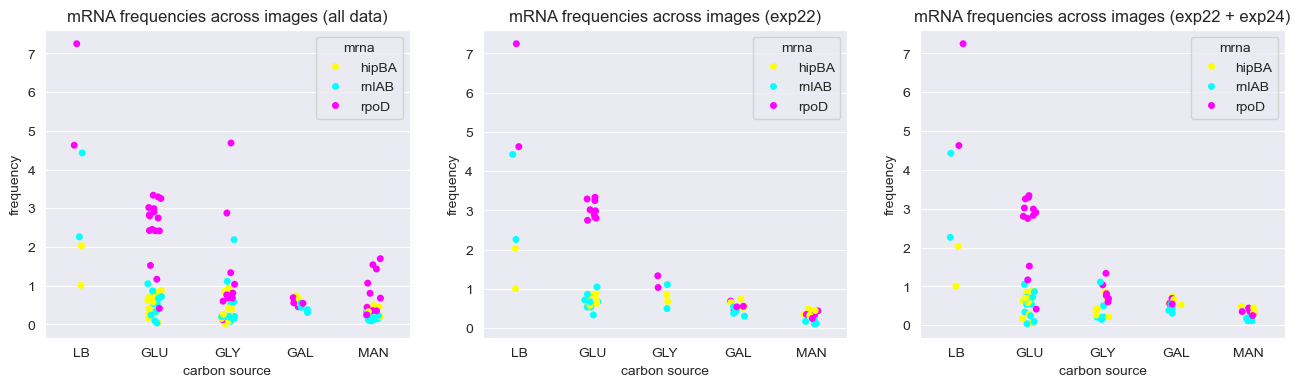

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.stripplot(frequencies, x='csource', order=csources_ordered, y='frequencies', hue='mrna', palette=palette_mrna, ax=ax[0])
ax[0].set(title='mRNA frequencies across images (all data)', xlabel='carbon source', ylabel='frequency')
sns.stripplot(frequencies.query("replicate == 'exp22'"), x='csource', order=csources_ordered, y='frequencies', hue='mrna', palette=palette_mrna, ax=ax[1])
ax[1].set(title='mRNA frequencies across images (exp22)', xlabel='carbon source', ylabel='frequency')
sns.stripplot(frequencies.query("replicate != 'exp16'"), x='csource', order=csources_ordered, y='frequencies', hue='mrna', palette=palette_mrna, ax=ax[2])
ax[2].set(title='mRNA frequencies across images (exp22 + exp24)', xlabel='carbon source', ylabel='frequency');
# numbers need to be consistent across images within one condition

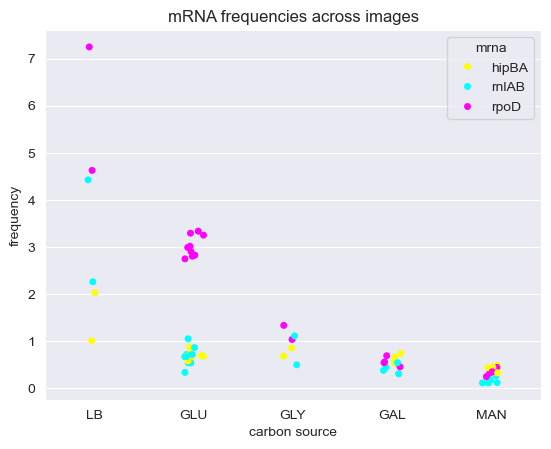

In [45]:
g = sns.stripplot(frequencies.query("replicate == 'exp22'"), x='csource', order=csources_ordered, y='frequencies', hue='mrna', palette=palette_mrna)
g.set(title='mRNA frequencies across images', xlabel='carbon source', ylabel='frequency')

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/QC/mean_expression_per_image_vs_condition"
plt.savefig(savestem + ".pdf")
# numbers need to be consistent across images within one condition

#### Mean expression per condition

##### Demo plot

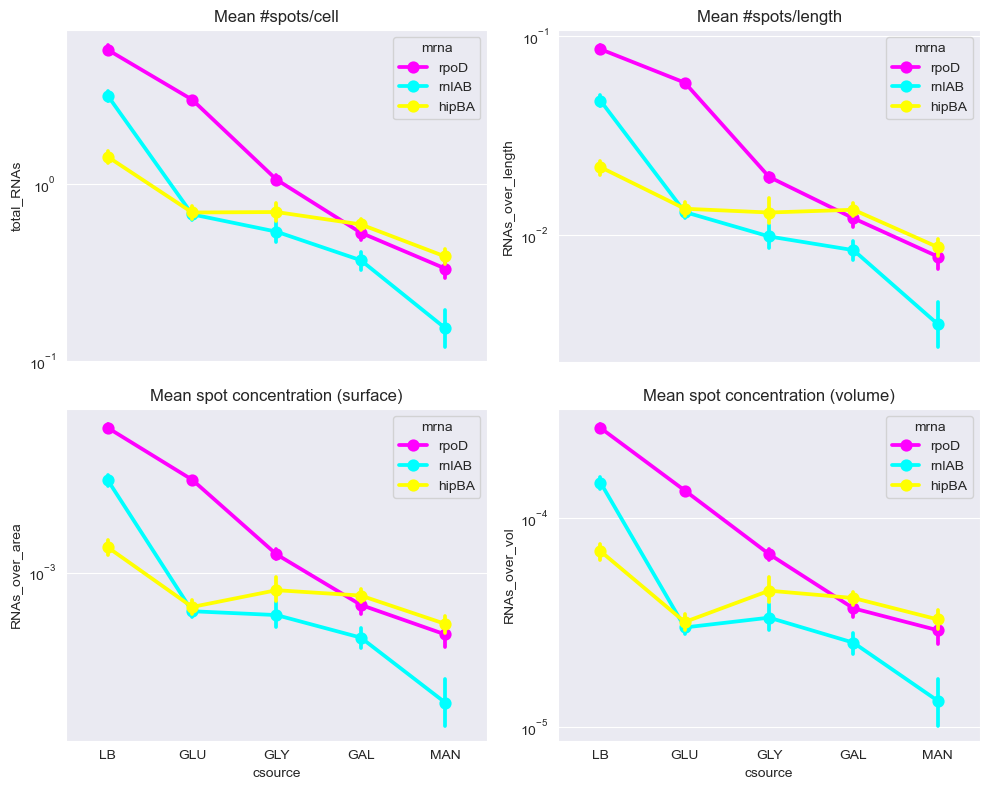

In [47]:
# sns.set_style("whitegrid", {"axes.facecolor": "xkcd:cadet blue", "grid.color": "xkcd:dark grey", "text.color": "black", "legend.facecolor": "white"})
sns.set_style("darkgrid")
data=df_stacked.query('replicate == "exp22"')

fig, ax = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
g = sns.pointplot(data=data, x='csource', order=csources_ordered, y='total_RNAs', 
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][0])
g.set(title='Mean #spots/cell')
g.set(yscale="log")

g = sns.pointplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_length', 
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][1])
g.set(title='Mean #spots/length')
g.set(yscale="log")

g = sns.pointplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_area', 
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][0])
g.set(title='Mean spot concentration (surface)')
g.set(yscale="log")

g = sns.pointplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_vol', 
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][1])
g.set(title='Mean spot concentration (volume)');
g.set(yscale="log");

plt.tight_layout()


savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_exp22"
plt.savefig(savestem + ".pdf")

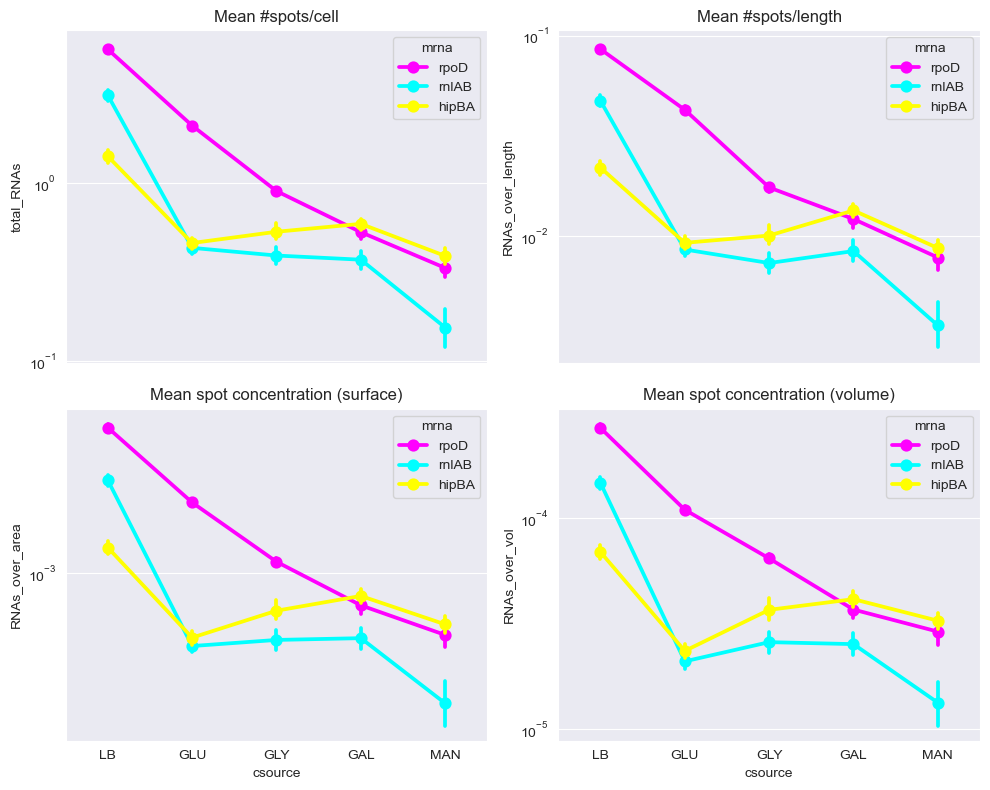

In [220]:
sns.set_style("darkgrid")
data=df_stacked.query('replicate != "exp16"')

fig, ax = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
g = sns.pointplot(data=data, x='csource', order=csources_ordered, y='total_RNAs',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][0])
g.set(title='Mean #spots/cell')
g.set(yscale="log")

g = sns.pointplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_length',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][1])
g.set(title='Mean #spots/length')
g.set(yscale="log")

g = sns.pointplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_area',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][0])
g.set(title='Mean spot concentration (surface)')
g.set(yscale="log")

g = sns.pointplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_vol',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][1])
g.set(title='Mean spot concentration (volume)');
g.set(yscale="log");

plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_exp22+24")
plt.savefig(savestem + ".pdf")

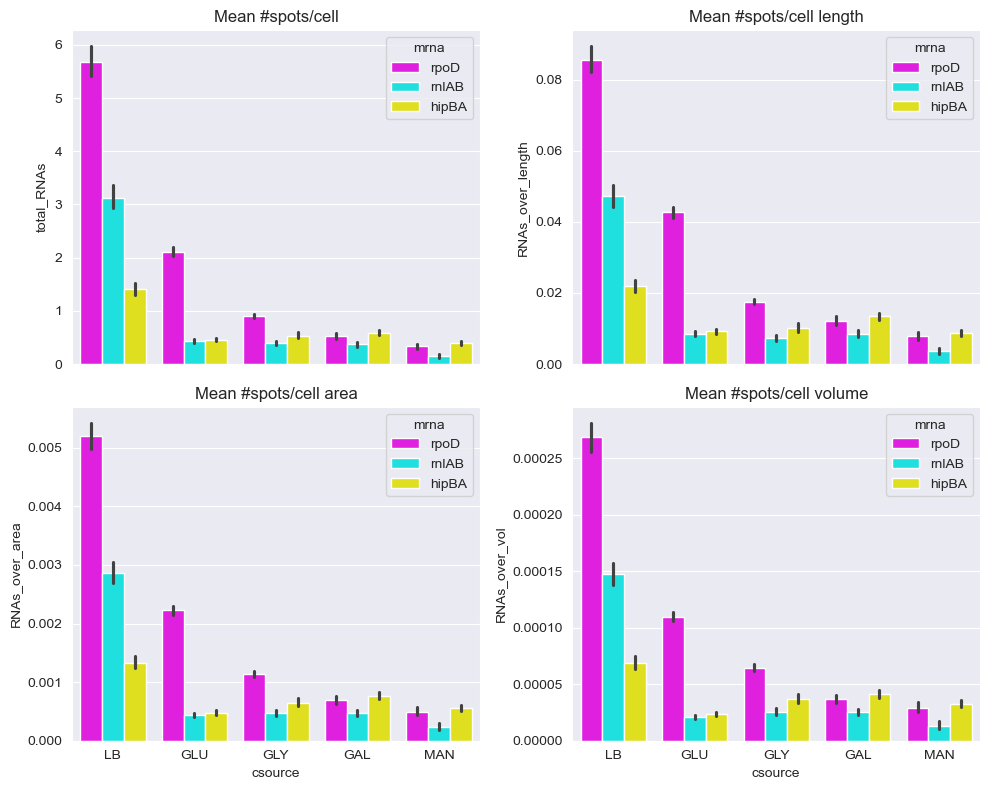

In [227]:
sns.set_style("darkgrid")
data=df_stacked.query('replicate != "exp16"')

fig, ax = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
g = sns.barplot(data=data, x='csource', order=csources_ordered, y='total_RNAs',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][0])
g.set(title='Mean #spots/cell')
# g.set(yscale="log")

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_length',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][1])
g.set(title='Mean #spots/cell length')
# g.set(yscale="log")

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_area',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][0])
g.set(title='Mean #spots/cell area')
# g.set(yscale="log")

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_vol',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][1])
g.set(title='Mean #spots/cell volume');
# g.set(yscale="log");

plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_exp22+24")
plt.savefig(savestem + ".pdf")
# ? expected #mRNAs /cell
# mean number is growth dependent
# normalize by nr copies of genome and distance from oriC


#### Noise and Fano factor 
as per Taniguchi 2010, except:
- "Because the same probe is used for all strains, the optimized hybridization efficiency is unbiased for every measured gene"
is not true for us.
- also not: "We excluded gene dosage effects by gating with the cell size to select the cells that have not yet gone through chromosome replication"
- 

##### Per replicate

In [195]:
rep_mrna_counts = df_stacked.groupby(['strain', 'csource', 'replicate', 'mrna'])['total_RNAs'].sum()
rep_cell_counts = df_stacked.groupby(['strain', 'csource', 'replicate', 'mrna']).size()
rep_frequencies_series = rep_mrna_counts / rep_cell_counts
rep_frequencies_series.name = "mean"
rep_frequencies = pd.DataFrame(rep_frequencies_series).reset_index()
rep_mrna_stds = pd.DataFrame(df_stacked.groupby(['strain', 'csource', 'replicate', 'mrna'])['total_RNAs'].std()).reset_index()
rep_mrna_stds.rename(columns={'total_RNAs': 'std'}, inplace=True)
rep_frequencies = rep_frequencies.merge(rep_mrna_stds, on=['strain', 'csource', 'replicate', 'mrna'])
rep_frequencies['noise'] = np.square(rep_frequencies['std'] / rep_frequencies['mean'])
rep_frequencies['fano'] = np.square(rep_frequencies['std']) / rep_frequencies['mean']
rep_frequencies

strain csource replicate   mrna  mean   std  noise  fano
0   MG1655     GAL     exp22  hipBA  0.59  0.95   2.62  1.54
1   MG1655     GAL     exp22  rnlAB  0.37  0.97   6.86  2.54
2   MG1655     GAL     exp22   rpoD  0.53  1.15   4.68  2.48
3   MG1655     GLU     exp16  hipBA  0.37  0.89   5.91  2.16
4   MG1655     GLU     exp16  rnlAB  0.75  1.04   1.94  1.45
5   MG1655     GLU     exp16   rpoD  2.43  1.52   0.39  0.95
6   MG1655     GLU     exp22  hipBA  0.69  1.04   2.26  1.56
7   MG1655     GLU     exp22  rnlAB  0.67  0.96   2.06  1.38
8   MG1655     GLU     exp22   rpoD  2.98  2.12   0.51  1.51
9   MG1655     GLU     exp24  hipBA  0.16  0.48   9.22  1.46
10  MG1655     GLU     exp24  rnlAB  0.12  0.39  11.69  1.35
11  MG1655     GLU     exp24   rpoD  0.97  1.21   1.58  1.52
12  MG1655     GLY     exp16  hipBA  0.11  0.46  18.11  1.96
13  MG1655     GLY     exp16  rnlAB  0.21  0.84  16.69  3.44
14  MG1655     GLY     exp16   rpoD  0.66  1.73   6.90  4.54
15  MG1655     GLY     exp22  hipBA  0.69  2.23  10.37  7.19
16  MG1655     GLY     exp22  rnlAB  0.54  1.69   9.92  5.33
17  MG1655     GLY     exp22   rpoD  1.06  1.44   1.86  1.96
18  MG1655     GLY     exp24  hipBA  0.30  1.11  13.28  4.03
19  MG1655     GLY     exp24  rnlAB  0.18  0.81  19.66  3.60
20  MG1655     GLY     exp24   rpoD  0.69  1.03   2.27  1.55
21  MG1655      LB     exp22  hipBA  1.42  1.69   1.41  2.00
22  MG1655      LB     exp22  rnlAB  3.13  3.06   0.96  3.00
23  MG1655      LB     exp22   rpoD  5.68  4.25   0.56  3.18
24  MG1655     MAN     exp16  hipBA  0.22  0.59   7.22  1.59
25  MG1655     MAN     exp16  rnlAB  0.23  0.62   7.08  1.65
26  MG1655     MAN     exp16   rpoD  1.16  1.91   2.70  3.14
27  MG1655     MAN     exp22  hipBA  0.39  0.86   4.85  1.89
28  MG1655     MAN     exp22  rnlAB  0.15  0.87  31.88  4.90
29  MG1655     MAN     exp22   rpoD  0.33  0.94   7.90  2.63

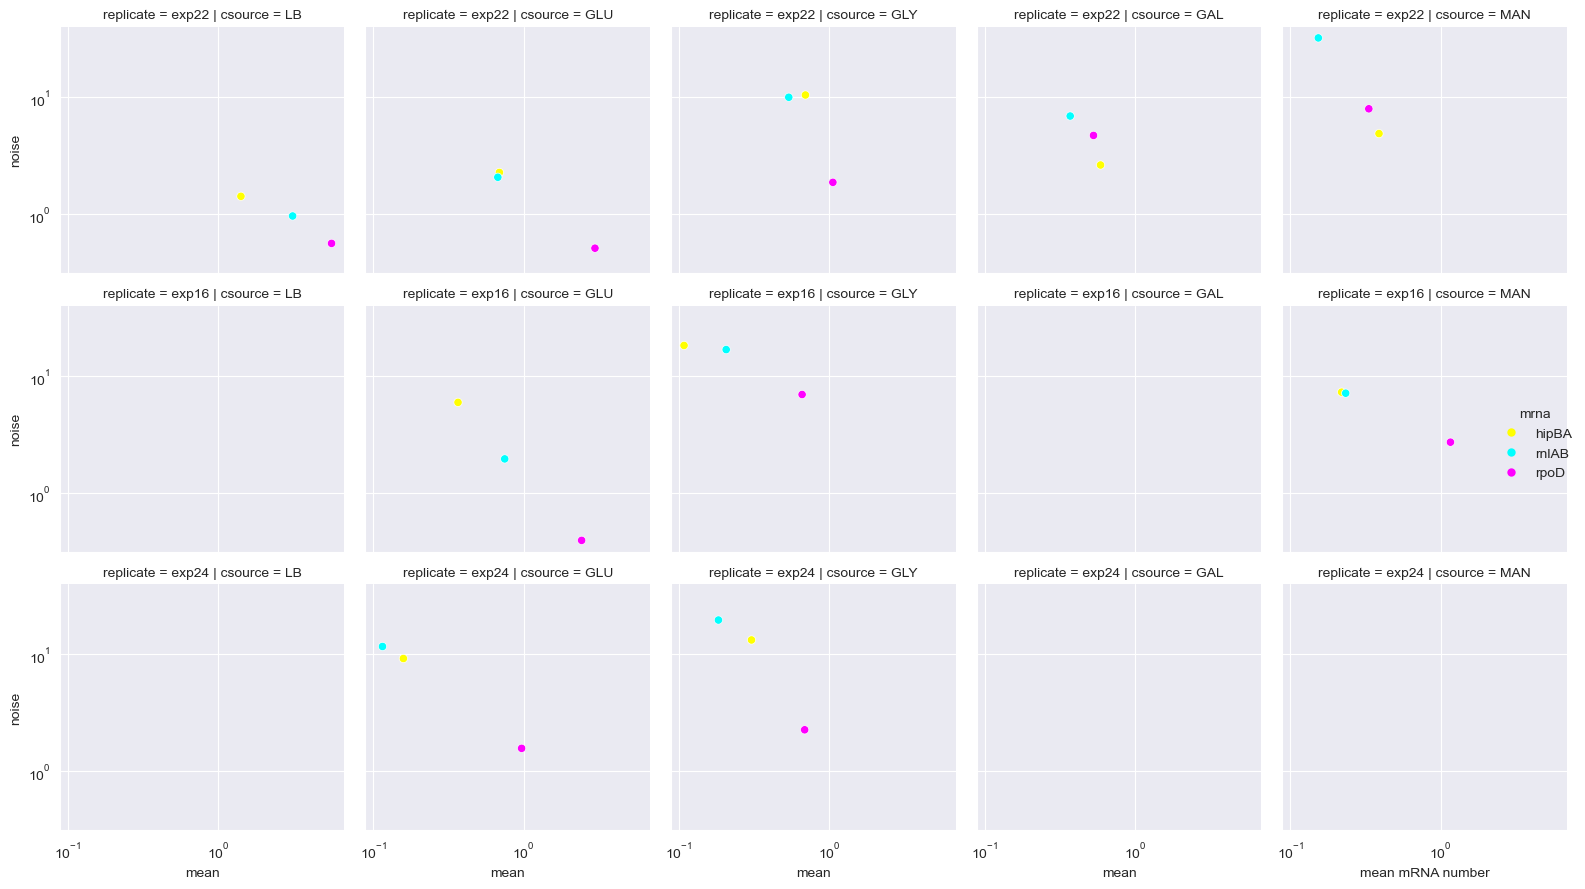

In [205]:
sns.relplot(rep_frequencies, x='mean', y='noise', 
            col='csource', col_order=csources_ordered, 
            row='replicate', 
            hue='mrna', palette=palette_mrna,
            height=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mean mRNA number')
plt.ylabel('mRNA noise')
plt.tight_layout();

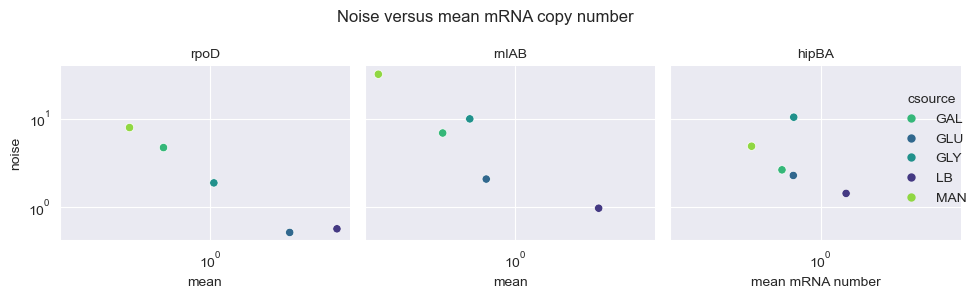

In [216]:
g = sns.relplot(rep_frequencies.query('replicate == "exp22"'), x='mean', y='noise', 
            col='mrna', col_order=mrna_ordered, 
            row='replicate', 
            hue='csource', palette=palette_csource,
            height=3)
g.set_titles('{col_name}');
g.fig.suptitle("Noise versus mean mRNA copy number")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mean mRNA number')
plt.ylabel('mRNA noise')
plt.tight_layout();

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/noise_vs_mean_expression-exp22"
plt.savefig(savestem + ".pdf")

##### Per image

In [197]:
mrna_counts = df_stacked.groupby(['strain', 'csource', 'replicate', 'seqnr', 'mrna'])['total_RNAs'].sum()  # Number of spots per csource per image per channel
cell_counts = df_stacked.groupby(['strain', 'csource', 'replicate', 'seqnr', 'mrna']).size() # Number of cells per csource per image exploded per channel
frequencies_series = mrna_counts / cell_counts # mean number of spots per image per channel
frequencies_series.name = "mean"
frequencies = pd.DataFrame(frequencies_series).reset_index()
mrna_stds = pd.DataFrame(df_stacked.groupby(['strain', 'csource', 'replicate', 'seqnr', 'mrna'])['total_RNAs'].std()).reset_index() # Standard deviation of number of spots per csource per image per channel
mrna_stds.rename(columns={'total_RNAs': 'std'}, inplace=True)
frequencies = frequencies.merge(mrna_stds, on=['strain', 'csource', 'replicate', 'mrna', 'seqnr'])
frequencies['noise'] = np.square(frequencies['std'] / frequencies['mean']) # noise
frequencies['fano'] = np.square(frequencies['std']) / frequencies['mean'] # Fano factor

frequencies

strain csource replicate seqnr   mrna  mean   std  noise  fano
0    MG1655     GAL     exp22    03  hipBA  0.52  0.86   2.68  1.40
1    MG1655     GAL     exp22    03  rnlAB  0.31  0.98  10.25  3.15
2    MG1655     GAL     exp22    03   rpoD  0.46  0.93   4.19  1.91
3    MG1655     GAL     exp22    04  hipBA  0.74  1.10   2.21  1.64
4    MG1655     GAL     exp22    04  rnlAB  0.44  1.01   5.28  2.32
..      ...     ...       ...   ...    ...   ...   ...    ...   ...
127  MG1655     MAN     exp22    05  rnlAB  0.11  0.48  17.49  2.00
128  MG1655     MAN     exp22    05   rpoD  0.35  0.62   3.15  1.10
129  MG1655     MAN     exp22    06  hipBA  0.33  1.00   9.23  3.02
130  MG1655     MAN     exp22    06  rnlAB  0.11  0.58  26.48  3.00
131  MG1655     MAN     exp22    06   rpoD  0.25  0.55   4.96  1.23

[132 rows x 9 columns]

In [218]:
frequencies.query('replicate == "exp22"').query('csource == "GLY"')

strain csource replicate seqnr   mrna  mean   std  noise  fano
75  MG1655     GLY     exp22    09  hipBA  0.68  2.28  11.17  7.62
76  MG1655     GLY     exp22    09  rnlAB  0.50  1.51   9.21  4.59
77  MG1655     GLY     exp22    09   rpoD  1.04  1.39   1.81  1.88
78  MG1655     GLY     exp22    10  hipBA  0.86  1.32   2.38  2.04
79  MG1655     GLY     exp22    10  rnlAB  1.11  3.33   8.98  9.99
80  MG1655     GLY     exp22    10   rpoD  1.34  1.97   2.18  2.92

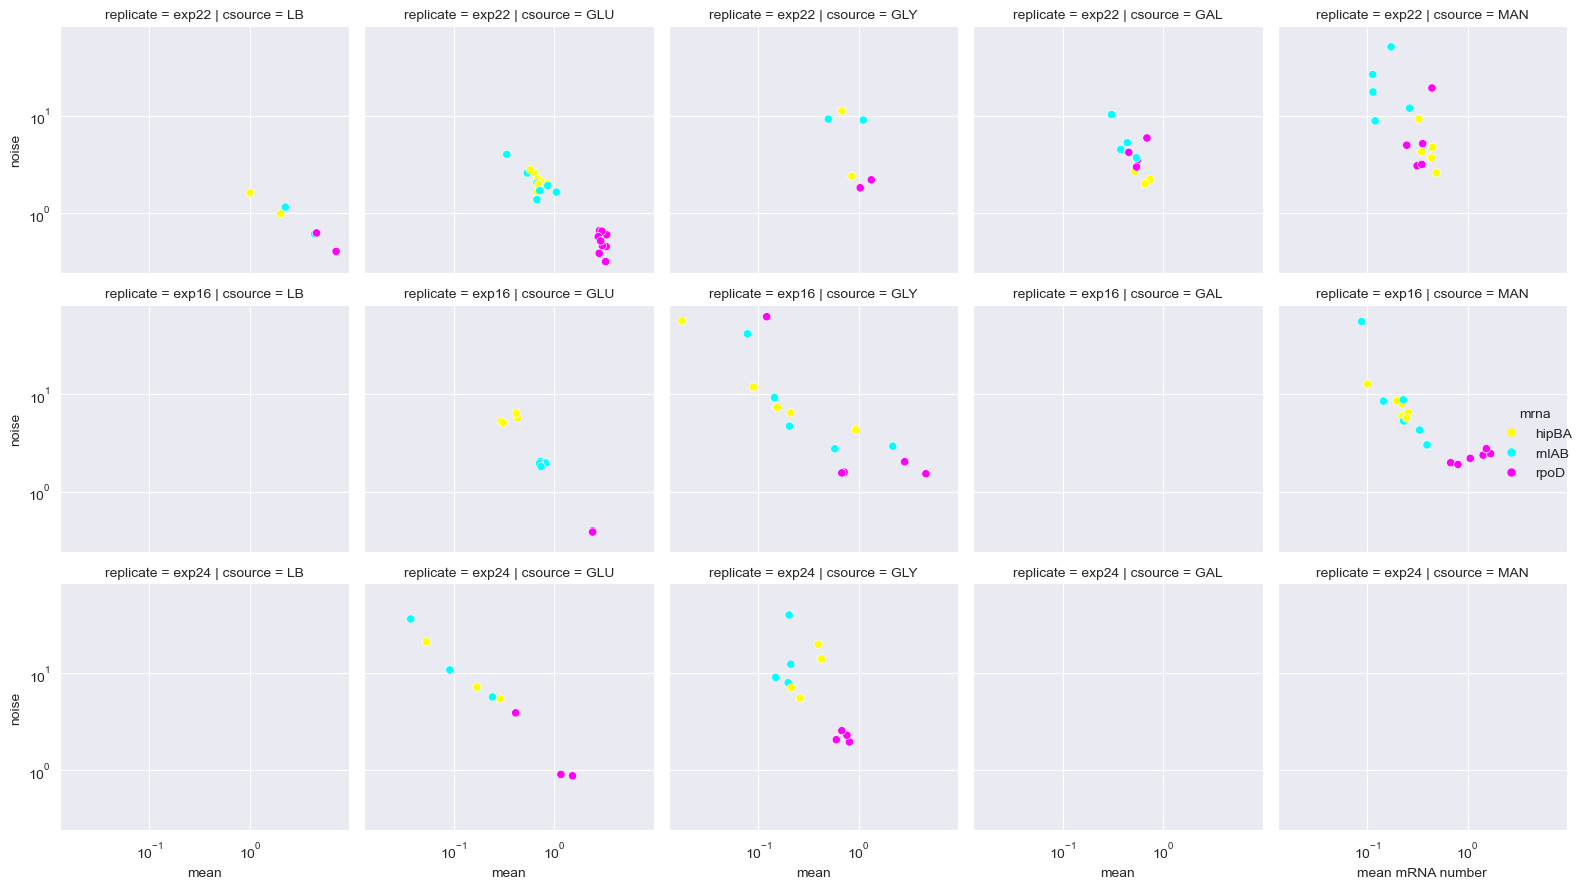

In [203]:
sns.relplot(frequencies, x='mean', y='noise', 
            col='csource', col_order=csources_ordered, 
            row='replicate', 
            hue='mrna', palette=palette_mrna,
            height=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mean mRNA number')
plt.ylabel('mRNA noise')
plt.tight_layout();




#### Distribution facetted by csource and mRNA

Cell expression histograms per csource per mRNA = 
#spots/cell for csource, aggregated over all images for csource
[TODO] add the mean


##### Explo plot - all data

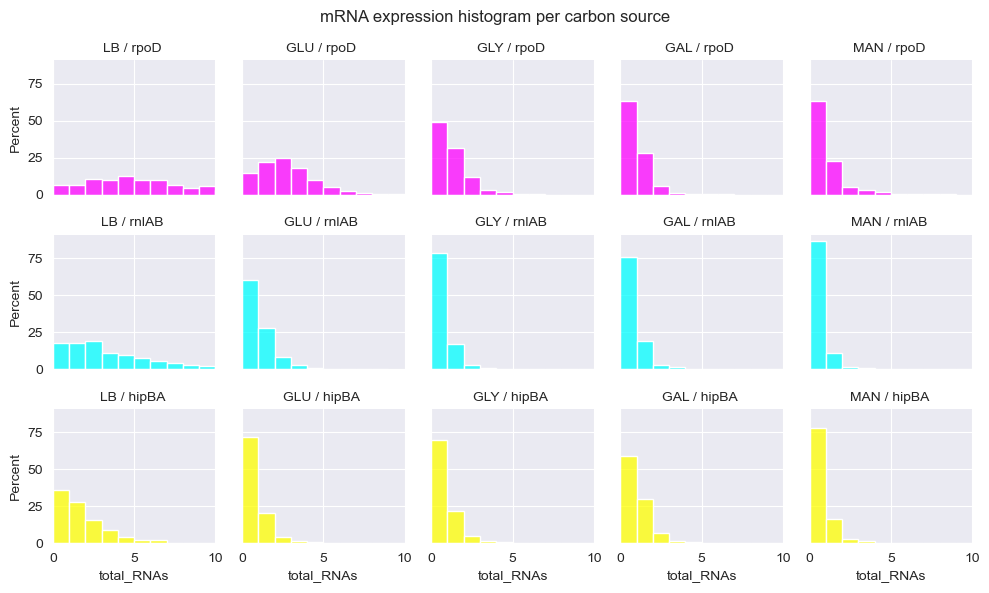

In [50]:
sns.set_style({"grid": False})
g = sns.FacetGrid(df_stacked, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered,
                  xlim=(0, 10), sharex=True, sharey=True, hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='total_RNAs', binwidth=1, stat='percent')
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression histogram per carbon source')
g.tight_layout();

##### Demo plot - only exp22 data

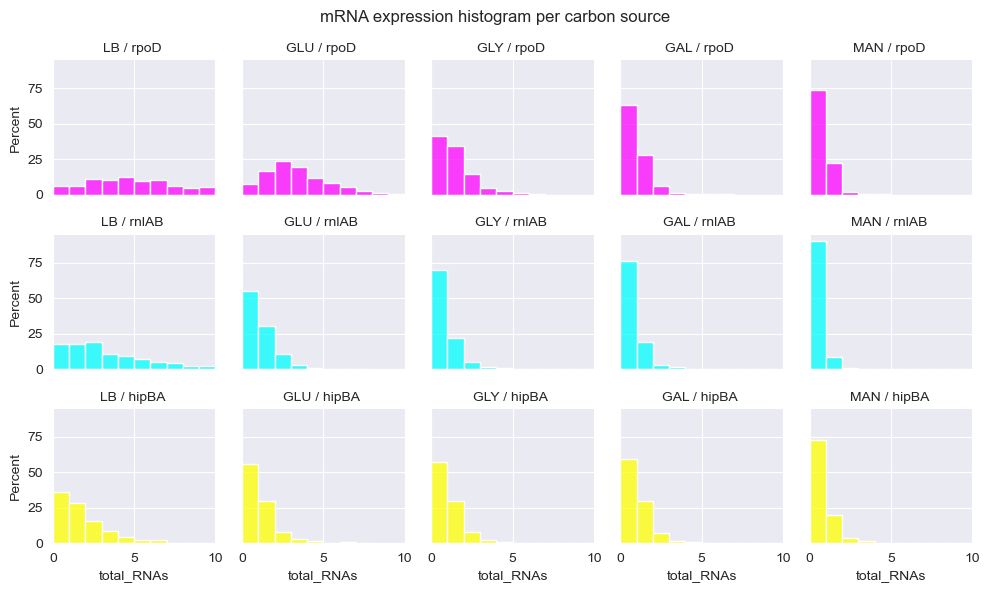

In [51]:
sns.set_style("darkgrid")
# sns.set_style("whitegrid", {"axes.facecolor": "xkcd:darkblue", "grid.color": "xkcd:aubergine", "text.color": "black", "legend.facecolor": "white"})

data = df_stacked.query('replicate == "exp22"')
g = sns.FacetGrid(data, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 10), sharex=True, sharey=True, hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='total_RNAs', binwidth=1, stat='percent')
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression histogram per carbon source')
g.tight_layout();

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/distribution_expression_vs_condition"
plt.savefig(savestem + ".pdf")

##### Demo plot - exp22 + exp24 data

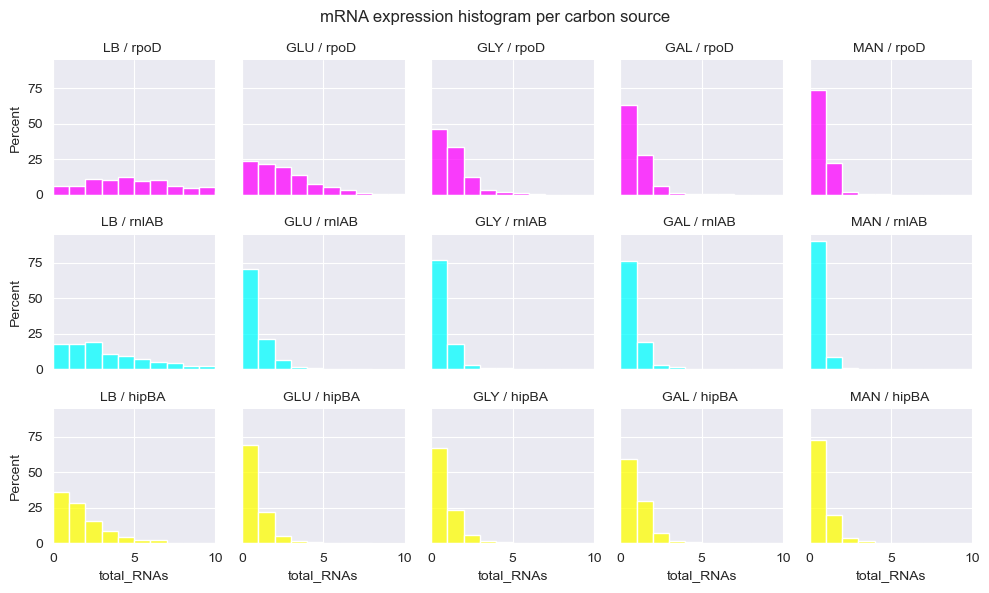

In [52]:
data = df_stacked.query('replicate != "exp16"')
g = sns.FacetGrid(data, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 10), sharex=True, sharey=True, hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='total_RNAs', binwidth=1, stat='density')
g.set_titles('{col_name} / {row_name} ')
g.fig.suptitle('mRNA expression histogram per carbon source')
g.tight_layout();
# compare to the data from the Golding paper

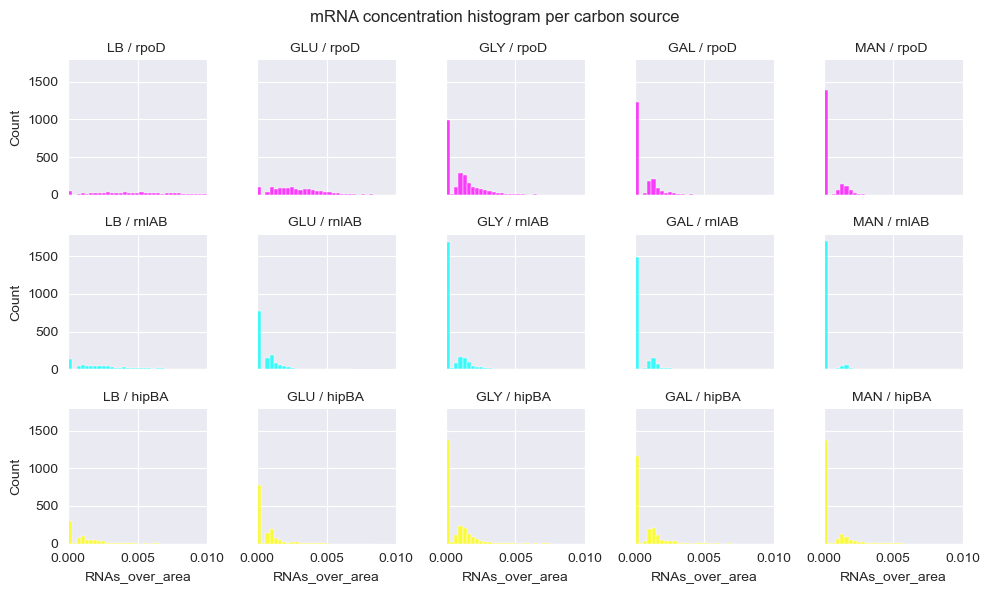

In [53]:
data = df_stacked.query('replicate == "exp22"')
g = sns.FacetGrid(data, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 0.01), hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='RNAs_over_area', binwidth=0.0003)
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA concentration histogram per carbon source')
g.tight_layout();

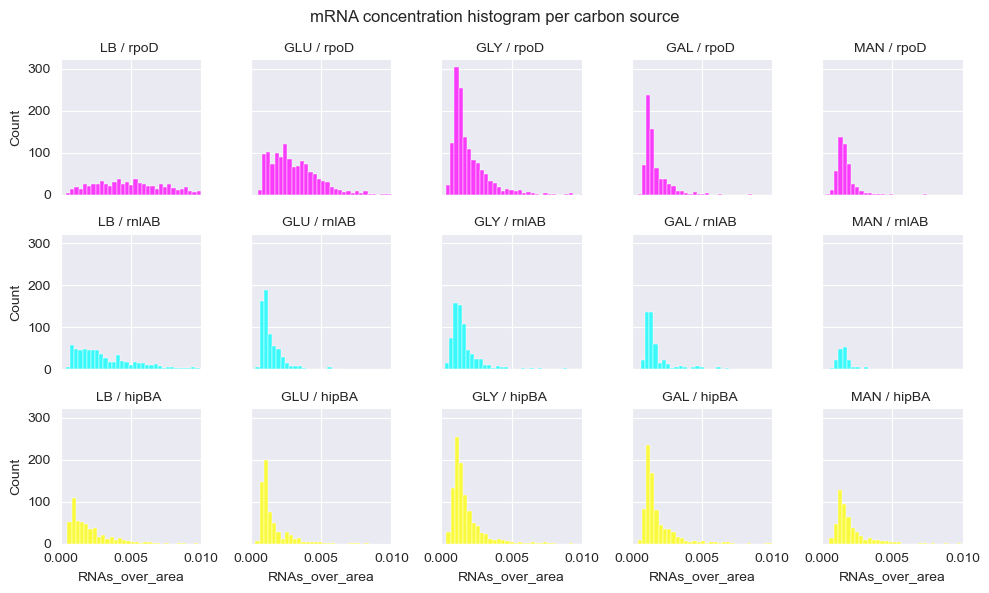

In [224]:
data = df_stacked.query('replicate == "exp22"').query('RNAs_over_area > 0')
g = sns.FacetGrid(data, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 0.01), hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='RNAs_over_area', binwidth=0.0003)
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA concentration histogram per carbon source')
g.tight_layout();

#### Distribution of number of spots

##### Explo plot - which I don't fully understand

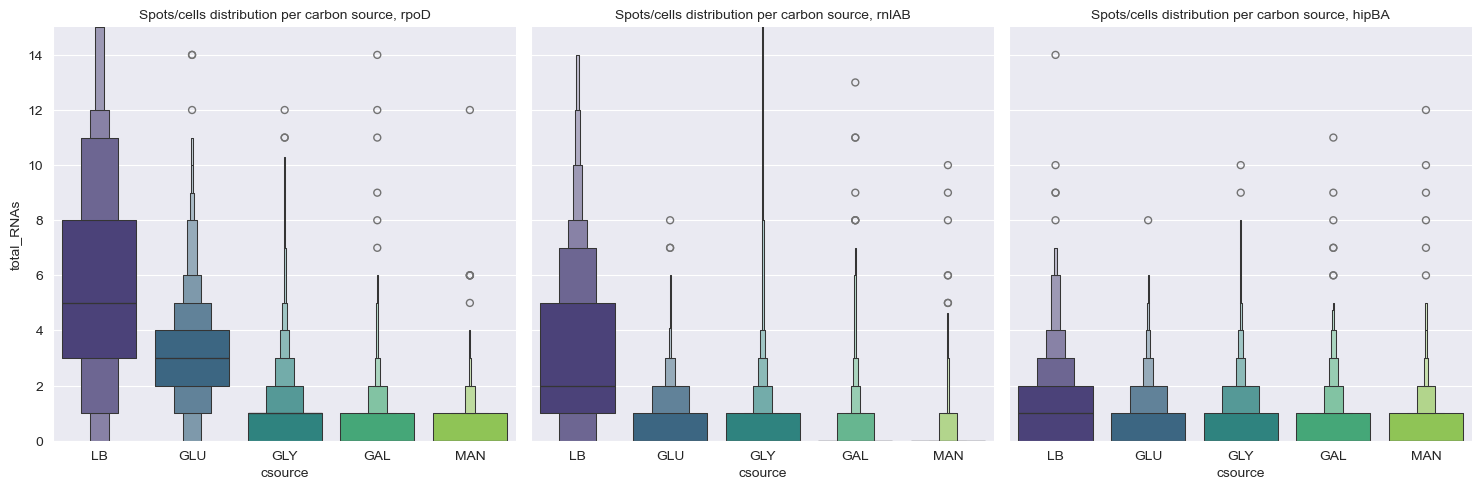

In [54]:
data=df_stacked.query('replicate == "exp22"')
g = sns.catplot(data=data, kind='boxen', x='csource', order=csources_ordered, y='total_RNAs', width_method='exponential', 
            col='mrna', col_order=mrna_ordered,
            hue='csource', palette=palette_csource)
g.set_titles('Spots/cells distribution per carbon source, {col_name}')
g.set(ylim=(0, 15));

#### Evolution of fraction of cells with n spots with growth rate

In [55]:
dfs = []
for (mrna, csource) in product(mrna_ordered, csources_ordered):
    d = data.query('mrna == @mrna').query('csource == @csource')
    counts = np.bincount(d['total_RNAs'])
    df = pd.DataFrame({
        'mrna': mrna,
        'csource': csource,
        'rank': np.arange(len(counts)),
        'nr_cells_at_rank': np.bincount(d['total_RNAs']),
        'nr_cells_total': np.full_like(counts, d.shape[0]), 
    })
    # print(df)
    dfs.append(df)
histograms = pd.DataFrame(pd.concat(dfs))
histograms['frequency'] = histograms['nr_cells_at_rank'] / histograms['nr_cells_total']
histograms

mrna csource  rank  nr_cells_at_rank  nr_cells_total  frequency
0    rpoD      LB     0                53             813   6.52e-02
1    rpoD      LB     1                52             813   6.40e-02
2    rpoD      LB     2                89             813   1.09e-01
3    rpoD      LB     3                83             813   1.02e-01
4    rpoD      LB     4               102             813   1.25e-01
..    ...     ...   ...               ...             ...        ...
8   hipBA     MAN     8                 1            1885   5.31e-04
9   hipBA     MAN     9                 1            1885   5.31e-04
10  hipBA     MAN    10                 1            1885   5.31e-04
11  hipBA     MAN    11                 0            1885   0.00e+00
12  hipBA     MAN    12                 1            1885   5.31e-04

[391 rows x 6 columns]

##### Explo plot

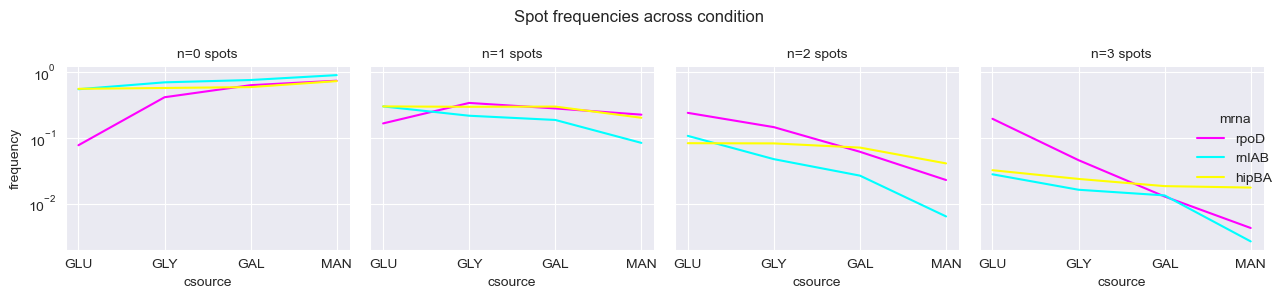

In [56]:
g = sns.relplot(data=histograms.query('rank < 4').query('csource != "LB"'), x='csource', y='frequency',
            col='rank', hue='mrna', palette=palette_mrna, kind='line', height=3)
g.set_titles('n={col_name} spots')
g.set(yscale="log")
g.fig.suptitle("Spot frequencies across condition")
plt.tight_layout();

### Expression versus cell features

#### Area

##### Plot - all data

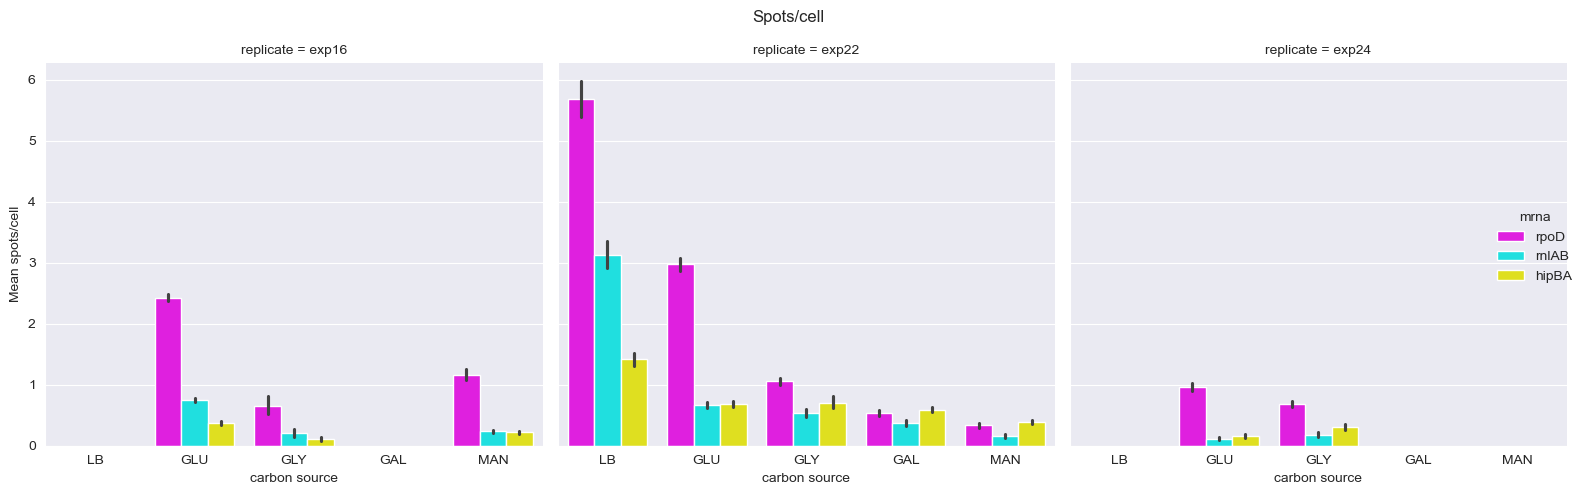

In [57]:
g = sns.catplot(df_stacked,
            col='replicate', col_order=replicates_ordered, 
            kind='bar', x='csource', order=csources_ordered, y='total_RNAs', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='Mean spots/cell')
g.fig.suptitle('Spots/cell')
plt.tight_layout();

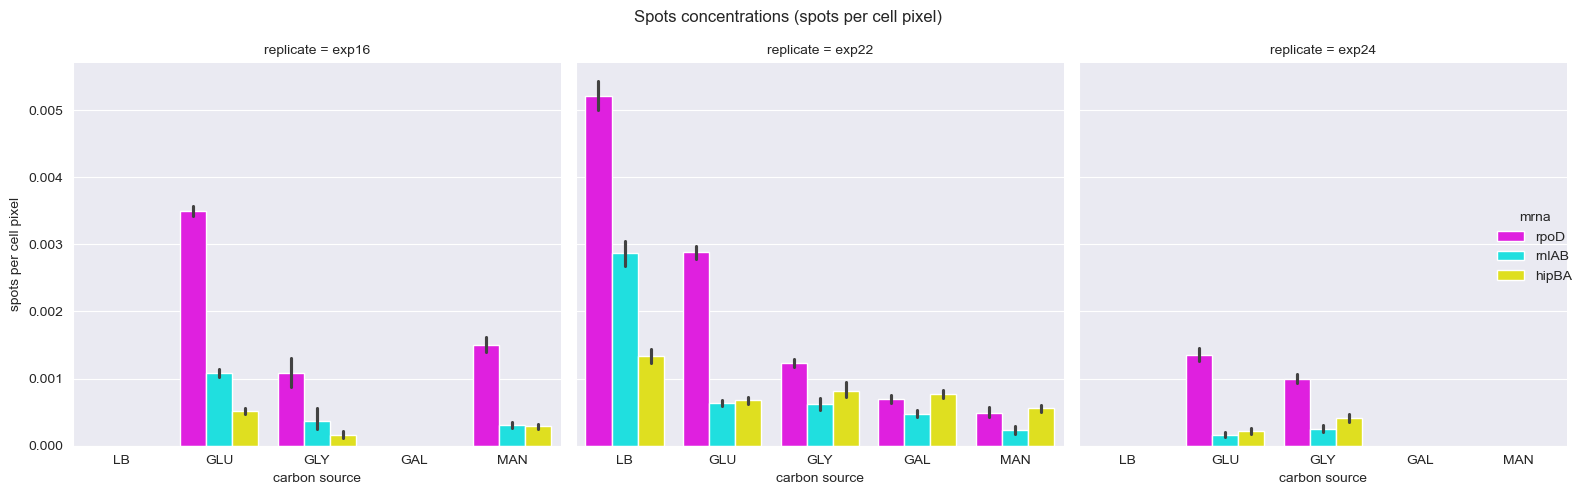

In [58]:
g = sns.catplot(df_stacked, kind='bar', 
            col='replicate', col_order=replicates_ordered, 
            x='csource', order=csources_ordered, y='RNAs_over_area', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='spots per cell pixel')
g.fig.suptitle('Spots concentrations (spots per cell pixel)')
plt.tight_layout();

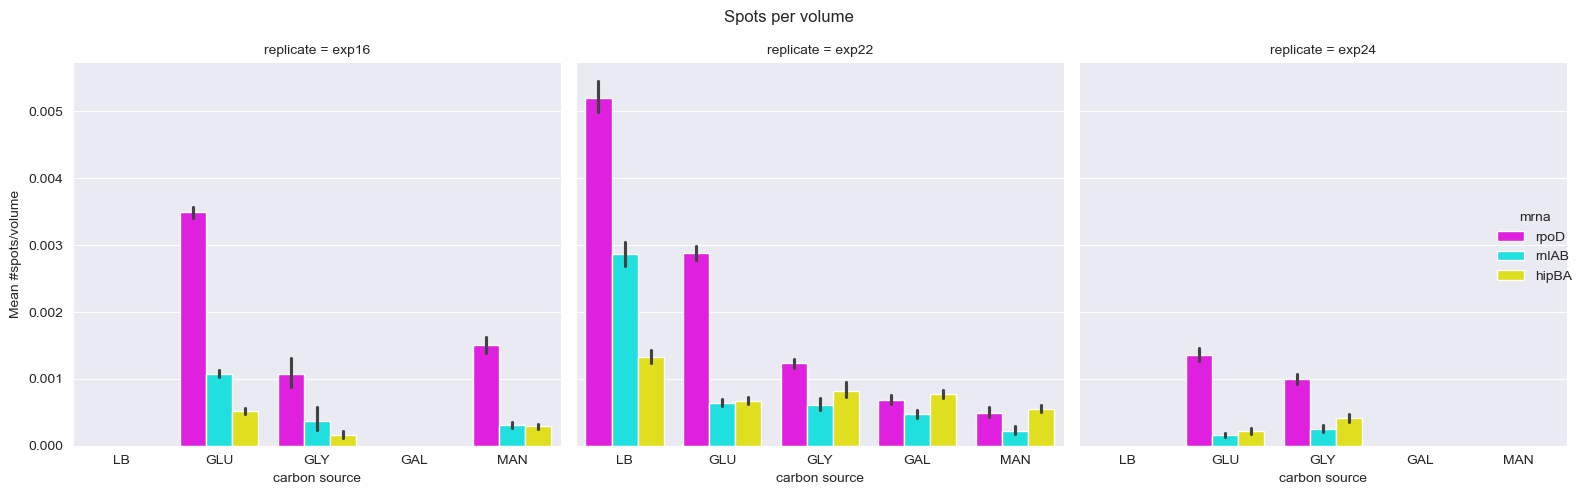

In [59]:
g = sns.catplot(df_stacked, kind='bar', 
            col='replicate', col_order=replicates_ordered, 
            x='csource', order=csources_ordered, y='RNAs_over_area', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='Mean #spots/volume')
g.fig.suptitle('Spots per volume')
plt.tight_layout();

In [60]:
df_stacked.columns

Index(['image_cell_id', 'spots', 'dense_regions', 'decomposed_RNAs', 'tx',
       'nascent_RNAs', 'total_RNAs', 'mrna', 'strain', 'condition', 'seqnr',
       'image', 'experiment', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'axis_minor_length', 'axis_major_length', 'orientation',
       'perimeter', 'solidity', 'nuclei', 'csource', 'coverslip', 'replicate',
       'unique_cell_id', 'selected', 'RNAs_over_area', 'volume',
       'volume_ellipsoid', 'RNAs_over_vol', 'RNAs_over_length',
       'RNAs_over_eccentricity', 'mu'],
      dtype='object')

In [61]:
df_stacked.index

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       477, 478, 479, 480, 481, 482, 483, 484, 485, 486],
      dtype='int64', length=48765)

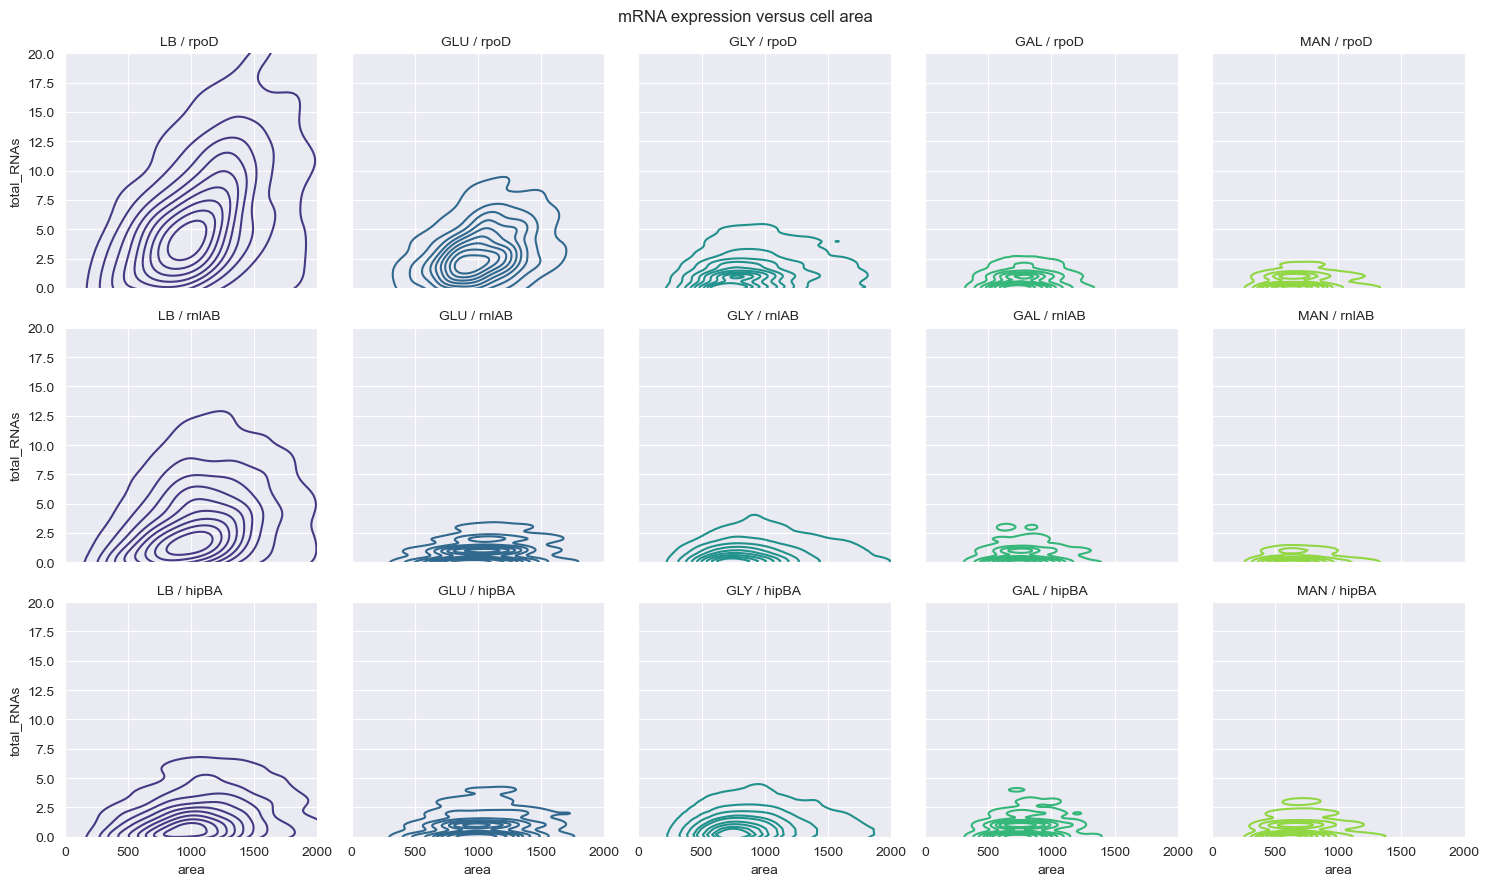

In [62]:
g = sns.FacetGrid(df_stacked.query('replicate == "exp22"'), 
                  row='mrna', row_order=mrna_ordered, 
                  col='csource', col_order=csources_ordered, 
                  xlim=(0, 2000), ylim=(0, 20),
                  sharex=True, sharey=True, height=3);
g.map_dataframe(sns.kdeplot, y='total_RNAs', x='area', hue='csource', palette=palette_csource)
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression versus cell area')
g.tight_layout();

#### Eccentricity / length

##### Plot - exp22 + exp24

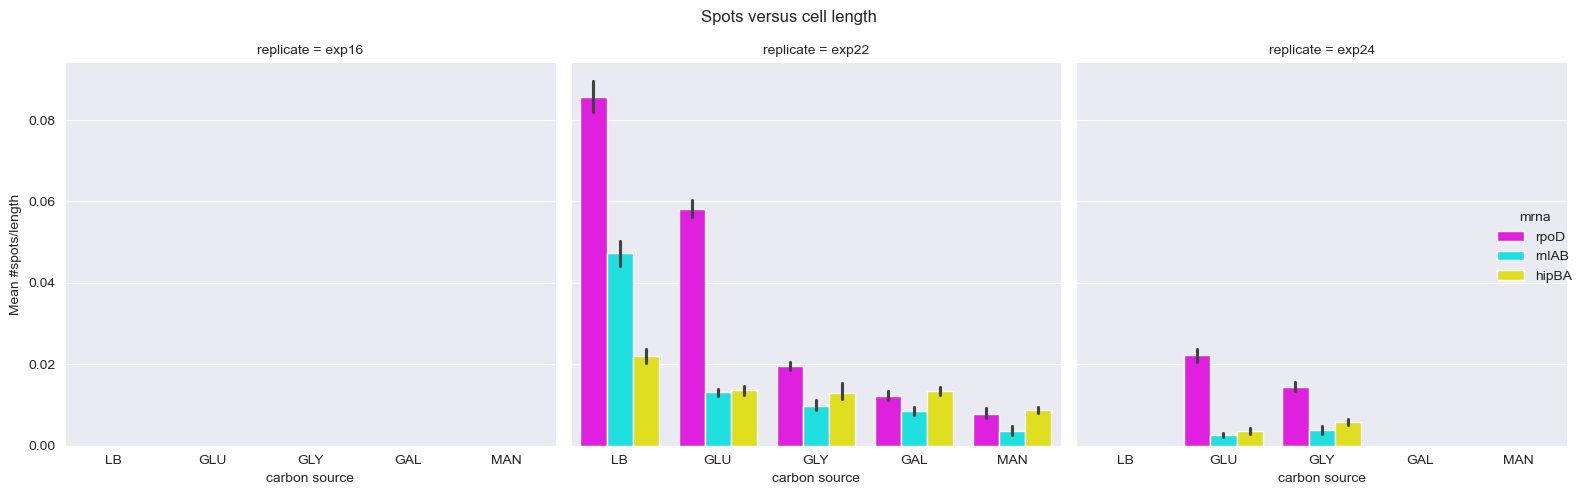

In [63]:
g = sns.catplot(df_stacked.query('replicate != "exp16"'), kind='bar', 
            col='replicate', col_order=replicates_ordered, 
            x='csource', order=csources_ordered, y='RNAs_over_length', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='Mean #spots/length')
g.fig.suptitle('Spots versus cell length')
plt.tight_layout();

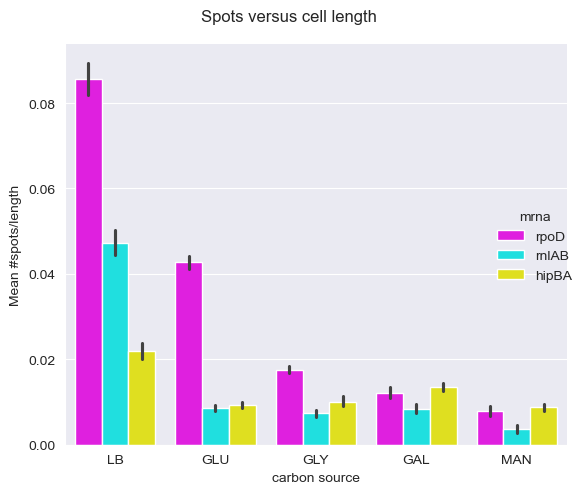

In [64]:
g = sns.catplot(df_stacked.query('replicate != "exp16"'), kind='bar', 
            x='csource', order=csources_ordered, y='RNAs_over_length', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='Mean #spots/length')
g.fig.suptitle('Spots versus cell length')
plt.tight_layout();

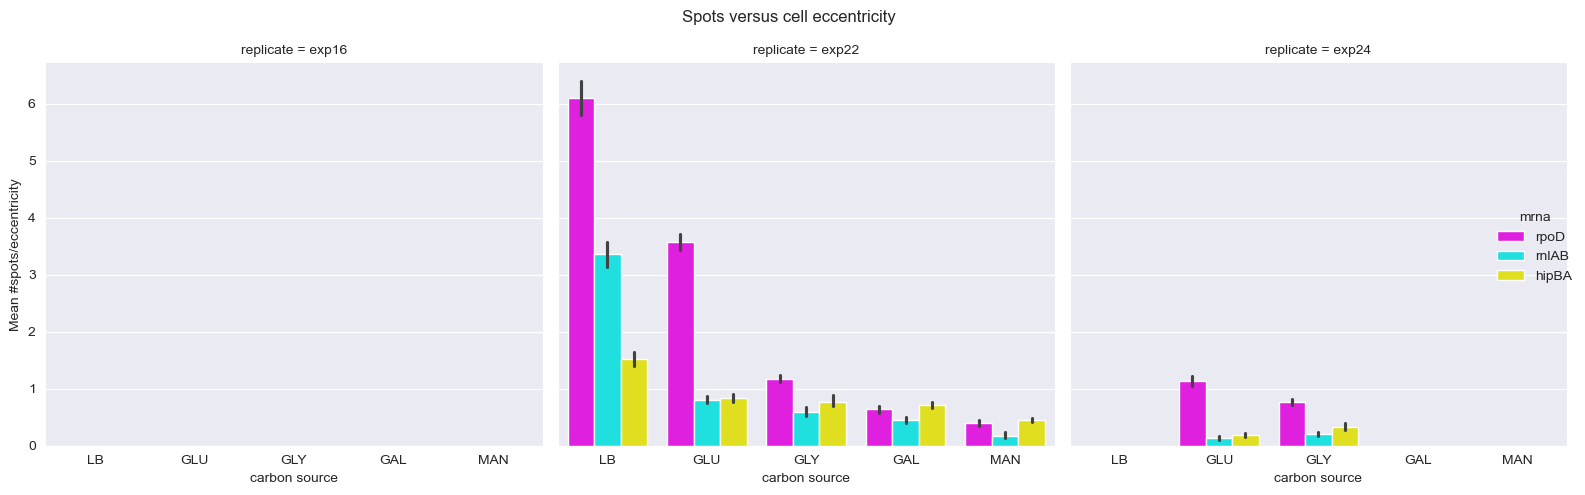

In [65]:
g = sns.catplot(df_stacked.query('replicate != "exp16"'), kind='bar', 
            col='replicate', col_order=replicates_ordered, 
            x='csource', order=csources_ordered, y='RNAs_over_eccentricity', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='Mean #spots/eccentricity')
g.fig.suptitle('Spots versus cell eccentricity')
plt.tight_layout();

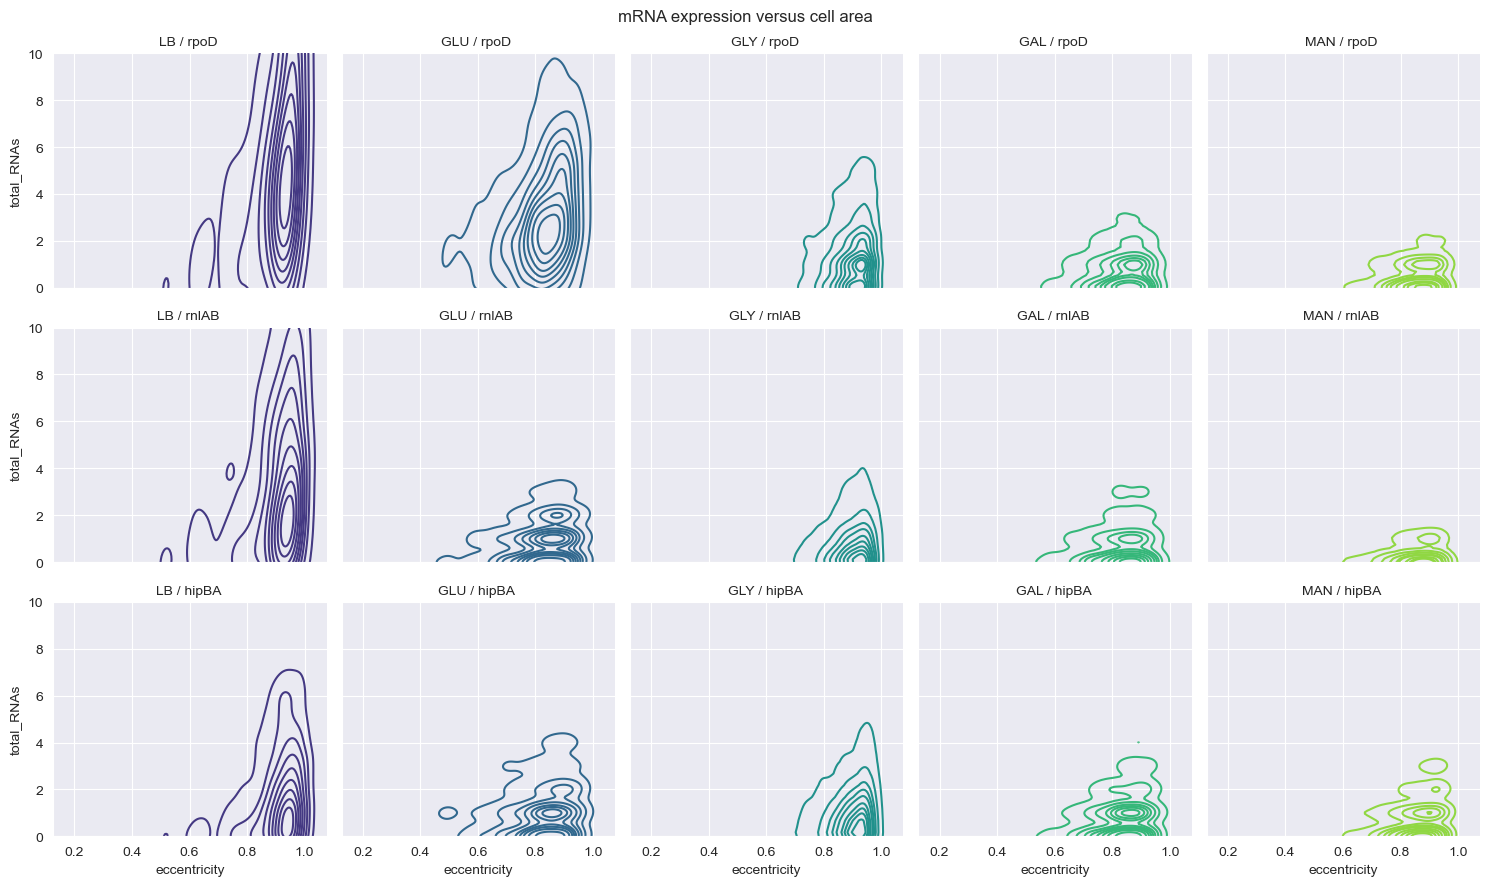

In [66]:
g = sns.FacetGrid(df_stacked.query('replicate == "exp22"'), 
                  row='mrna', row_order=mrna_ordered, 
                  col='csource', col_order=csources_ordered, 
                  ylim=(0, 10),
                  sharex=True, sharey=True, height=3);
g.map_dataframe(sns.kdeplot, y='total_RNAs', x='eccentricity', hue='csource', palette=palette_csource)
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression versus cell area')
g.tight_layout();

#### RNAs versus nucleoids

In [67]:
df_records_sane = df_records.query('total_RNAs_rpoD < 20').query('total_RNAs_rnlAB < 10').query('total_RNAs_hipBA < 10')

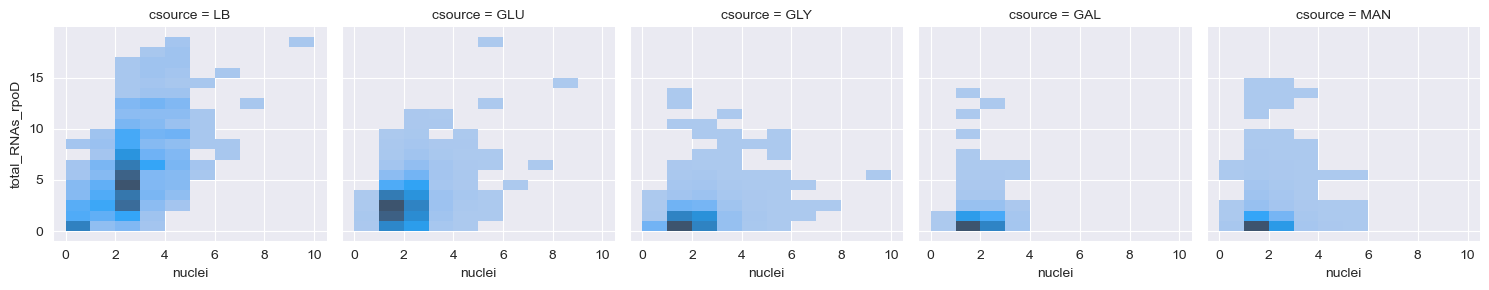

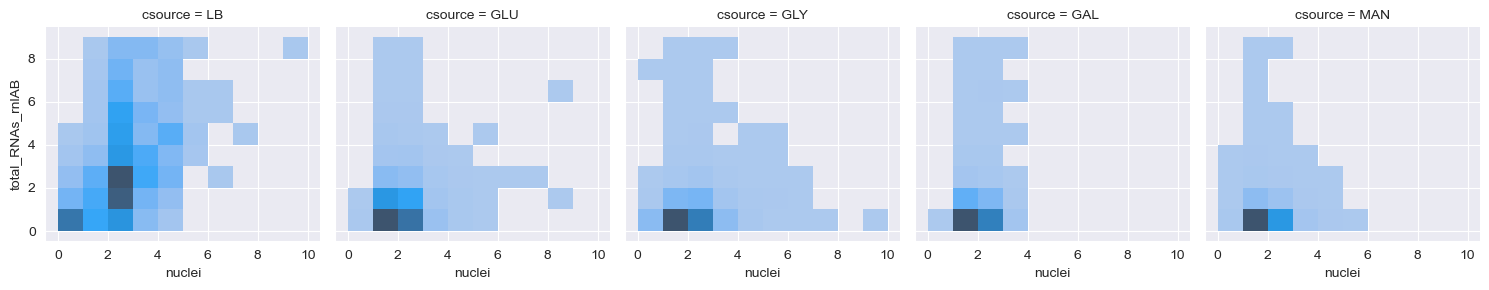

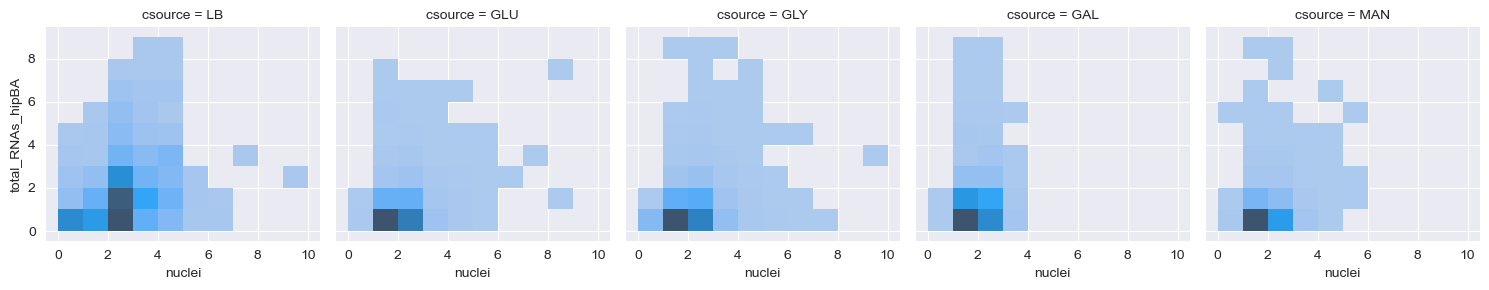

In [68]:
g1 =sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g1.map_dataframe(sns.histplot, y='total_RNAs_rpoD', x='nuclei', binwidth=1)

g2 = sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g2.map_dataframe(sns.histplot, y='total_RNAs_rnlAB', x='nuclei', binwidth=1)

g3 = sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g3.map_dataframe(sns.histplot, y='total_RNAs_hipBA', x='nuclei', binwidth=1);

11/25/2024 07:07:58PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
11/25/2024 07:07:58PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 


(0.0, 0.0125)

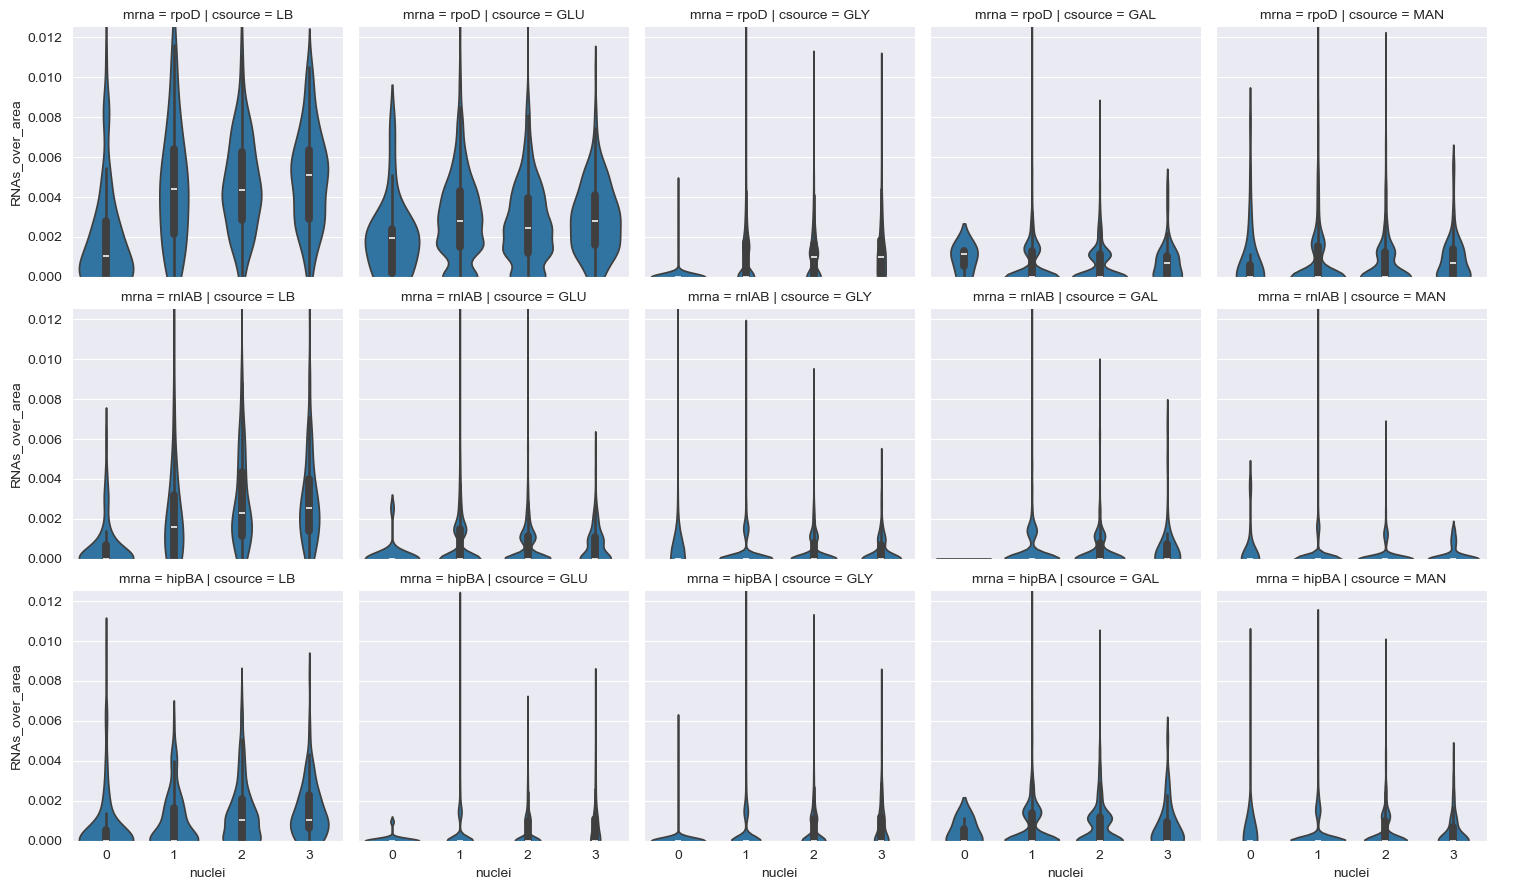

In [141]:

df_stacked_sane = df_stacked.query('total_RNAs < 10').query('nuclei < 4')
sns.catplot(data=df_stacked_sane, kind='violin', x='nuclei', y='RNAs_over_area',
            col='csource', col_order=csources_ordered,
            row='mrna', row_order=mrna_ordered, height=3)
plt.ylim(0, 0.0125)

### Co-expression

#### 2D histograms

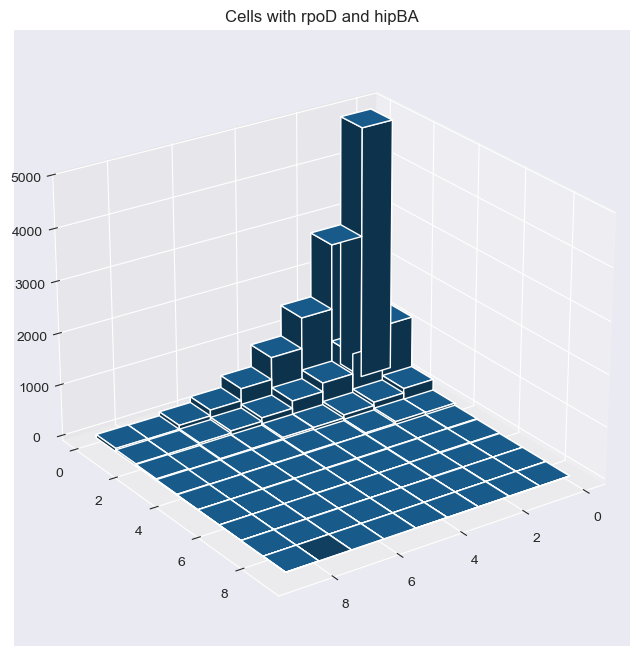

In [70]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
x, y = df_records_sane['total_RNAs_rpoD'], df_records_sane['total_RNAs_hipBA']
hist, xedges, yedges = np.histogram2d(y, x, bins=9, range=[[0, 9], [0, 9]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="xy")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 1
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax.view_init(25, 55)
plt.title("Cells with rpoD and hipBA")
plt.show()

In [71]:
df_records.columns

Index(['image_cell_id', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'axis_minor_length', 'axis_major_length', 'orientation',
       'perimeter', 'solidity', 'nuclei', 'spots_hipBA', 'dense_regions_hipBA',
       'decomposed_RNAs_hipBA', 'tx_hipBA', 'nascent_RNAs_hipBA',
       'total_RNAs_hipBA', 'spots_rnlAB', 'dense_regions_rnlAB',
       'decomposed_RNAs_rnlAB', 'tx_rnlAB', 'nascent_RNAs_rnlAB',
       'total_RNAs_rnlAB', 'spots_rpoD', 'dense_regions_rpoD',
       'decomposed_RNAs_rpoD', 'tx_rpoD', 'nascent_RNAs_rpoD',
       'total_RNAs_rpoD', 'strain', 'condition', 'seqnr', 'image',
       'experiment', 'csource', 'coverslip', 'replicate', 'unique_cell_id',
       'selected', 'mu', 'volume', 'volume_ellipsoid', 'RNAs_over_area_rpoD',
       'RNAs_over_vol_rpoD', 'RNAs_over_area_rnlAB', 'RNAs_over_vol_rnlAB',
       'RNAs_over_area_hipBA', 'RNAs_over_vol_hipBA'],
      dtype='object')

#### Density plots

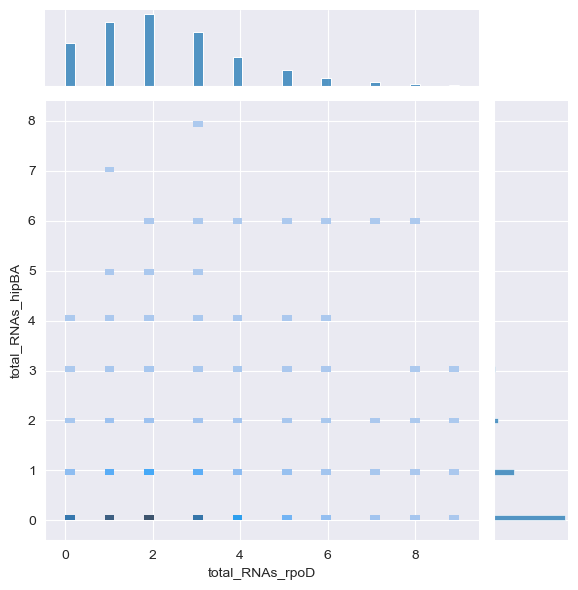

In [72]:
df_records_sane = df_records.query('total_RNAs_rpoD < 10').query('total_RNAs_rnlAB < 10').query('total_RNAs_hipBA < 10')
sns.jointplot(data=df_records_sane.query('csource == "GLU"'), x='total_RNAs_rpoD', y='total_RNAs_hipBA', kind='hist');

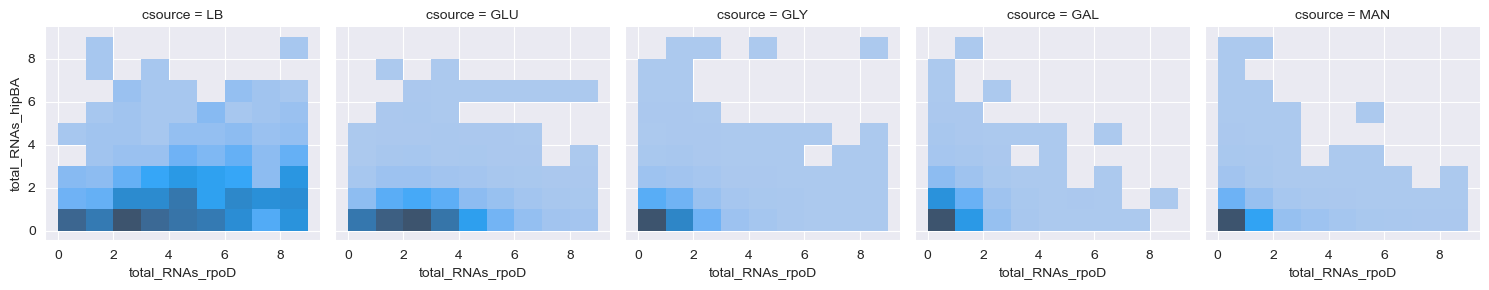

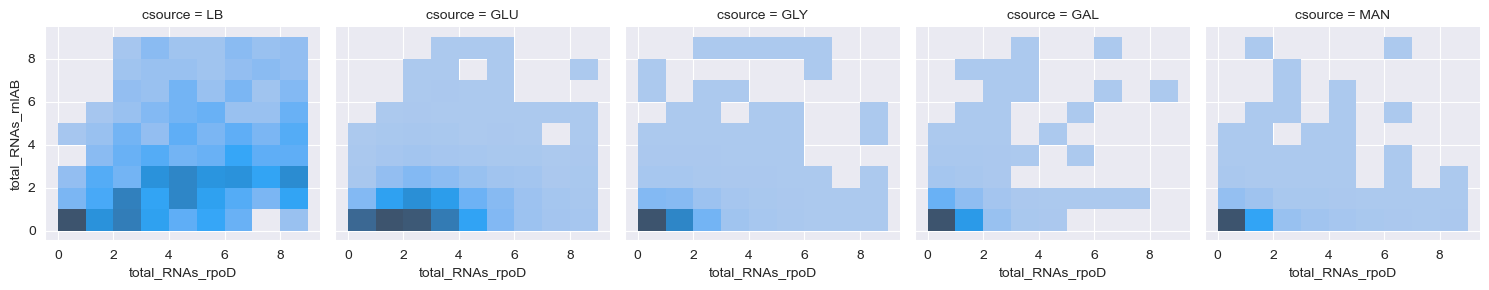

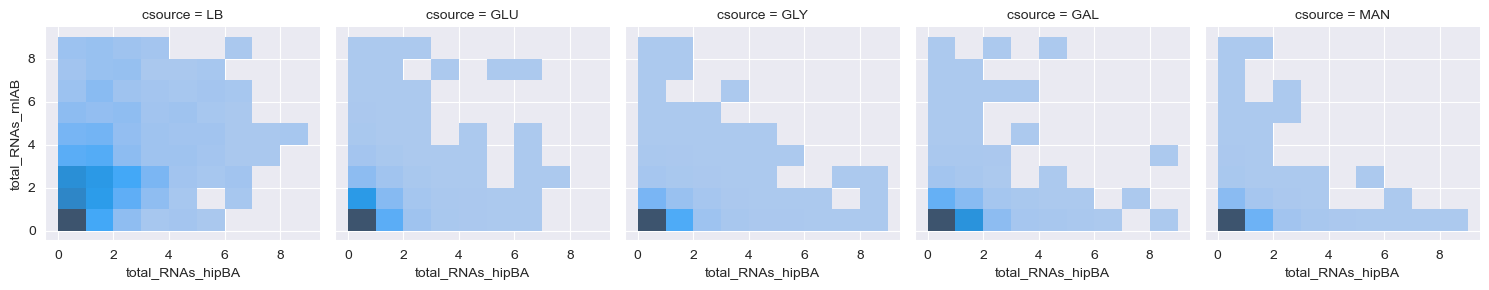

In [73]:
fill=True
g1 =sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g1.map_dataframe(sns.histplot, x='total_RNAs_rpoD', y='total_RNAs_hipBA', binwidth=1)

g2 = sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g2.map_dataframe(sns.histplot, x='total_RNAs_rpoD', y='total_RNAs_rnlAB', binwidth=1)

g3 = sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True,
# heatmap with absolute numbers
# toxin vs toxin minus the non expressing cells
# do cells with zero rpoD have more TA


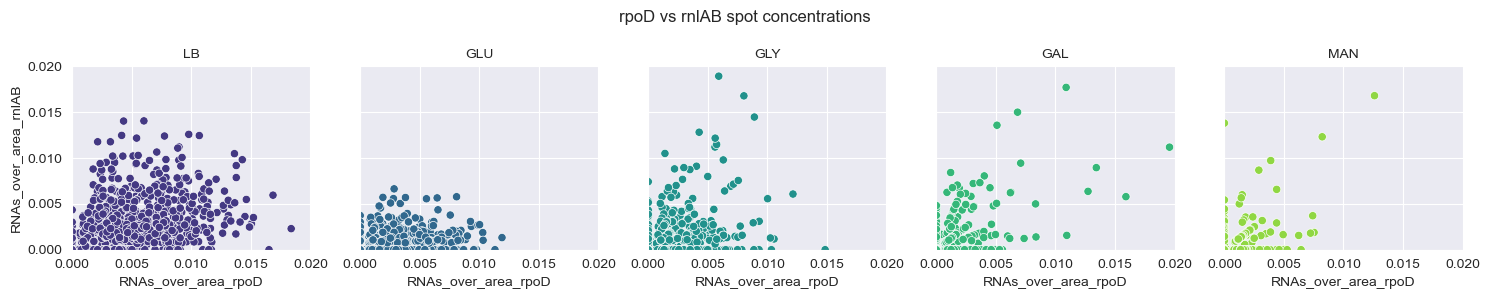

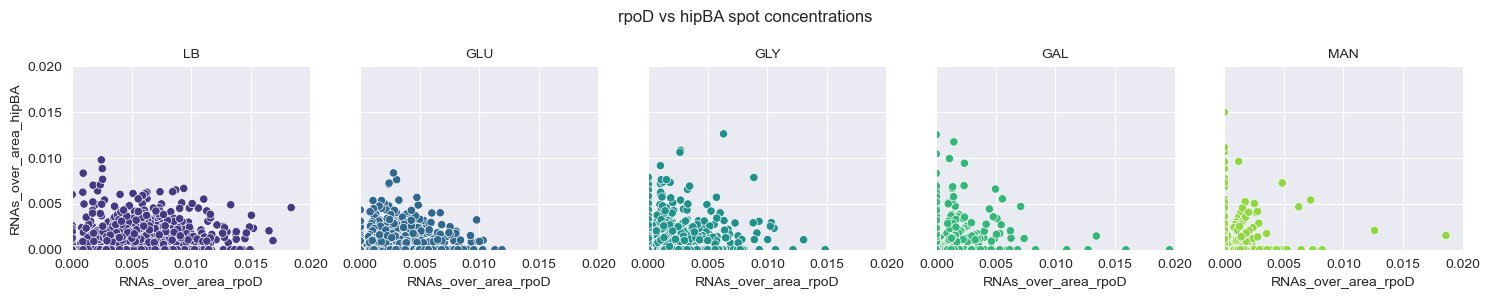

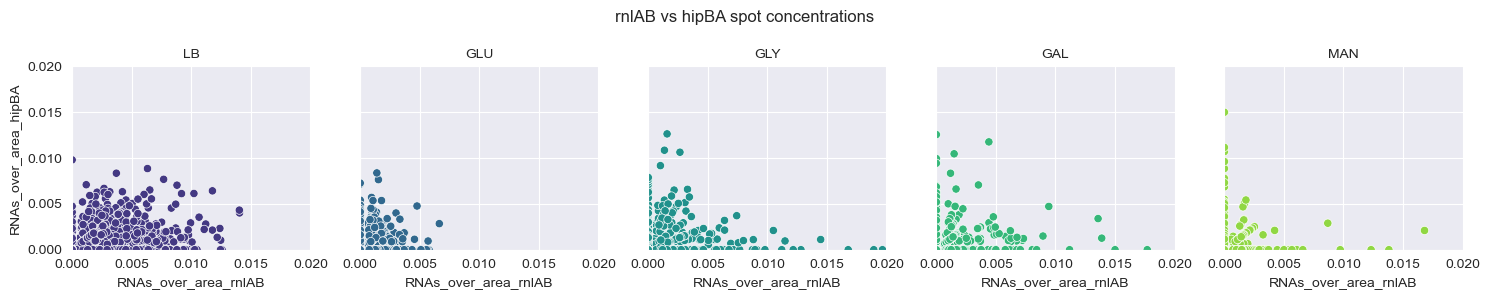

In [228]:
g = sns.FacetGrid(df_records.query('replicate == "exp22"'),
                  col='csource', col_order=csources_ordered,
                  xlim=(0, 0.02), ylim=(0, 0.02),
                  sharex=True, sharey=True, height=3);
g.map_dataframe(sns.scatterplot, x='RNAs_over_area_rpoD', y='RNAs_over_area_rnlAB', hue='csource', palette=palette_csource)
g.set_titles('{col_name}')
g.fig.suptitle('rpoD vs rnlAB spot concentrations')
g.tight_layout()
savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/coexpression-rpoD-rnlAB_exp22"
plt.savefig(savestem + ".pdf");

g = sns.FacetGrid(df_records.query('replicate == "exp22"'),
                  col='csource', col_order=csources_ordered,
                  xlim=(0, 0.02), ylim=(0, 0.02),
                  sharex=True, sharey=True, height=3);
g.map_dataframe(sns.scatterplot, x='RNAs_over_area_rpoD', y='RNAs_over_area_hipBA', hue='csource', palette=palette_csource)
g.set_titles('{col_name}');
g.fig.suptitle('rpoD vs hipBA spot concentrations')
g.tight_layout()
savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/coexpression-rpoD-hipBA_exp22"
plt.savefig(savestem + ".pdf");

g = sns.FacetGrid(df_records.query('replicate == "exp22"'),
                  col='csource', col_order=csources_ordered,
                  xlim=(0, 0.02), ylim=(0, 0.02),
                  sharex=True, sharey=True, height=3);
g.map_dataframe(sns.scatterplot, x='RNAs_over_area_rnlAB', y='RNAs_over_area_hipBA', hue='csource', palette=palette_csource)
g.set_titles('{col_name}');
g.fig.suptitle('rnlAB vs hipBA spot concentrations')
g.tight_layout()
savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/coexpression-rnlAB-hipBA_exp22"
plt.savefig(savestem + ".pdf");

#### Fraction of cells with two RNAs

In [57]:
data = df_records.query('replicate == "exp22"')

In [58]:
#  same content as cell below, just easier to check
df_counts = pd.DataFrame({
    'total': data.groupby('csource').size().reindex(csources_ordered),
    'rpoD': data.query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB': data.query('spots_rnlAB > 0').groupby('csource').size().reindex(csources_ordered),
    'hipBA': data.query('spots_hipBA > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB&hipBA': data.query('spots_rnlAB > 0').query('spots_hipBA > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB&rpoD': data.query('spots_rnlAB > 0').query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
    'hipBA&rpoD': data.query('spots_hipBA > 0').query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
})

df_counts['%rpoD'] = df_counts['rpoD'] / df_counts['total']
df_counts['%rnlAB'] = df_counts['rnlAB'] / df_counts['total']
df_counts['%hipBA'] = df_counts['hipBA'] / df_counts['total']
df_counts['%rnlAB*%hipBA'] = df_counts['%rnlAB'] * df_counts['%hipBA']
df_counts['%rnlAB&hipBA'] = df_counts['rnlAB&hipBA'] / df_counts['total']
df_counts['%rnlAB&rpoD'] = df_counts['rnlAB&rpoD'] / df_counts['total']
df_counts['%hipBA&rpoD'] = df_counts['hipBA&rpoD'] / df_counts['total']
# df_counts = df_counts[['total', 'rpoD', '%rpoD', 'hipBA', '%hipBA', 'rnlAB', '%rnlAB', '%rnlAB*%hipBA', '%rnlAB&hipBA', '%rnlAB&rpoD', '%hipBA&rpoD']]
df_counts

total  rpoD  rnlAB  hipBA  rnlAB&hipBA  rnlAB&rpoD  hipBA&rpoD  \
csource                                                                   
LB         813   758    671    517          470         659         500   
GLU       1399  1291    629    619          296         591         578   
GLY       2405  1406    721   1024          349         502         627   
GAL       1955   717    471    797          213         214         310   
MAN       1885   489    187    508           57          83         156   

         %rpoD  %rnlAB  %hipBA  %rnlAB*%hipBA  %rnlAB&hipBA  %rnlAB&rpoD  \
csource                                                                    
LB        0.93    0.83    0.64           0.52          0.58         0.81   
GLU       0.92    0.45    0.44           0.20          0.21         0.42   
GLY       0.58    0.30    0.43           0.13          0.15         0.21   
GAL       0.37    0.24    0.41           0.10          0.11         0.11   
MAN       0.26    0.10    0.27           0.03          0.03         0.04   

         %hipBA&rpoD  
csource               
LB              0.62  
GLU             0.41  
GLY             0.26  
GAL             0.16  
MAN             0.08

In [59]:
#  same content as cell below, just easier to check
df_counts = pd.DataFrame({
    'total': data.groupby('csource').size().reindex(csources_ordered),
    'rpoD': data.query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB': data.query('spots_rnlAB > 0').groupby('csource').size().reindex(csources_ordered),
    'hipBA': data.query('spots_hipBA > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB&hipBA': data.query('spots_rnlAB > 0').query('spots_hipBA > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB&rpoD': data.query('spots_rnlAB > 0').query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
    'hipBA&rpoD': data.query('spots_hipBA > 0').query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
})

df_counts['%rpoD'] = df_counts['rpoD'] / df_counts['total']
df_counts['%rnlAB'] = df_counts['rnlAB'] / df_counts['total']
df_counts['%hipBA'] = df_counts['hipBA'] / df_counts['total']
df_counts['%rnlAB*%hipBA'] = df_counts['%rnlAB'] * df_counts['%hipBA']
df_counts['%rnlAB&hipBA'] = df_counts['rnlAB&hipBA'] / df_counts['total']
df_counts['%rnlAB&rpoD'] = df_counts['rnlAB&rpoD'] / df_counts['total']
df_counts['%hipBA&rpoD'] = df_counts['hipBA&rpoD'] / df_counts['total']
# df_counts = df_counts[['total', 'rpoD', '%rpoD', 'hipBA', '%hipBA', 'rnlAB', '%rnlAB', '%rnlAB*%hipBA', '%rnlAB&hipBA', '%rnlAB&rpoD', '%hipBA&rpoD']]
df_counts

total  rpoD  rnlAB  hipBA  rnlAB&hipBA  rnlAB&rpoD  hipBA&rpoD  \
csource                                                                   
LB         813   758    671    517          470         659         500   
GLU       1399  1291    629    619          296         591         578   
GLY       2405  1406    721   1024          349         502         627   
GAL       1955   717    471    797          213         214         310   
MAN       1885   489    187    508           57          83         156   

         %rpoD  %rnlAB  %hipBA  %rnlAB*%hipBA  %rnlAB&hipBA  %rnlAB&rpoD  \
csource                                                                    
LB        0.93    0.83    0.64           0.52          0.58         0.81   
GLU       0.92    0.45    0.44           0.20          0.21         0.42   
GLY       0.58    0.30    0.43           0.13          0.15         0.21   
GAL       0.37    0.24    0.41           0.10          0.11         0.11   
MAN       0.26    0.10    0.27           0.03          0.03         0.04   

         %hipBA&rpoD  
csource               
LB              0.62  
GLU             0.41  
GLY             0.26  
GAL             0.16  
MAN             0.08

In [61]:
all_frequencies = pd.DataFrame()

total_cells = data.groupby('csource').size().reindex(csources_ordered)

for mrna in ['rpoD', 'rnlAB', 'hipBA']:
    df_mrna = pd.DataFrame({'counts': data.query(f'spots_{mrna} > 0').groupby('csource').size().reindex(csources_ordered)})
    df_mrna['mrna_set'] = mrna
    df_mrna['cardinality'] = 1
    df_mrna['total'] = total_cells
    df_mrna['fraction'] = df_mrna['counts'] / df_mrna['total']
    
    all_frequencies = pd.concat([all_frequencies, df_mrna])
    
for mrna_pair in combinations(['rpoD', 'rnlAB', 'hipBA'], 2):
    df_mrna = pd.DataFrame({'counts': data.query(f'spots_{mrna_pair[0]} > 0').query(f'spots_{mrna_pair[1]} > 0').groupby('csource').size().reindex(csources_ordered)})
    df_mrna['mrna_set'] = mrna_pair[0] + '_' + mrna_pair[1]
    df_mrna['cardinality'] = 2
    df_mrna['total'] = total_cells
    df_mrna['fraction'] = df_mrna['counts'] / df_mrna['total']
    df_mrna['expected'] = all_frequencies.query('mrna_set == @mrna_pair[0]')['fraction'] * all_frequencies.query('mrna_set == @mrna_pair[1]')['fraction']
    
    all_frequencies = pd.concat([all_frequencies, df_mrna])
    
for mrna_pair in combinations(['rpoD', 'rnlAB', 'hipBA'], 3):
    df_mrna = pd.DataFrame({'counts': data.query(f'spots_{mrna_pair[0]} > 0').query(f'spots_{mrna_pair[1]} > 0').query(f'spots_{mrna_pair[2]} > 0').groupby('csource').size().reindex(csources_ordered)})
    df_mrna['mrna_set'] = mrna_pair[0] + '_' + mrna_pair[1] + '_' + mrna_pair[2]
    df_mrna['cardinality'] = 3
    df_mrna['total'] = total_cells
    df_mrna['fraction'] = df_mrna['counts'] / df_mrna['total']
    df_mrna['expected'] = all_frequencies.query('mrna_set == @mrna_pair[0]')['fraction'] * all_frequencies.query('mrna_set == @mrna_pair[1]')['fraction'] * all_frequencies.query('mrna_set == @mrna_pair[2]')['fraction']

    all_frequencies = pd.concat([all_frequencies, df_mrna])
    
all_frequencies

counts          mrna_set  cardinality  total  fraction  expected
csource                                                                  
LB          758              rpoD            1    813      0.93       NaN
GLU        1291              rpoD            1   1399      0.92       NaN
GLY        1406              rpoD            1   2405      0.58       NaN
GAL         717              rpoD            1   1955      0.37       NaN
MAN         489              rpoD            1   1885      0.26       NaN
LB          671             rnlAB            1    813      0.83       NaN
GLU         629             rnlAB            1   1399      0.45       NaN
GLY         721             rnlAB            1   2405      0.30       NaN
GAL         471             rnlAB            1   1955      0.24       NaN
MAN         187             rnlAB            1   1885      0.10       NaN
LB          517             hipBA            1    813      0.64       NaN
GLU         619             hipBA            1   1399      0.44       NaN
GLY        1024             hipBA            1   2405      0.43       NaN
GAL         797             hipBA            1   1955      0.41       NaN
MAN         508             hipBA            1   1885      0.27       NaN
LB          659        rpoD_rnlAB            2    813      0.81  7.70e-01
GLU         591        rpoD_rnlAB            2   1399      0.42  4.15e-01
GLY         502        rpoD_rnlAB            2   2405      0.21  1.75e-01
GAL         214        rpoD_rnlAB            2   1955      0.11  8.84e-02
MAN          83        rpoD_rnlAB            2   1885      0.04  2.57e-02
LB          500        rpoD_hipBA            2    813      0.62  5.93e-01
GLU         578        rpoD_hipBA            2   1399      0.41  4.08e-01
GLY         627        rpoD_hipBA            2   2405      0.26  2.49e-01
GAL         310        rpoD_hipBA            2   1955      0.16  1.50e-01
MAN         156        rpoD_hipBA            2   1885      0.08  6.99e-02
LB          470       rnlAB_hipBA            2    813      0.58  5.25e-01
GLU         296       rnlAB_hipBA            2   1399      0.21  1.99e-01
GLY         349       rnlAB_hipBA            2   2405      0.15  1.28e-01
GAL         213       rnlAB_hipBA            2   1955      0.11  9.82e-02
MAN          57       rnlAB_hipBA            2   1885      0.03  2.67e-02
LB          461  rpoD_rnlAB_hipBA            3    813      0.57  4.89e-01
GLU         281  rpoD_rnlAB_hipBA            3   1399      0.20  1.84e-01
GLY         243  rpoD_rnlAB_hipBA            3   2405      0.10  7.46e-02
GAL         101  rpoD_rnlAB_hipBA            3   1955      0.05  3.60e-02
MAN          35  rpoD_rnlAB_hipBA            3   1885      0.02  6.94e-03

##### Plot - all data

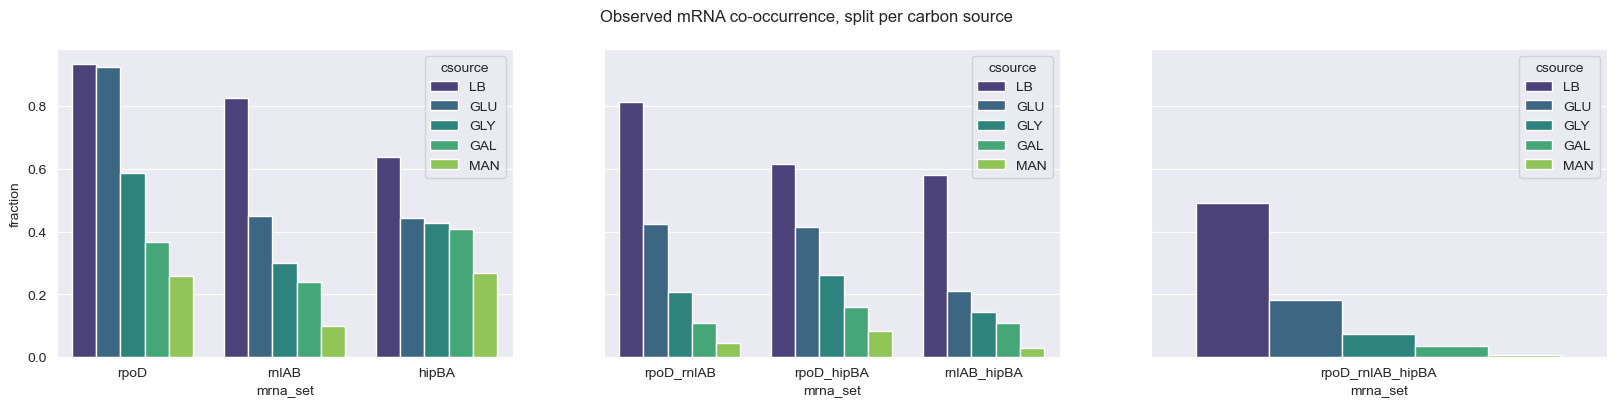

In [69]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
fig.suptitle('Observed mRNA co-occurrence, split per carbon source')

g = sns.barplot(all_frequencies.query('cardinality == 1'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 3'), x='mrna_set', y='expected', hue='csource', palette=palette_csource, ax=ax[2])

##### Plot - only exp22 data

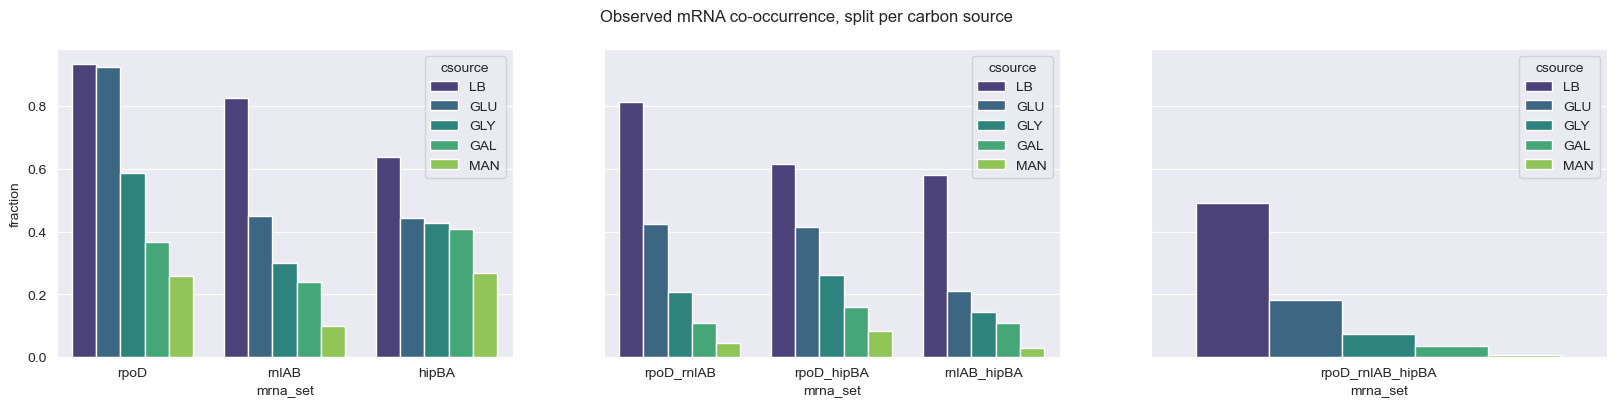

In [70]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
fig.suptitle('Observed mRNA co-occurrence, split per carbon source')

g = sns.barplot(all_frequencies.query('cardinality == 1'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 3'), x='mrna_set', y='expected', hue='csource', palette=palette_csource, ax=ax[2])

##### Plot - all data

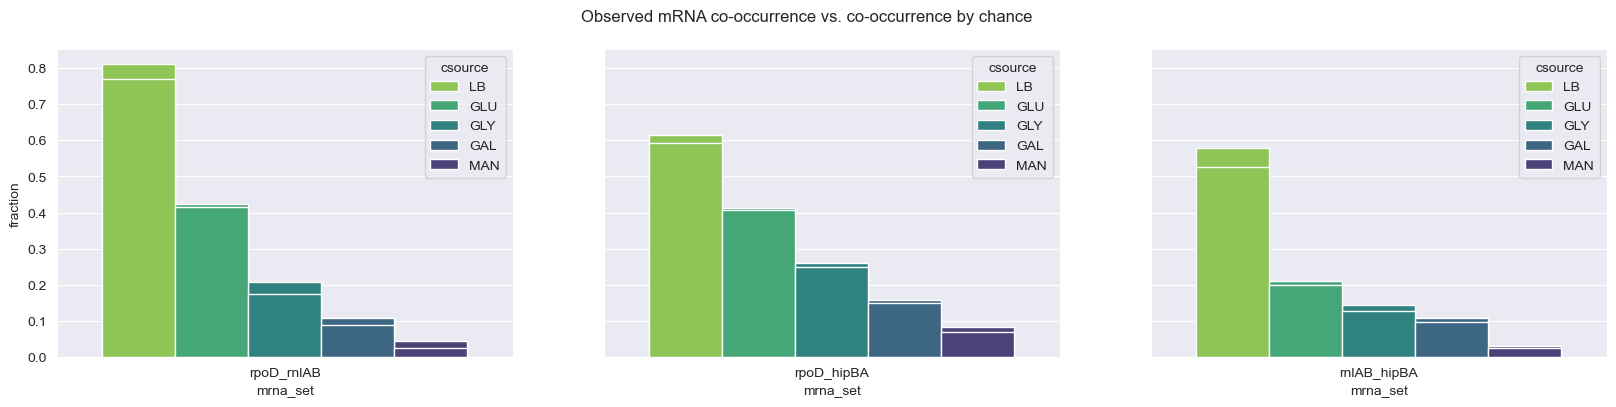

In [71]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
fig.suptitle('Observed mRNA co-occurrence vs. co-occurrence by chance')

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[0], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[1], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[2])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[2], legend=False)

##### Plot - only exp22 data

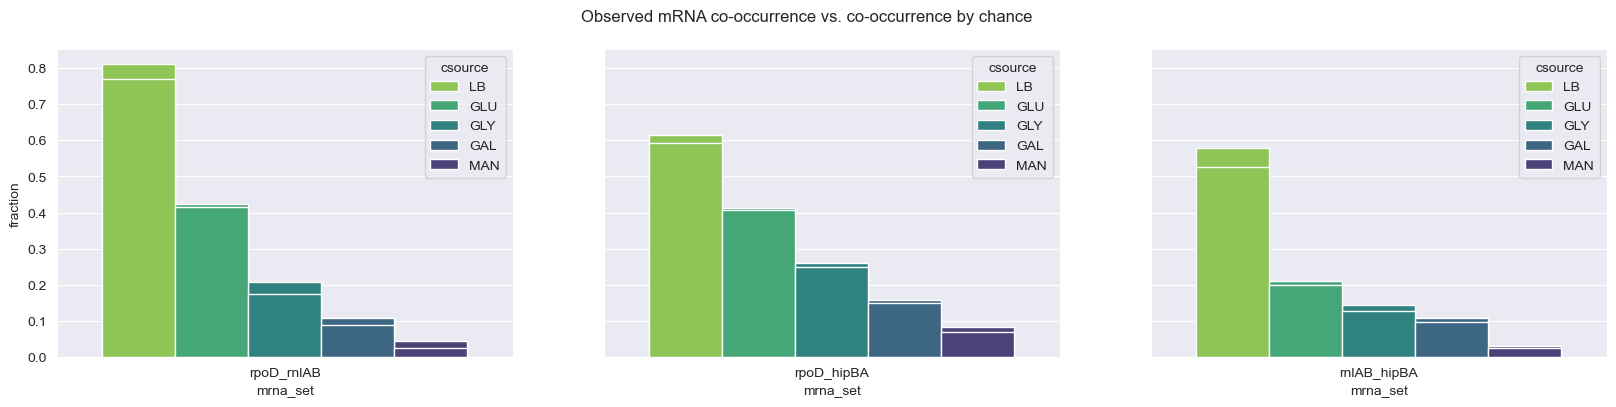

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
fig.suptitle('Observed mRNA co-occurrence vs. co-occurrence by chance')

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[0], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[1], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[2])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[2], legend=False)

##### Plot - all data

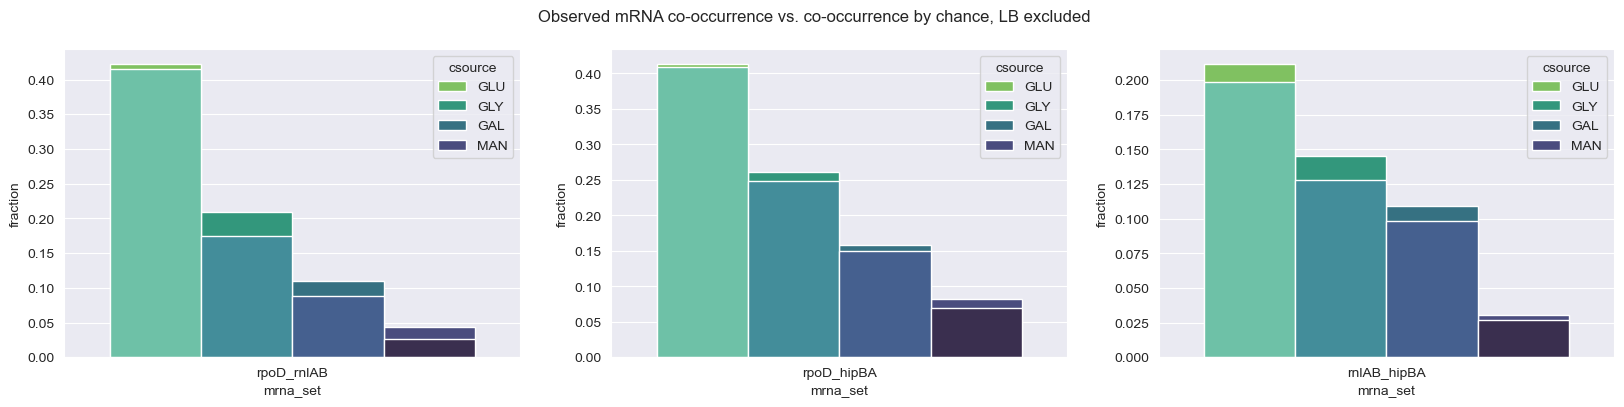

In [73]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=False)
fig.suptitle('Observed mRNA co-occurrence vs. co-occurrence by chance, LB excluded')

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='expected', hue='csource', palette='mako_r', ax=ax[0], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='mako_r', ax=ax[1], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[2])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='mako_r', ax=ax[2], legend=False)

##### Plot - only exp22 data

/var/folders/pp/cdyfs0g13j3_15mc99_0nfmh0000gn/T/ipykernel_74999/266161668.py:7: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='expected', hue='csource', palette=greys, ax=ax[0], legend=False)
/var/folders/pp/cdyfs0g13j3_15mc99_0nfmh0000gn/T/ipykernel_74999/266161668.py:10: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='expected', hue='csource', palette=greys, ax=ax[1], legend=False)
/var/folders/pp/cdyfs0g13j3_15mc99_0nfmh0000gn/T/ipykernel_74999/266161668.py:13: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.barplot(all_frequencies.query('cardinality == 2').query('cs

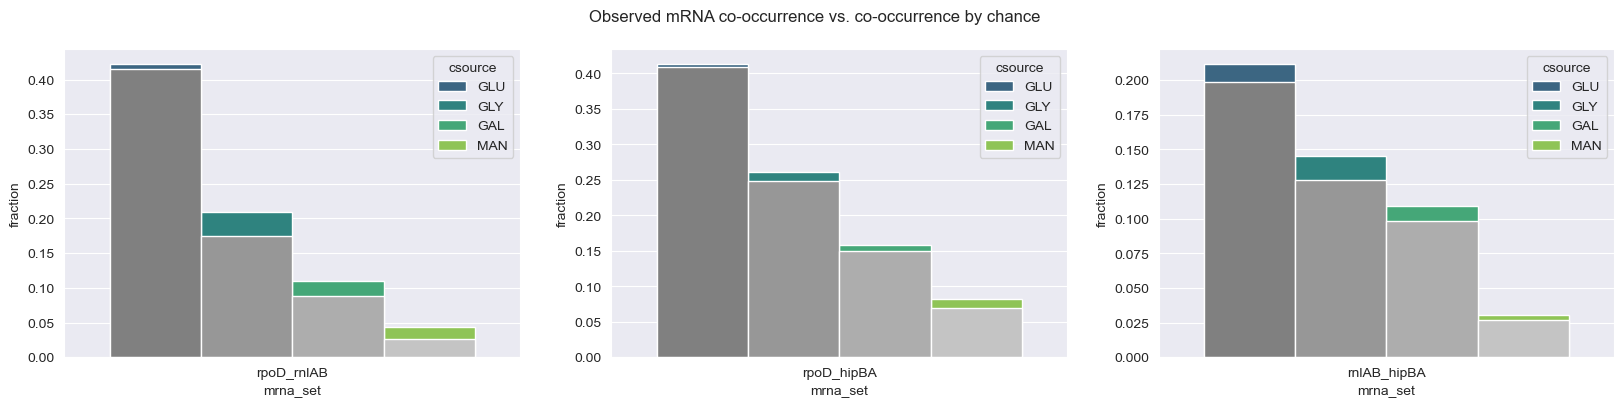

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=False)
fig.suptitle('Observed mRNA co-occurrence vs. co-occurrence by chance')

greys = sns.light_palette("grey", reverse=True)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='expected', hue='csource', palette=greys, ax=ax[0], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='expected', hue='csource', palette=greys, ax=ax[1], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[2])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='expected', hue='csource', palette=greys, ax=ax[2], legend=False)

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/cooccurrences"
plt.savefig(savestem + ".pdf")

In [1600]:
all_frequencies

counts          mrna_set  cardinality  total  fraction  expected
csource                                                                  
LB          758              rpoD            1    813      0.93       NaN
GLU        1291              rpoD            1   1399      0.92       NaN
GLY        1406              rpoD            1   2405      0.58       NaN
GAL         717              rpoD            1   1955      0.37       NaN
MAN         489              rpoD            1   1885      0.26       NaN
LB          671             rnlAB            1    813      0.83       NaN
GLU         629             rnlAB            1   1399      0.45       NaN
GLY         721             rnlAB            1   2405      0.30       NaN
GAL         471             rnlAB            1   1955      0.24       NaN
MAN         187             rnlAB            1   1885      0.10       NaN
LB          517             hipBA            1    813      0.64       NaN
GLU         619             hipBA            1   1399      0.44       NaN
GLY        1024             hipBA            1   2405      0.43       NaN
GAL         797             hipBA            1   1955      0.41       NaN
MAN         508             hipBA            1   1885      0.27       NaN
LB          659        rpoD_rnlAB            2    813      0.81  7.70e-01
GLU         591        rpoD_rnlAB            2   1399      0.42  4.15e-01
GLY         502        rpoD_rnlAB            2   2405      0.21  1.75e-01
GAL         214        rpoD_rnlAB            2   1955      0.11  8.84e-02
MAN          83        rpoD_rnlAB            2   1885      0.04  2.57e-02
LB          500        rpoD_hipBA            2    813      0.62  5.93e-01
GLU         578        rpoD_hipBA            2   1399      0.41  4.08e-01
GLY         627        rpoD_hipBA            2   2405      0.26  2.49e-01
GAL         310        rpoD_hipBA            2   1955      0.16  1.50e-01
MAN         156        rpoD_hipBA            2   1885      0.08  6.99e-02
LB          470       rnlAB_hipBA            2    813      0.58  5.25e-01
GLU         296       rnlAB_hipBA            2   1399      0.21  1.99e-01
GLY         349       rnlAB_hipBA            2   2405      0.15  1.28e-01
GAL         213       rnlAB_hipBA            2   1955      0.11  9.82e-02
MAN          57       rnlAB_hipBA            2   1885      0.03  2.67e-02
LB          461  rpoD_rnlAB_hipBA            3    813      0.57  4.89e-01
GLU         281  rpoD_rnlAB_hipBA            3   1399      0.20  1.84e-01
GLY         243  rpoD_rnlAB_hipBA            3   2405      0.10  7.46e-02
GAL         101  rpoD_rnlAB_hipBA            3   1955      0.05  3.60e-02
MAN          35  rpoD_rnlAB_hipBA            3   1885      0.02  6.94e-03

#### Area and eccentricity of cells with 1, 2, or 3 of the RNAs


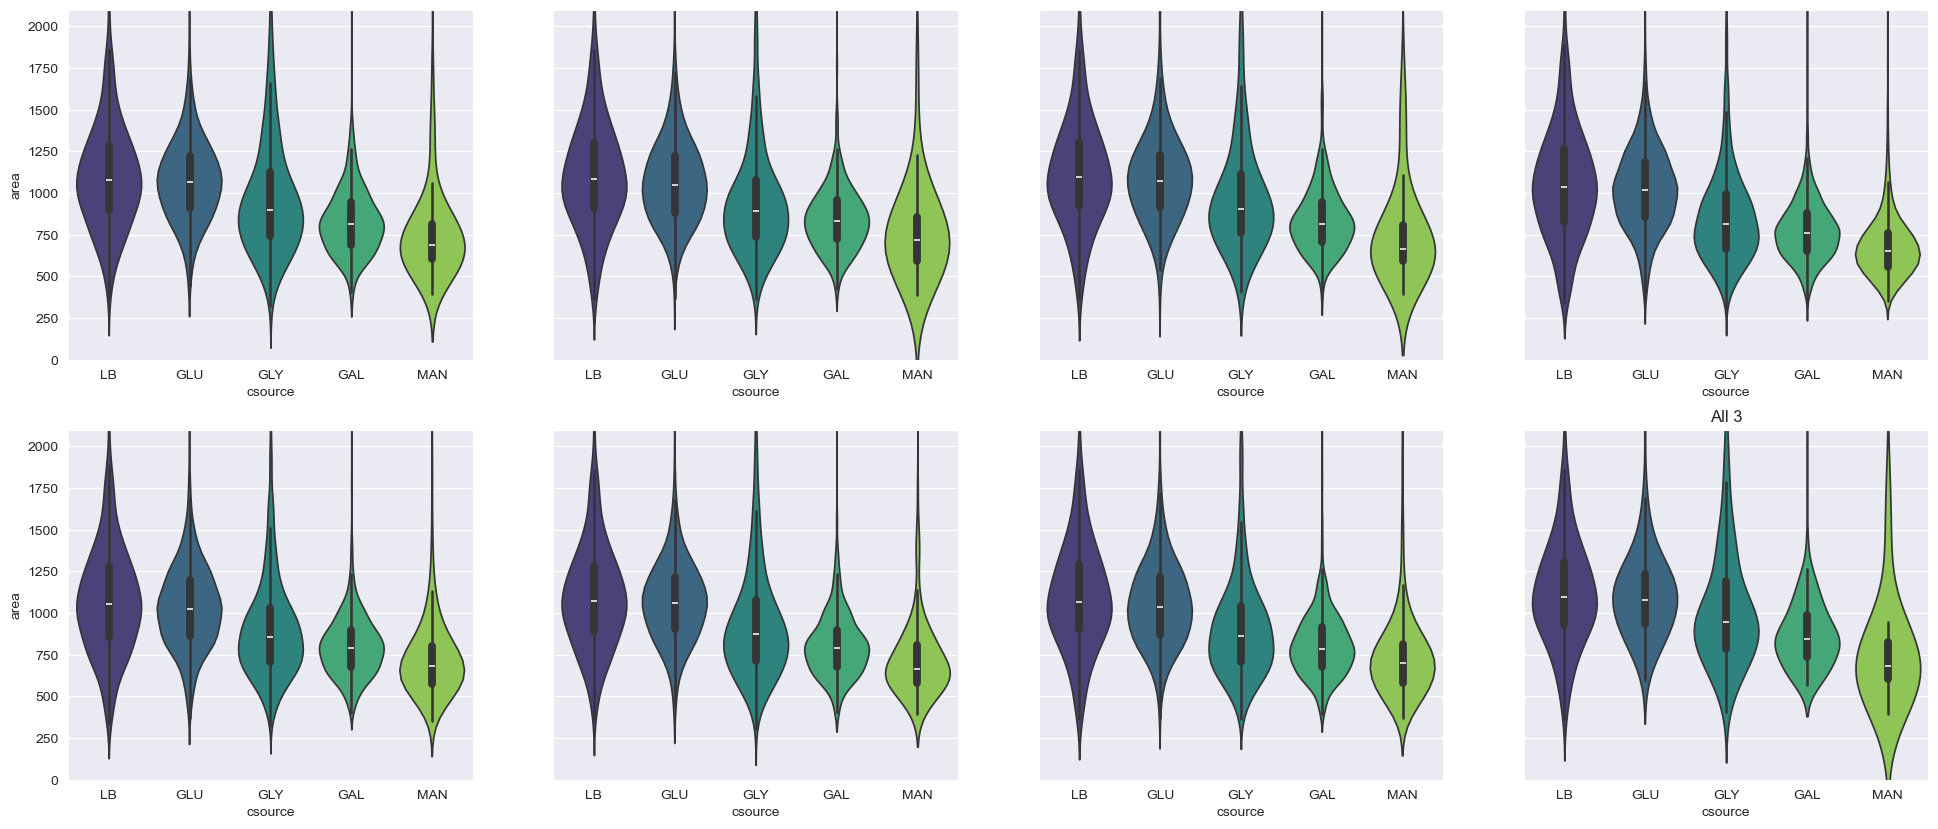

In [133]:
fig, ax = plt.subplots(2, 4, figsize=(24, 10), sharey=True)
ax[0][0].set_ylim(0, 2100)
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0').query('spots_rnlAB > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][0])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0').query('spots_hipBA > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][1])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rnlAB > 0').query('spots_hipBA > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][2])
sns.violinplot(data=df_records.query('replicate == "exp22"'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][3])

sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][0])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rnlAB > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][1])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_hipBA > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][2])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0').query('spots_rnlAB > 0').query('spots_hipBA > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][3]).set_title("All 3");


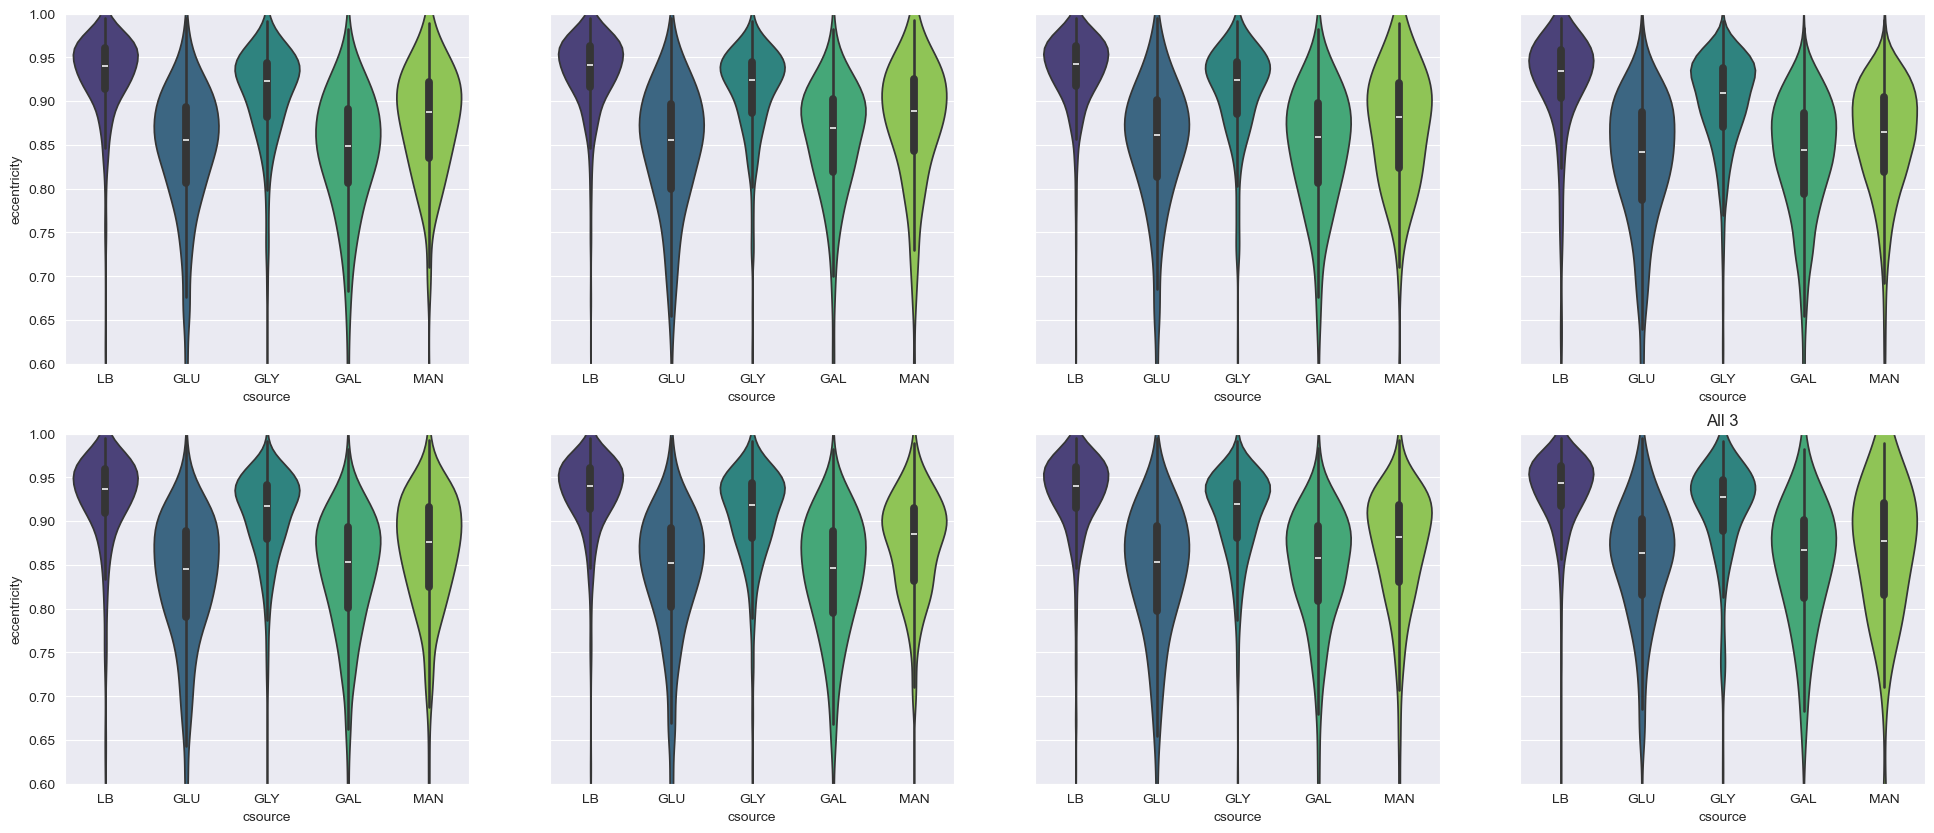

In [136]:
fig, ax = plt.subplots(2, 4, figsize=(24, 10), sharey=True)
ax[0][0].set_ylim(0.6, 1)
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0').query('spots_rnlAB > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][0])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0').query('spots_hipBA > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][1])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rnlAB > 0').query('spots_hipBA > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][2])
sns.violinplot(data=df_records.query('replicate == "exp22"'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][3])

sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][0])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rnlAB > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][1])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_hipBA > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][2])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0').query('spots_rnlAB > 0').query('spots_hipBA > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][3]).set_title("All 3");


### Localisation

#### Distance of spots to cell centroid/closest cell tip
 

In [1955]:
df_stacked.columns


Index(['image_cell_id', 'spots', 'dense_regions', 'decomposed_RNAs', 'tx',
       'nascent_RNAs', 'total_RNAs', 'mrna', 'strain', 'condition', 'seqnr',
       'image', 'experiment', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'axis_minor_length', 'axis_major_length', 'orientation',
       'perimeter', 'solidity', 'nuclei', 'csource', 'coverslip', 'replicate',
       'unique_cell_id', 'selected', 'RNAs_over_area', 'volume',
       'volume_ellipsoid', 'RNAs_over_vol', 'RNAs_over_length', 'mu',
       'RNAs_over_eccentricity'],
      dtype='object')

#### Distance of spots to cell mask

#### Distance of spots to closest nucleoid tip

#### Distance of spots to nuclei


### Transcription sites

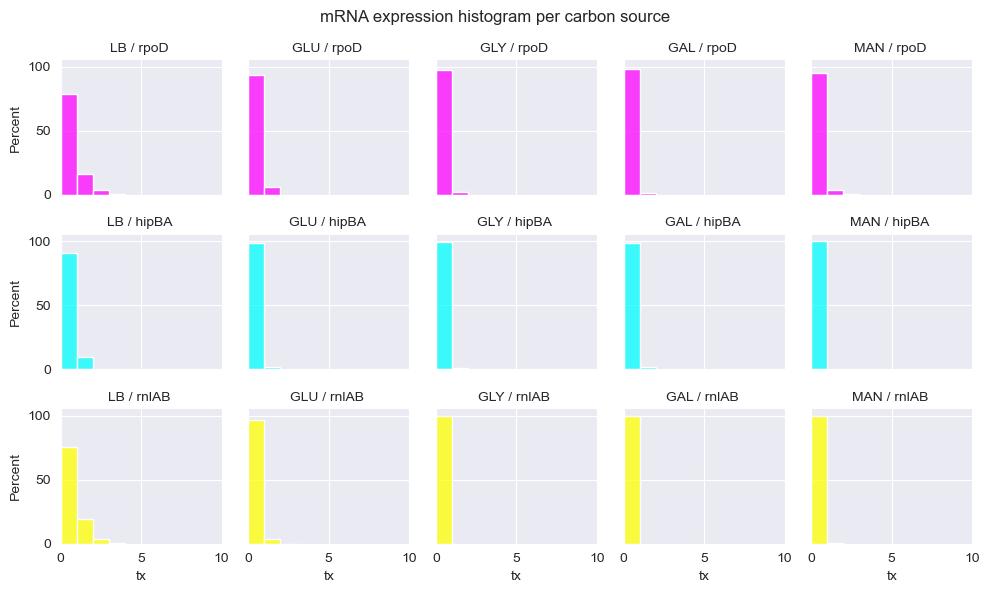

In [671]:
g = sns.FacetGrid(df_stacked, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 10), sharex=True, sharey=True, hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='tx', binwidth=1, stat='percent')
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression histogram per carbon source')
g.tight_layout();


## Quality control

### Inspect images individually

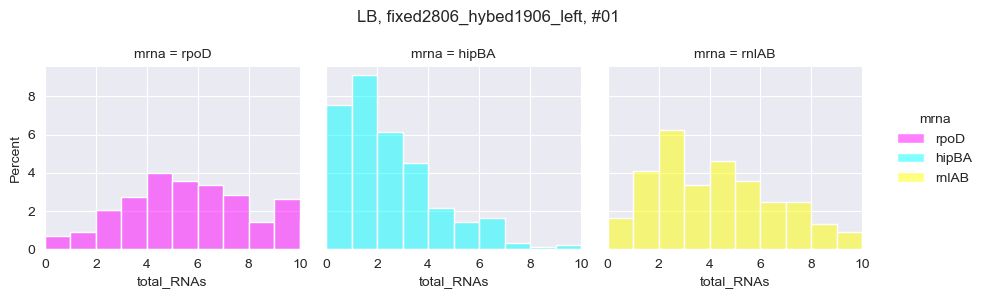

In [672]:
image = 'MG1655_LB_fixed2806_hybed1906_left_01'
data = df_stacked.query('image == @image')

fields = data.iloc[0, :].to_dict()
title = f"{fields['csource']}, {fields['coverslip']}, #{fields['seqnr']}"

g = sns.displot(data=data, x='total_RNAs', col='mrna', col_order=mrna_ordered, binwidth=1, stat='percent',
                hue='mrna', palette=palette_mrna, height=3, facet_kws={'xlim': [0, 10], 'sharex': True, 'sharey':True})
g.fig.suptitle(title)
g.tight_layout();

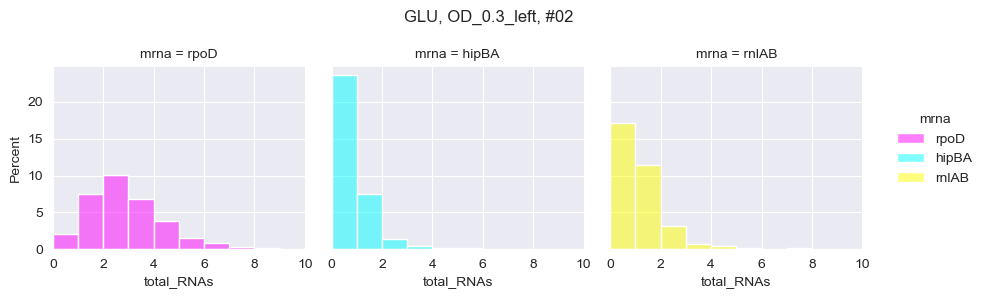

In [673]:
image = 'MG1655_GLU_OD_0.3_left_02'
data = df_stacked.query('image == @image')

fields = data.iloc[0, :].to_dict()
title = f"{fields['csource']}, {fields['coverslip']}, #{fields['seqnr']}"

g = sns.displot(data=data, x='total_RNAs', col='mrna', col_order=mrna_ordered, binwidth=1, stat='percent',
                hue='mrna', palette=palette_mrna, height=3, facet_kws={'xlim': [0, 10], 'sharex': True, 'sharey':True})
g.fig.suptitle(title)
g.tight_layout();

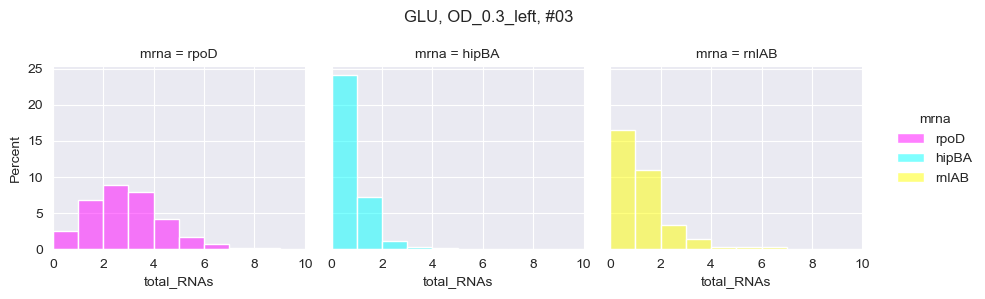

In [674]:
image = 'MG1655_GLU_OD_0.3_left_03'
data = df_stacked.query('image == @image')

fields = data.iloc[0, :].to_dict()
title = f"{fields['csource']}, {fields['coverslip']}, #{fields['seqnr']}"

g = sns.displot(data=data, x='total_RNAs', col='mrna', col_order=mrna_ordered, binwidth=1, stat='percent',
                hue='mrna', palette=palette_mrna, height=3, facet_kws={'xlim': [0, 10], 'sharex': True, 'sharey':True})
g.fig.suptitle(title)
g.tight_layout();

### Spot intensity histograms
Spots in cells versus spots outside cells

See `intensities.ipynb` notebook.